# Setup

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

TrentBrick github repository for DiscreteFlows:
 https://github.com/TrentBrick/PyTorchDiscreteFlows.git

In [1]:
!git clone https://github.com/TrentBrick/PyTorchDiscreteFlows.git

Cloning into 'PyTorchDiscreteFlows'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 165 (delta 78), reused 134 (delta 51), pack-reused 0
Receiving objects: 100% (165/165), 2.89 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [2]:
!pip install torch==1.7.1 torchvision==0.8.2 

     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 15.4MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [14]:
import PyTorchDiscreteFlows.discrete_flows.disc_utils
from PyTorchDiscreteFlows.discrete_flows.made import MADE
from PyTorchDiscreteFlows.discrete_flows.mlp import MLP
from PyTorchDiscreteFlows.discrete_flows.embed import EmbeddingLayer
from PyTorchDiscreteFlows.discrete_flows.disc_models import *

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import figure
from matplotlib.backends import backend_agg
from scipy.stats import multivariate_normal
import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import itertools
import math
import random
import time
import os

In [ ]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(seed)
DEBUG = False

In [ ]:

# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2

#Modified Discrete Bipartite Flow Model

In [16]:
# Discrete Bipartite Flow
class DiscreteBipartiteFlow(nn.Module):
    """A discrete reversible layer.
    The flow takes as input a one-hot Tensor of shape `[..., length, vocab_size]`.
    The flow returns a Tensor of same shape and dtype. (To enable gradients, the
    input must have float dtype.)
    For the forward pass, the flow computes:
    ```none
    net = layer(mask * inputs)
    loc, scale = tf.split(net, 2, axis=-1)
    loc = tf.argmax(loc, axis=-1)
    scale = tf.argmax(scale, axis=-1)
    outputs = ((inputs - (1-mask) * loc) * (1-mask) * inverse(scale)) % vocab_size
    ```
    For the reverse pass, the flow computes:
    ```none
    net = layer(mask * inputs)
    loc, scale = tf.split(net, 2, axis=-1)
    loc = tf.argmax(loc, axis=-1)
    scale = tf.argmax(scale, axis=-1)
    outputs = ((1-mask) * loc + (1-mask) * scale * inputs) % vocab_size
    ```
    The modular arithmetic happens in one-hot space.
    If `x` is a discrete random variable, the induced probability mass function on
    the outputs `y = flow(x)` is
    ```none
    p(y) = p(flow.reverse(y)).
    ```
    The location-only transform is always invertible ([integers modulo
    `vocab_size` form an additive group](
    https://en.wikipedia.org/wiki/Modular_arithmetic)). The transform with a scale
    is invertible if the scale and `vocab_size` are coprime (see
    [prime fields](https://en.wikipedia.org/wiki/Finite_field)).
    """

    def __init__(self, layer, parity, temperature, vocab_size, dim, scale_opt=False):
        """Constructs flow.
        Args:
        layer: Two-headed masked network taking the inputs and returning a
            real-valued Tensor of shape `[..., length, 2*vocab_size]`.
            Alternatively, `layer` may return a Tensor of shape
            `[..., length, vocab_size]` to be used as the location transform; the
            scale transform will be hard-coded to 1.
        mask: binary Tensor of shape `[length]` forming the bipartite assignment.
        temperature: Positive value determining bias of gradient estimator.
        **kwargs: kwargs of parent class.
        """
        super().__init__()
        self.layer = layer
        self.parity = parity # going to do a block split. #torch.tensor(mask).float()
        self.temperature = temperature
        self.vocab_size = vocab_size
        self.dim = dim # total dimension of the vector being dealt with. 
        self.scale_opt = scale_opt

    def reverse(self, inputs, **kwargs):
        """reverse pass for bipartite data to latent."""
        #TODO: implement even odd shuffling. 
        
        #Remove Embedded and flatten
        #Remove scale for now
        # Flatten -> Hidden -> Relu -> Output (Loc)
        z0, z1 = inputs[:, :inputs.shape[1]//2].type(torch.float), inputs[:, inputs.shape[1]//2:].type(torch.float) # dim is proportionally divided in preporcessing
        #print(z0.shape)
        if self.parity:
            x0, x1 = z1, z0
        else:
            x0, x1 = z0, z1
        #print(z0.view(z0.shape[0], -1).shape)
        layer_out = self.layer(x0.view(x0.shape[0], -1)) 
        #print(layer_out.shape)
        
        loc, scale = torch.chunk(layer_out, 2, dim=-1)
        #print(loc.shape)
        # Reshape both loc and scale
        loc = loc.view(loc.shape[0], int(loc.shape[-1]/self.vocab_size), -1)
        scale = scale.view(scale.shape[0], int(scale.shape[-1]/self.vocab_size), -1)
        #print(loc.shape)
        #print(scale.shape)

        loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
        #print(x1.shape)
        if self.scale_opt:
            scale = disc_utils.one_hot_argmax(scale, self.temperature).type(inputs.dtype)
            inverse_scale = disc_utils.multiplicative_inverse(scale, self.vocab_size)
            shifted_inputs = disc_utils.one_hot_minus(x1, loc)
            x1 = disc_utils.one_hot_multiply(shifted_inputs, inverse_scale)
        else:
            x1 = disc_utils.one_hot_minus(x1, loc)

        if self.parity:
            x0, x1 = x1, x0
        x = torch.cat([x0, x1], dim=1)

        return x

        '''
        assert len(inputs.shape) ==2, 'need to flatten the inputs first!!!'
        z0, z1 = inputs[:,:self.dim//2], inputs[:,self.dim//2:]
        if self.parity:
            z0, z1 = z1, z0
        x0 = z0 
        if self.embedding:
            layer_outs = self.layer( torch.argmax(x0,dim=1).long() , **kwargs)
        else: 
            layer_outs = self.layer(x0, **kwargs)
        
        if layer_outs.shape[-1] == 2 * self.vocab_size: # have a location and scaling parameter
            loc, scale = torch.split(layer_outs, self.vocab_size, dim=-1)
            loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
            scale = disc_utils.one_hot_argmax(scale, self.temperature).type(inputs.dtype)
            #print('the scale', scale.argmax(-1))
            inverse_scale = disc_utils.multiplicative_inverse(scale, self.vocab_size)
            shifted_inputs = disc_utils.one_hot_minus(z1, loc)
            x1 = disc_utils.one_hot_multiply(shifted_inputs, inverse_scale)

        elif layer_outs.shape[-1] == self.vocab_size:
            loc = layer_outs
            loc = disc_utils.one_hot_argmax(loc, self.temperature).type( inputs.dtype)
            x1 = disc_utils.one_hot_minus(z1, loc)
        else:
            raise ValueError('Output of layer does not have compatible dimensions.')
        if self.parity:
            x0, x1 = x1, x0
        x = torch.cat([x0, x1], dim=1)
        return x
        '''

    def forward(self, inputs, **kwargs):
        """Reverse pass for the inverse bipartite transformation. From data to latent. """
        '''
        assert len(inputs.shape) ==2, 'need to flatten the inputs first!'
        x0, x1 = inputs[:,:self.dim//2], inputs[:,self.dim//2:]
        if self.parity:
            x0, x1 = x1, x0
        z0 = x0 
        if self.embedding:
            layer_outs = self.layer( torch.argmax(z0,dim=1).long() , **kwargs)
        else: 
            layer_outs = self.layer(z0, **kwargs)
        '''
        #Remove Embedded and flatten
        #Remove scale for now
        # Flatten -> Hidden -> Relu -> Output (Loc)
        # outputting loc and scale
        
        x0, x1 = inputs[:, :inputs.shape[1]//2].type(torch.float), inputs[:, inputs.shape[1]//2:].type(torch.float) # dim is proportionally divided in preporcessing
        #print(x0.shape)
        if self.parity:
            z0, z1 = x1, x0
        else:
            z0, z1 = x0, x1
        #print(z0.view(z0.shape[0], -1).shape)
        layer_out = self.layer(z0.view(z0.shape[0], -1)) 
        #print(layer_out.shape)

        #print(torch.nn.functional.one_hot(layer_out.type(torch.long), num_classes=self.vocab_size))
        loc, scale = torch.chunk(layer_out, 2, dim=-1)
        #print(loc.shape)
        # Reshape both loc and scale
        loc = loc.view(loc.shape[0], int(loc.shape[-1]/self.vocab_size), -1)
        scale = scale.view(scale.shape[0], int(scale.shape[-1]/self.vocab_size), -1)
        #print(loc.shape)
        #print(scale.shape)

        if self.scale_opt:
            scale = disc_utils.one_hot_argmax(scale, self.temperature).type(inputs.dtype)
            scaled_inputs = disc_utils.one_hot_multiply(z1, scale)
        else:
            scaled_inputs = z1
        '''
        if layer_outs.shape[-1] == 2 * self.vocab_size:
            loc, scale = torch.split(layer_outs, self.vocab_size, dim=-1)
            scale = disc_utils.one_hot_argmax(scale, self.temperature).type(inputs.dtype)
            #print('the scale', scale)
            scaled_inputs = disc_utils.one_hot_multiply(x1, scale)
        # just outputting loc
        elif layer_outs.shape[-1] == self.vocab_size:
            loc = layer_outs
            scaled_inputs = x1 
        else:
            raise ValueError('Output of layer does not have compatible dimensions.')
        '''
        loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
        z1 = disc_utils.one_hot_add(loc, scaled_inputs)
        #print(z1.shape)
        if self.parity:
            z0, z1 = z1, z0
        z = torch.cat([z0, z1], dim=1)
        #print(z.shape)
        return z

    def log_det_jacobian(self, inputs):
        return torch.zeros((1)).type(inputs.dtype)

# Fundamental Test


Synthetic Data

In [ ]:
def sample_quantized_gaussian_mixture2D(batch_size):
    """Samples data from a 2D quantized mixture of Gaussians.
    This is a quantized version of the mixture of Gaussians experiment from the
    Unrolled GANS paper (Metz et al., 2017).
    Args:
        batch_size: The total number of observations.
    Returns:
        Tensor with shape `[batch_size, 2]`, where each entry is in
            `{0, 1, ..., max_quantized_value - 1}`, a rounded sample from a mixture
            of Gaussians.
    """
    clusters = np.array([[2., 0.], [np.sqrt(2), np.sqrt(2)],
                                             [0., 2.], [-np.sqrt(2), np.sqrt(2)],
                                             [-2., 0.], [-np.sqrt(2), -np.sqrt(2)],
                                             [0., -2.], [np.sqrt(2), -np.sqrt(2)]])
    assignments = torch.distributions.OneHotCategorical(
            logits=torch.zeros(8, dtype = torch.float32)).sample([batch_size])
    means = torch.matmul(assignments, torch.from_numpy(clusters).float())

    samples = torch.distributions.normal.Normal(loc=means, scale=0.1).sample()
    clipped_samples = torch.clamp(samples, -2.25, 2.25)
    quantized_samples = (torch.round(clipped_samples * 20) + 45).long()
    return quantized_samples

In [ ]:

def sample_quantized_gaussian_mixture3D(batch_size):
    """Samples data from a 2D quantized mixture of Gaussians.
    This is a quantized version of the mixture of Gaussians experiment from the
    Unrolled GANS paper (Metz et al., 2017).
    Args:
        batch_size: The total number of observations.
    Returns:
        Tensor with shape `[batch_size, 2]`, where each entry is in
            `{0, 1, ..., max_quantized_value - 1}`, a rounded sample from a mixture
            of Gaussians.
    """
    clusters = np.array([[2., 0., 0.],
                         [-2., 0., 0.],
                         [0., 2., 0.],
                         [0., -2., 0.],
                         [0., 0., 2.],
                         [0., 0., -2.],
                         [np.cbrt(2.), np.cbrt(2.), np.cbrt(2.)],
                         [-np.cbrt(2.), np.cbrt(2.), np.cbrt(2.)],
                         [np.cbrt(2.), -np.cbrt(2.), np.cbrt(2.)],
                         [-np.cbrt(2.), -np.cbrt(2.), np.cbrt(2.)],
                         [np.cbrt(2.), np.cbrt(2.), -np.cbrt(2.)],
                         [-np.cbrt(2.), np.cbrt(2.), -np.cbrt(2.)],
                         [np.cbrt(2.), -np.cbrt(2.), -np.cbrt(2.)],
                         [-np.cbrt(2.), -np.cbrt(2.), -np.cbrt(2.)]])
    assignments = torch.distributions.OneHotCategorical(
            logits=torch.zeros(14, dtype = torch.float32)).sample([batch_size])
    means = torch.matmul(assignments, torch.from_numpy(clusters).float())

    samples = torch.distributions.normal.Normal(loc=means, scale=0.1).sample()
    clipped_samples = torch.clamp(samples, -2.25, 2.25)
    quantized_samples = (torch.round(clipped_samples * 20) + 45).long()
    return quantized_samples

In [ ]:
def sample_quantized_gaussian_mixture4D(batch_size):
    """Samples data from a 2D quantized mixture of Gaussians.
    This is a quantized version of the mixture of Gaussians experiment from the
    Unrolled GANS paper (Metz et al., 2017).
    Args:
        batch_size: The total number of observations.
    Returns:
        Tensor with shape `[batch_size, 2]`, where each entry is in
            `{0, 1, ..., max_quantized_value - 1}`, a rounded sample from a mixture
            of Gaussians.
    """
    clusters = np.array([[2., 0., 0., 0.],
                         [-2., 0., 0., 0.],
                         [0., 2., 0., 0.],
                         [0., -2., 0., 0.],
                         [0., 0., 2., 0.],
                         [0., 0., -2., 0.],
                         [np.cbrt(2.), np.cbrt(2.), np.cbrt(2.), 0.],
                         [-np.cbrt(2.), np.cbrt(2.), np.cbrt(2.), 0.],
                         [np.cbrt(2.), -np.cbrt(2.), np.cbrt(2.), 0.],
                         [-np.cbrt(2.), -np.cbrt(2.), np.cbrt(2.), 0.],
                         [np.cbrt(2.), np.cbrt(2.), -np.cbrt(2.), 0.],
                         [-np.cbrt(2.), np.cbrt(2.), -np.cbrt(2.), 0.],
                         [np.cbrt(2.), -np.cbrt(2.), -np.cbrt(2.), 0.],
                         [-np.cbrt(2.), -np.cbrt(2.), -np.cbrt(2.), 0.]])
    assignments = torch.distributions.OneHotCategorical(
            logits=torch.zeros(14, dtype = torch.float32)).sample([batch_size])
    means = torch.matmul(assignments, torch.from_numpy(clusters).float())

    samples = torch.distributions.normal.Normal(loc=means, scale=0.1).sample()
    clipped_samples = torch.clamp(samples, -2.25, 2.25)
    quantized_samples = (torch.round(clipped_samples * 20) + 45).long()
    return quantized_samples

Parameters

In [ ]:
torch.set_printoptions(edgeitems=5)
np.set_printoptions(edgeitems=2)
batch_size, sequence_length, vocab_size = 2048, 2, 91
data = sample_quantized_gaussian_mixture2D(batch_size)
print(data)

tensor([[49,  6],
        [45,  4],
        [84, 44],
        [46,  6],
        [16, 76],
        ...,
        [85, 44],
        [12, 72],
        [43, 90],
        [44,  2],
        [ 7, 44]])


Image of Target Distribution

Text(0.5, 1.0, 'Data Distribution')

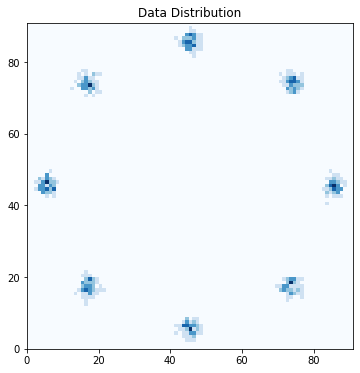

In [ ]:
figsize = (6, 6)
fig = fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
#canvas = backend_agg.FigureCanvasAgg(fig)
data_prob_table = np.histogramdd(data, bins=vocab_size)
ax.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
             cmap=cm.get_cmap("Blues", 6),
             origin="lower",
             extent=[0, vocab_size, 0, vocab_size],
             interpolation="nearest")
#fig.show()
ax.set_title("Data Distribution")

IndexError: ignored

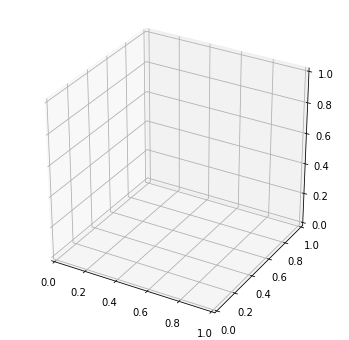

In [ ]:
import sys
figsize = (6, 6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1, projection='3d')
#canvas = backend_agg.FigureCanvasAgg(fig)
data_prob_table = np.histogramdd(data, bins=vocab_size)

ax.scatter(data.numpy()[:, 0], data.numpy()[:, 1], data.numpy()[:, 2])
'''
ax.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
             cmap=cm.get_cmap("Blues", 6),
             origin="lower",
             extent=[0, vocab_size, 0, vocab_size],
             interpolation="nearest")
'''
fig.show()
ax.set_title("Data Distribution")

Parameter for Layer

In [ ]:
num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'

# This setting was previously used for the MLP and MADE networks. 
nh = 8 # number of hidden units per layer
vector_length = sequence_length*vocab_size

Adding Layer to Model

In [ ]:
flows = []
for i in range(num_flows):
    if disc_layer_type == 'autoreg':
        
        #layer = EmbeddingLayer([batch_size, sequence_length, vocab_size], output_size=vocab_size)
        # MADE network is much more powerful. 
        layer = MADE([batch_size, sequence_length, vocab_size], vocab_size, [nh, nh, nh])
        
        disc_layer = DiscreteAutoregressiveFlow( layer, temperature, 
                                                    vocab_size )
    
    elif disc_layer_type == 'bipartite':
        # MLP will learn the factorized distribution and not perform well. 
        #layer = MLP(vector_length//2, vector_length//2, nh)
        
        #layer = torch.nn.Embedding(vector_length//2, vector_length//2)
        if i%2:
            dim = math.ceil(sequence_length/2)
            dim_ = sequence_length - dim        # Dim of other half of the bipartite
            vector_length = dim * vocab_size
            vector_length_ = dim_ * vocab_size  # Vector length of other half of the bipartite
        else:
            dim = sequence_length // 2
            dim_ = sequence_length - dim        # Dim of other half of the bipartite
            vector_length = dim * vocab_size
            vector_length_ = dim_ * vocab_size  # Vector length of other half of the bipartite

        layer = nn.Sequential(nn.Linear(vector_length, vector_length * 4),
                              nn.ReLU(),
                              nn.Linear(vector_length * 4, vector_length * 4),
                              nn.ReLU(),
                              nn.Linear(vector_length * 4, vector_length_ * 2) # vector_length * 2 allow for both loc and scale
                              )
        
        print(layer)
        disc_layer = DiscreteBipartiteFlow(layer, i%2, temperature, 
                                            vocab_size, dim, scale_opt=False)
        # i%2 flips the parity of the masking. It splits the vector in half and alternates
        # each flow between changing the first half or the second. 
    
    flows.append(disc_layer)
    
model = DiscreteAutoFlowModel(flows)
model

DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=182, out_features=8, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=8, out_features=8, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=8, out_features=182, bias=True)
        )
      )
    )
  )
)

Original Layers

In [ ]:
flows = []
for i in range(num_flows):
    if disc_layer_type == 'autoreg':
        
        #layer = EmbeddingLayer([batch_size, sequence_length, vocab_size], output_size=vocab_size)
        # MADE network is much more powerful. 
        layer = MADE([batch_size, sequence_length, vocab_size], vocab_size, [nh, nh, nh])
        
        disc_layer = DiscreteAutoregressiveFlow( layer, temperature, 
                                                    vocab_size )
    
    elif disc_layer_type == 'bipartite':
        # MLP will learn the factorized distribution and not perform well. 
        #layer = MLP(vector_length//2, vector_length//2, nh)
        
        layer = torch.nn.Embedding(vector_length//2, vector_length//2)
        
        disc_layer = DiscreteBipartiteFlow(layer, i%2, temperature, 
                                            vocab_size, vector_length, embedding=True)
        # i%2 flips the parity of the masking. It splits the vector in half and alternates
        # each flow between changing the first half or the second. 
    
    flows.append(disc_layer)
    
model = DiscreteAutoFlowModel(flows)
model

DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=182, out_features=8, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=8, out_features=8, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=8, out_features=182, bias=True)
        )
      )
    )
  )
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


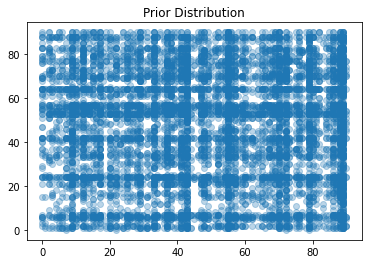

In [ ]:
base_log_probs = torch.tensor(torch.randn(sequence_length, vocab_size), requires_grad = True)
base = torch.distributions.OneHotCategorical(logits = base_log_probs)

samps = base.sample((10000,)).argmax(-1)
plt.scatter(samps[:,0], samps[:,1], alpha=0.3)
plt.title("Prior Distribution")
plt.show()

My Training

DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=182, out_features=8, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=8, out_features=8, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=8, out_features=182, bias=True)
        )
      )
    )
  )
)
epoch: 0 loss: 9.852304458618164
epoch: 150 loss: 7.652120590209961
epoch: 300 loss: 7.148646831512451
epoch: 450 loss: 7.092456340789795
epoch: 600 loss: 7.047981262207031
epoch: 750 loss: 7.030343532562256
epoch: 900 loss: 7.029052257537842
epoch: 1050 loss: 7.046794891357422
epoch: 1200 loss: 7.046090602874756
epoch: 1350 loss: 7.016591548919678


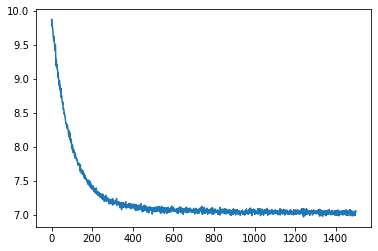

In [ ]:
epochs = 1500
learning_rate = 0.01
print_loss_every = epochs//10

losses = []
optimizer = torch.optim.Adam( 
        [
            {'params': model.parameters() , 'lr':learning_rate},
            {'params': base_log_probs, 'lr': learning_rate }
        ])

model.train()
print(model)
for e in range(epochs):
    x = sample_quantized_gaussian_mixture2D(batch_size)
    x = F.one_hot(x, num_classes = vocab_size).float()

    ''' Removed for our implementation
    if disc_layer_type == 'bipartite':
        x= x.view(x.shape[0], -1) #flattening vector
    '''
    optimizer.zero_grad()
    zs = model.forward(x)
    
    ''' Removed for our implementation
    if disc_layer_type == 'bipartite':
        zs = zs.view(batch_size, sequence_length, -1) # adding back in sequence dimension
    '''
    
    base_log_probs_sm = torch.nn.functional.log_softmax(base_log_probs, dim=-1)
    #print(zs.shape, base_log_probs_sm.shape)
    logprob = zs*base_log_probs_sm # zs are onehot so zero out all other logprobs. 
    loss = -torch.sum(logprob)/batch_size
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if e%print_loss_every==0:
        print('epoch:', e, 'loss:', loss.item())

plt.plot(losses)

Original Training

In [ ]:
epochs = 1500
learning_rate = 0.01
print_loss_every = epochs//10

losses = []
optimizer = torch.optim.Adam( 
        [
            {'params': model.parameters() , 'lr':learning_rate},
            {'params': base_log_probs, 'lr': learning_rate }
        ])

model.train()
for e in range(epochs):
    x = sample_quantized_gaussian_mixture2D(batch_size)
    x = F.one_hot(x, num_classes = vocab_size).float()
    
    if disc_layer_type == 'bipartite':
        x= x.view(x.shape[0], -1) #flattening vector
    
    optimizer.zero_grad()
    zs = model.forward(x)
    
    if disc_layer_type == 'bipartite':
        zs = zs.view(batch_size, sequence_length, -1) # adding back in sequence dimension
    
    base_log_probs_sm = torch.nn.functional.log_softmax(base_log_probs, dim=-1)
    #print(zs.shape, base_log_probs_sm.shape)
    logprob = zs*base_log_probs_sm # zs are onehot so zero out all other logprobs. 
    loss = -torch.sum(logprob)/batch_size
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if e%print_loss_every==0:
        print('epoch:', e, 'loss:', loss.item())

plt.plot(losses)

epoch: 0 loss: 6.933276176452637


KeyboardInterrupt: ignored

FileNotFoundError: ignored

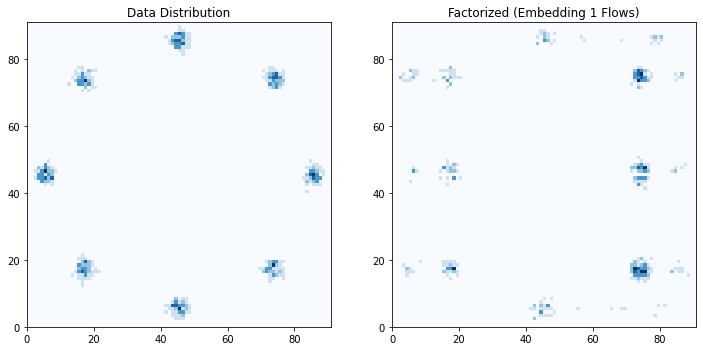

In [ ]:
data_distribution = torch.distributions.OneHotCategorical(logits=base_log_probs)
samples = data_distribution.sample([batch_size])
'''
if disc_layer_type == 'bipartite':
    samples = samples.view(samples.shape[0], -1)
'''
samples = model.reverse(samples)
if disc_layer_type == 'bipartite':
    samples = samples.view(batch_size, sequence_length, -1)
data_samples = torch.argmax(samples, axis=-1).detach().numpy()

figsize = (12, 6)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
data_prob_table = np.histogramdd(data, bins=vocab_size)
ax1.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
ax1.set_title("Data Distribution")
ax2.set_title("{} ({} {} Flows)".format(
  "factorized".replace("_", " ").title(),
  "embedding".title(),
  1))
learned_prob_table = np.histogramdd(data_samples, bins=vocab_size)
ax2.imshow(learned_prob_table[0]/np.sum(learned_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
fig.show()
plt.gcf().savefig('figures/Fig2Reproduce.png', dpi=250)

FileNotFoundError: ignored

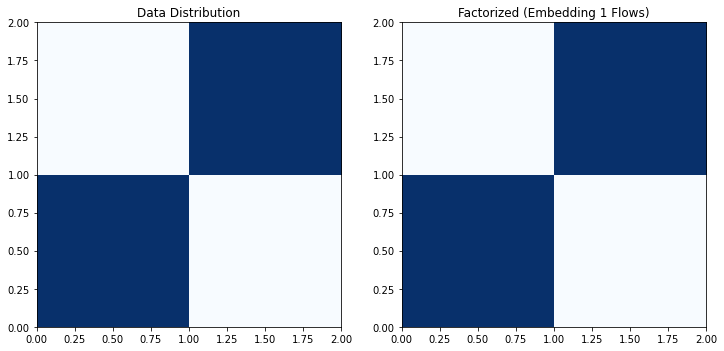

In [ ]:
data_distribution = torch.distributions.OneHotCategorical(logits=base_log_probs)
samples = data_distribution.sample([batch_size])

if disc_layer_type == 'bipartite':
    samples = samples.view(samples.shape[0], -1)

samples = model.reverse(samples)
if disc_layer_type == 'bipartite':
    samples = samples.view(batch_size, sequence_length, -1)
data_samples = torch.argmax(samples, axis=-1).detach().numpy()

figsize = (12, 6)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
data_prob_table = np.histogramdd(data, bins=vocab_size)
ax1.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
ax1.set_title("Data Distribution")
ax2.set_title("{} ({} {} Flows)".format(
  "factorized".replace("_", " ").title(),
  "embedding".title(),
  1))
learned_prob_table = np.histogramdd(data_samples, bins=vocab_size)
ax2.imshow(learned_prob_table[0]/np.sum(learned_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
fig.show()
plt.gcf().savefig('figures/Fig2Reproduce.png', dpi=250)

My Bipartite 3D Results (2 couple layers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


torch.Size([2048, 3, 91])


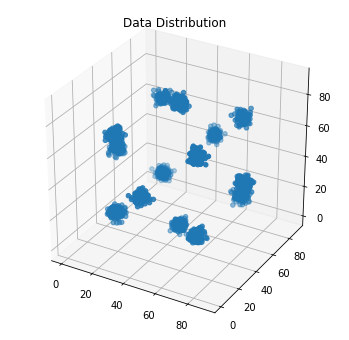

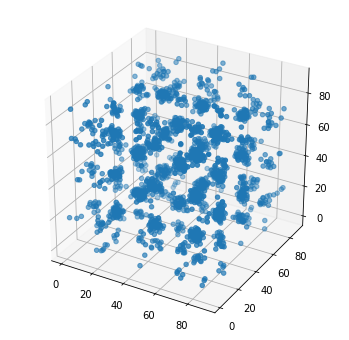

In [ ]:
data_distribution = torch.distributions.OneHotCategorical(logits=base_log_probs)
samples = data_distribution.sample([batch_size])

base_log_probs = torch.tensor(torch.randn(sequence_length, vocab_size), requires_grad = True)
base = torch.distributions.OneHotCategorical(logits = base_log_probs)
samples = data_distribution.sample([batch_size])
'''
if disc_layer_type == 'bipartite':
    samples = samples.view(samples.shape[0], -1)
'''
print(samples.shape)
samples = model.reverse(samples)
if disc_layer_type == 'bipartite':
    samples = samples.view(batch_size, sequence_length, -1)
data_samples = torch.argmax(samples, axis=-1).detach().numpy()


figsize = (6, 6)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(data.numpy()[:, 0], data.numpy()[:, 1], data.numpy()[:, 2])
ax1.set_title("Data Distribution")

fig = plt.figure(figsize=figsize)
ax2 = fig.add_subplot(1, 1, 1, projection='3d')
ax2.scatter(data_samples[:, 0], data_samples[:, 1], data_samples[:, 2])
plt.show()

Original Autoregressive 3D Results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


torch.Size([2048, 3, 91])


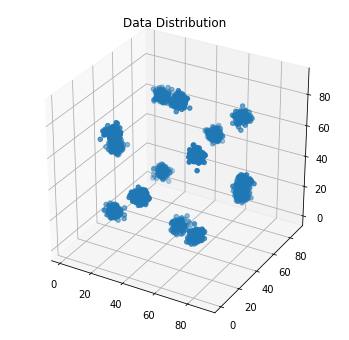

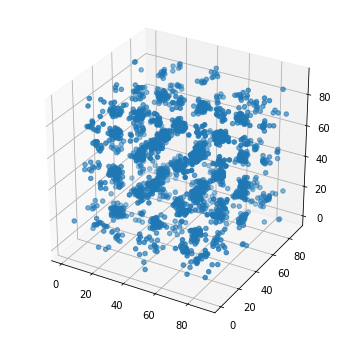

In [ ]:
data_distribution = torch.distributions.OneHotCategorical(logits=base_log_probs)
samples = data_distribution.sample([batch_size])

base_log_probs = torch.tensor(torch.randn(sequence_length, vocab_size), requires_grad = True)
base = torch.distributions.OneHotCategorical(logits = base_log_probs)
samples = data_distribution.sample([batch_size])
'''
if disc_layer_type == 'bipartite':
    samples = samples.view(samples.shape[0], -1)
'''
print(samples.shape)
samples = model.reverse(samples)
if disc_layer_type == 'bipartite':
    samples = samples.view(batch_size, sequence_length, -1)
data_samples = torch.argmax(samples, axis=-1).detach().numpy()


figsize = (6, 6)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(data.numpy()[:, 0], data.numpy()[:, 1], data.numpy()[:, 2])
ax1.set_title("Data Distribution")

fig = plt.figure(figsize=figsize)
ax2 = fig.add_subplot(1, 1, 1, projection='3d')
ax2.scatter(data_samples[:, 0], data_samples[:, 1], data_samples[:, 2])
plt.show()

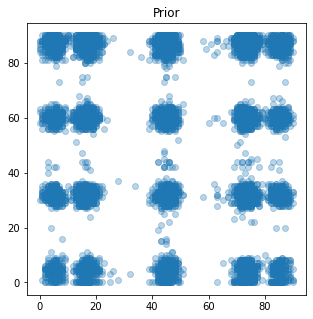

In [ ]:
base = torch.distributions.OneHotCategorical( logits = base_log_probs )
plt.figure(figsize=(5,5))
samps = base.sample((10000,)).argmax(-1)
plt.scatter(samps[:,0], samps[:,1], label = 'shifted data', alpha=0.3)
plt.title('Prior')
plt.show()

In [ ]:
a = [5] + [[5, 2]]

In [ ]:
b = np.array(a)
print(np.array(a))
print(b)

[5 list([5, 2])]
[5 list([5, 2])]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
"""
author: trentbrick
Code taken from: https://github.com/google/edward2/blob/master/edward2/tensorflow/layers/discrete_flows.py
Which is introduced and explained in the paper: https://arxiv.org/abs/1905.10347 
And modified for PyTorch. 
"""

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from . import disc_utils

class DiscreteAutoFlowModel(nn.Module):
    # combines all of the discrete flow layers into a single model
    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)

    def forward(self, z):
         # from the data to the latent space. This is how the base code is implemented. 
        for flow in self.flows:
            z = flow.forward(z)
        return z

    def reverse(self, x):
        # from the latent space to the data
        for flow in self.flows[::-1]:
            x = flow.reverse(x)
        return x

class Reverse(nn.Module):
    """Swaps the forward and reverse transformations of a layer."""
    def __init__(self, reversible_layer, **kwargs):
        super(Reverse, self).__init__(**kwargs)
        if not hasattr(reversible_layer, 'reverse'):
            raise ValueError('Layer passed-in has not implemented "reverse" method: '
                        '{}'.format(reversible_layer))
        self.forward = reversible_layer.reverse
        self.reverse = reversible_layer.forward


class DiscreteAutoregressiveFlow(nn.Module):
    """A discrete reversible layer.
    The flow takes as input a one-hot Tensor of shape `[..., length, vocab_size]`.
    The flow returns a Tensor of same shape and dtype. (To enable gradients, the
    input must have float dtype.)
    For the reverse pass, from data to latent the flow computes in serial:
    ```none
    outputs = []
    for t in range(length):
        new_inputs = [outputs, inputs[..., t, :]]
        net = layer(new_inputs)
        loc, scale = tf.split(net, 2, axis=-1)
        loc = tf.argmax(loc, axis=-1)
        scale = tf.argmax(scale, axis=-1)
        new_outputs = (((inputs - loc) * inverse(scale)) % vocab_size)[..., -1, :]
        outputs.append(new_outputs)
    ```
    For the forward pass from data to latent, the flow computes in parallel:
    ```none
    net = layer(inputs)
    loc, scale = tf.split(net, 2, axis=-1)
    loc = tf.argmax(loc, axis=-1)
    scale = tf.argmax(scale, axis=-1)
    outputs = (loc + scale * inputs) % vocab_size
    ```
    The modular arithmetic happens in one-hot space.
    If `x` is a discrete random variable, the induced probability mass function on
    the outputs `y = flow(x)` is
    ```none
    p(y) = p(flow.reverse(y)).
    ```
    The location-only transform is always invertible ([integers modulo
    `vocab_size` form an additive group](
    https://en.wikipedia.org/wiki/Modular_arithmetic)). The transform with a scale
    is invertible if the scale and `vocab_size` are coprime (see
    [prime fields](https://en.wikipedia.org/wiki/Finite_field)).
    """

    def __init__(self, layer, temperature, vocab_size):
        """Constructs flow.
        Args:
        layer: Two-headed masked network taking the inputs and returning a
            real-valued Tensor of shape `[..., length, 2*vocab_size]`.
            Alternatively, `layer` may return a Tensor of shape
            `[..., length, vocab_size]` to be used as the location transform; the
            scale transform will be hard-coded to 1.
        temperature: Positive value determining bias of gradient estimator.
        **kwargs: kwargs of parent class.
        """
        super().__init__()
        self.layer = layer
        self.temperature = temperature
        self.vocab_size = vocab_size

    def reverse(self, inputs, **kwargs):
        """Reverse pass for left-to-right autoregressive generation. Latent to data. 
        Expects to recieve a onehot."""
        #inputs = torch.Tensor(inputs)
        length = inputs.shape[-2]
        if length is None:
            raise NotImplementedError('length dimension must be known. Ensure input is a onehot with 3 dimensions (batch, length, onehot)')
        # Slowly go down the length of the sequence. 
        # the batch is computed in parallel, dont get confused with it and the sequence components!
        # From initial sequence tensor of shape [..., 1, vocab_size]. In a loop, we
        # incrementally build a Tensor of shape [..., t, vocab_size] as t grows.
        outputs = self._initial_call(inputs[:, 0, :], length, **kwargs)
        # TODO: Use tf.while_loop. Unrolling is memory-expensive for big
        # models and not valid for variable lengths.
        for t in range(1, length):
            outputs = self._per_timestep_call(outputs,
                                            inputs[..., t, :],
                                            length,
                                            t,
                                            **kwargs)
        return outputs

    def _initial_call(self, new_inputs, length, **kwargs):
        """Returns Tensor of shape [..., 1, vocab_size].
        Args:
        new_inputs: Tensor of shape [..., vocab_size], the new input to generate
            its output.
        length: Length of final desired sequence.
        **kwargs: Optional keyword arguments to layer.
        """
        inputs = new_inputs.unsqueeze(1) #new_inputs[..., tf.newaxis, :] # batch x 1 x onehots
        # TODO: To handle variable lengths, extend MADE to subset its
        # input and output layer weights rather than pad inputs.
        padded_inputs = F.pad(
            inputs, (0,0,0, length - 1) )
        
        """
        All this is doing is filling the input up to its length with 0s. 
        [[0, 0]] * 2 + [[0, 50 - 1], [0, 0]] -> [[0, 0], [0, 0], [0, 49], [0, 0]]
        what this means is, dont add any padding to the 0th dimension on the front or back. 
        same for the 2nd dimension (here we assume two tensors are for batches), for the length dimension, 
        add length -1 0s after. 
        
        """
        net = self.layer(padded_inputs, **kwargs) # feeding this into the MADE network. store these as net.
        if net.shape[-1] == 2 * self.vocab_size: # if the network outputted both a location and scale.
            loc, scale = torch.split(net, self.vocab_size, dim=-1) #tf.split(net, 2, axis=-1) # split in two into these variables
            loc = loc[..., 0:1, :] #
            loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
            scale = scale[..., 0:1, :]
            scale = disc_utils.one_hot_argmax(scale, self.temperature).type(inputs.dtype)
            inverse_scale = disc_utils.multiplicative_inverse(scale, self.vocab_size) # could be made more efficient by calculating the argmax once and passing it into both functions. 
            shifted_inputs = disc_utils.one_hot_minus(inputs, loc)
            outputs = disc_utils.one_hot_multiply(shifted_inputs, inverse_scale)
        elif net.shape[-1] == self.vocab_size:
            loc = net
            loc = loc[..., 0:1, :]
            loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
            outputs = disc_utils.one_hot_minus(inputs, loc)
        else:
            raise ValueError('Output of layer does not have compatible dimensions.')
        return outputs

    def _per_timestep_call(self,
                            current_outputs,
                            new_inputs,
                            length,
                            timestep,
                            **kwargs):
        """Returns Tensor of shape [..., timestep+1, vocab_size].
        Args:
        current_outputs: Tensor of shape [..., timestep, vocab_size], the so-far
            generated sequence Tensor.
        new_inputs: Tensor of shape [..., vocab_size], the new input to generate
            its output given current_outputs.
        length: Length of final desired sequence.
        timestep: Current timestep.
        **kwargs: Optional keyword arguments to layer.
        """
        inputs = torch.cat([current_outputs,
                            new_inputs.unsqueeze(1)], dim=-2)
        # TODO: To handle variable lengths, extend MADE to subset its
        # input and output layer weights rather than pad inputs.

        padded_inputs = F.pad(
            inputs, (0,0,0, length - timestep - 1) ) # only pad up to the current timestep

        net = self.layer(padded_inputs, **kwargs)
        if net.shape[-1] == 2 * self.vocab_size:
            loc, scale = torch.split(net, self.vocab_size, dim=-1)
            loc = loc[..., :(timestep+1), :]
            loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
            scale = scale[..., :(timestep+1), :]
            scale = disc_utils.one_hot_argmax(scale, self.temperature).type(inputs.dtype)
            inverse_scale = disc_utils.multiplicative_inverse(scale, self.vocab_size)
            shifted_inputs = disc_utils.one_hot_minus(inputs, loc)
            new_outputs = disc_utils.one_hot_multiply(shifted_inputs, inverse_scale)
        elif net.shape[-1] == self.vocab_size:
            loc = net
            loc = loc[..., :(timestep+1), :]
            loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
            new_outputs = disc_utils.one_hot_minus(inputs, loc)
        else:
            raise ValueError('Output of layer does not have compatible dimensions.')
        outputs = torch.cat([current_outputs, new_outputs[..., -1:, :]], dim=-2)
        return outputs

    def forward(self, inputs, **kwargs):
        """Forward pass returning the autoregressive transformation. Data to latent."""

        net = self.layer(inputs, **kwargs)
        if net.shape[-1] == 2 * self.vocab_size:
            loc, scale = torch.split(net, self.vocab_size, dim=-1)
            scale = disc_utils.one_hot_argmax(scale, self.temperature).type(inputs.dtype)
            scaled_inputs = disc_utils.one_hot_multiply(inputs, scale)
        elif net.shape[-1] == self.vocab_size:
            loc = net
            scaled_inputs = inputs
        else:
            raise ValueError('Output of layer does not have compatible dimensions.')
        loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
        outputs = disc_utils.one_hot_add(scaled_inputs, loc)
        return outputs

    def log_det_jacobian(self, inputs):
        return torch.zeros((1)).type(inputs.dtype)

# Discrete Bipartite Flow
class DiscreteBipartiteFlow(nn.Module):
    """A discrete reversible layer.
    The flow takes as input a one-hot Tensor of shape `[..., length, vocab_size]`.
    The flow returns a Tensor of same shape and dtype. (To enable gradients, the
    input must have float dtype.)
    For the forward pass, the flow computes:
    ```none
    net = layer(mask * inputs)
    loc, scale = tf.split(net, 2, axis=-1)
    loc = tf.argmax(loc, axis=-1)
    scale = tf.argmax(scale, axis=-1)
    outputs = ((inputs - (1-mask) * loc) * (1-mask) * inverse(scale)) % vocab_size
    ```
    For the reverse pass, the flow computes:
    ```none
    net = layer(mask * inputs)
    loc, scale = tf.split(net, 2, axis=-1)
    loc = tf.argmax(loc, axis=-1)
    scale = tf.argmax(scale, axis=-1)
    outputs = ((1-mask) * loc + (1-mask) * scale * inputs) % vocab_size
    ```
    The modular arithmetic happens in one-hot space.
    If `x` is a discrete random variable, the induced probability mass function on
    the outputs `y = flow(x)` is
    ```none
    p(y) = p(flow.reverse(y)).
    ```
    The location-only transform is always invertible ([integers modulo
    `vocab_size` form an additive group](
    https://en.wikipedia.org/wiki/Modular_arithmetic)). The transform with a scale
    is invertible if the scale and `vocab_size` are coprime (see
    [prime fields](https://en.wikipedia.org/wiki/Finite_field)).
    """

    def __init__(self, layer, parity, temperature, vocab_size, dim, scale_opt=False):
        """Constructs flow.
        Args:
        layer: Two-headed masked network taking the inputs and returning a
            real-valued Tensor of shape `[..., length, 2*vocab_size]`.
            Alternatively, `layer` may return a Tensor of shape
            `[..., length, vocab_size]` to be used as the location transform; the
            scale transform will be hard-coded to 1.
        mask: binary Tensor of shape `[length]` forming the bipartite assignment.
        temperature: Positive value determining bias of gradient estimator.
        **kwargs: kwargs of parent class.
        """
        super().__init__()
        self.layer = layer
        self.parity = parity # going to do a block split. #torch.tensor(mask).float()
        self.temperature = temperature
        self.vocab_size = vocab_size
        self.dim = dim # total dimension of the vector being dealt with. 
        self.scale_opt = scale_opt

    def reverse(self, inputs, **kwargs):
        """reverse pass for bipartite data to latent."""
        #TODO: implement even odd shuffling. 
        
        #Remove Embedded and flatten
        #Remove scale for now
        # Flatten -> Hidden -> Relu -> Output (Loc)
        z0, z1 = inputs[:, :inputs.shape[1]//2].type(torch.float), inputs[:, inputs.shape[1]//2:].type(torch.float) # dim is proportionally divided in preporcessing
        #print(z0.shape)
        if self.parity:
            x0, x1 = z1, z0
        else:
            x0, x1 = z0, z1
        #print(z0.view(z0.shape[0], -1).shape)
        layer_out = self.layer(x0.view(x0.shape[0], -1)) 
        #print(layer_out.shape)
        
        loc, scale = torch.chunk(layer_out, 2, dim=-1)
        #print(loc.shape)
        # Reshape both loc and scale
        loc = loc.view(loc.shape[0], int(loc.shape[-1]/self.vocab_size), -1)
        scale = scale.view(scale.shape[0], int(scale.shape[-1]/self.vocab_size), -1)
        #print(loc.shape)
        #print(scale.shape)

        loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
        #print(x1.shape)
        if self.scale_opt:
            scale = disc_utils.one_hot_argmax(scale, self.temperature).type(inputs.dtype)
            inverse_scale = disc_utils.multiplicative_inverse(scale, self.vocab_size)
            shifted_inputs = disc_utils.one_hot_minus(x1, loc)
            x1 = disc_utils.one_hot_multiply(shifted_inputs, inverse_scale)
        else:
            x1 = disc_utils.one_hot_minus(x1, loc)

        if self.parity:
            x0, x1 = x1, x0
        x = torch.cat([x0, x1], dim=1)

        return x

        '''
        assert len(inputs.shape) ==2, 'need to flatten the inputs first!!!'
        z0, z1 = inputs[:,:self.dim//2], inputs[:,self.dim//2:]
        if self.parity:
            z0, z1 = z1, z0
        x0 = z0 
        if self.embedding:
            layer_outs = self.layer( torch.argmax(x0,dim=1).long() , **kwargs)
        else: 
            layer_outs = self.layer(x0, **kwargs)
        
        if layer_outs.shape[-1] == 2 * self.vocab_size: # have a location and scaling parameter
            loc, scale = torch.split(layer_outs, self.vocab_size, dim=-1)
            loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
            scale = disc_utils.one_hot_argmax(scale, self.temperature).type(inputs.dtype)
            #print('the scale', scale.argmax(-1))
            inverse_scale = disc_utils.multiplicative_inverse(scale, self.vocab_size)
            shifted_inputs = disc_utils.one_hot_minus(z1, loc)
            x1 = disc_utils.one_hot_multiply(shifted_inputs, inverse_scale)

        elif layer_outs.shape[-1] == self.vocab_size:
            loc = layer_outs
            loc = disc_utils.one_hot_argmax(loc, self.temperature).type( inputs.dtype)
            x1 = disc_utils.one_hot_minus(z1, loc)
        else:
            raise ValueError('Output of layer does not have compatible dimensions.')
        if self.parity:
            x0, x1 = x1, x0
        x = torch.cat([x0, x1], dim=1)
        return x
        '''

    def forward(self, inputs, **kwargs):
        """Reverse pass for the inverse bipartite transformation. From data to latent. """
        '''
        assert len(inputs.shape) ==2, 'need to flatten the inputs first!'
        x0, x1 = inputs[:,:self.dim//2], inputs[:,self.dim//2:]
        if self.parity:
            x0, x1 = x1, x0
        z0 = x0 
        if self.embedding:
            layer_outs = self.layer( torch.argmax(z0,dim=1).long() , **kwargs)
        else: 
            layer_outs = self.layer(z0, **kwargs)
        '''
        #Remove Embedded and flatten
        #Remove scale for now
        # Flatten -> Hidden -> Relu -> Output (Loc)
        # outputting loc and scale
        
        x0, x1 = inputs[:, :inputs.shape[1]//2].type(torch.float), inputs[:, inputs.shape[1]//2:].type(torch.float) # dim is proportionally divided in preporcessing
        #print(x0.shape)
        if self.parity:
            z0, z1 = x1, x0
        else:
            z0, z1 = x0, x1
        #print(z0.view(z0.shape[0], -1).shape)
        layer_out = self.layer(z0.view(z0.shape[0], -1)) 
        #print(layer_out.shape)

        #print(torch.nn.functional.one_hot(layer_out.type(torch.long), num_classes=self.vocab_size))
        loc, scale = torch.chunk(layer_out, 2, dim=-1)
        #print(loc.shape)
        # Reshape both loc and scale
        loc = loc.view(loc.shape[0], int(loc.shape[-1]/self.vocab_size), -1)
        scale = scale.view(scale.shape[0], int(scale.shape[-1]/self.vocab_size), -1)
        #print(loc.shape)
        #print(scale.shape)

        if self.scale_opt:
            scale = disc_utils.one_hot_argmax(scale, self.temperature).type(inputs.dtype)
            scaled_inputs = disc_utils.one_hot_multiply(z1, scale)
        else:
            scaled_inputs = z1

        loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
        '''
        if layer_outs.shape[-1] == 2 * self.vocab_size:
            loc, scale = torch.split(layer_outs, self.vocab_size, dim=-1)
            scale = disc_utils.one_hot_argmax(scale, self.temperature).type(inputs.dtype)
            #print('the scale', scale)
            scaled_inputs = disc_utils.one_hot_multiply(x1, scale)
        # just outputting loc
        elif layer_outs.shape[-1] == self.vocab_size:
            loc = layer_outs
            scaled_inputs = x1 
        else:
            raise ValueError('Output of layer does not have compatible dimensions.')
        '''
        loc = disc_utils.one_hot_argmax(loc, self.temperature).type(inputs.dtype)
        z1 = disc_utils.one_hot_add(loc, scaled_inputs)
        #print(z1.shape)
        if self.parity:
            z0, z1 = z1, z0
        z = torch.cat([z0, z1], dim=1)
        #print(z.shape)
        return z

    def log_det_jacobian(self, inputs):
        return torch.zeros((1)).type(inputs.dtype)

Testing Correctness of Inverse


In [ ]:
torch.set_printoptions(edgeitems=50)
data_distribution = torch.distributions.OneHotCategorical(logits=base_log_probs)
samples = data_distribution.sample([batch_size])
reverse = model.reverse(samples)
samples = torch.argmax(samples, dim=-1)
null = model.forward(reverse)
null = torch.argmax(null, dim=-1)
print(samples - null)


#Synthetic Data / Functions

In [5]:
def get_all_k_length(k_values, d, answer): 
    k_len = len(k_values)  
    get_all_k_length_rec(k_values, [], k_len, d, answer) 
  
def get_all_k_length_rec(k_values, prefix, k_len, d, answer): 
    if (d == 0) : 
        answer.append(np.array(prefix))
        return

    for i in range(k_len): 
        newPrefix = prefix + [k_values[i]] 
        get_all_k_length_rec(k_values, newPrefix, k_len, d - 1, answer) 

def get_possible_k(k,d):
  answer = []
  k_values = list(range(0,k))
  get_all_k_length(k_values, d, answer)
  return np.array(answer)

def create_syn_data_paper(alpha,k,d,n_samples,rnd_seed,manual_prob,orig_probs,dirchlet_seed):
  if(manual_prob == False): # if manual prob is False ignore the passed original probs, 
  # and generate new ones from a dirchlet distrbuition
    np.random.seed(dirchlet_seed)
    orig_probs = np.random.dirichlet(np.ones(k**d)*alpha)
  np.random.seed(rnd_seed) # seed for random data
  X_train_coded = np.random.choice(k**d, size=n_samples, p=orig_probs) #for k=2 and d=2, X_train_coded = {0,1,2,3,2,3,0,...}
  return orig_probs,X_train_coded
  
def dec_to_bin(data,n_features,k):
  possible_bin_values = get_possible_k(k,n_features)
  result = possible_bin_values[data]
  return np.array(result)


In [6]:
def sample_batch_size_data(data,batch_size):
  n,d = data.shape
  chosen_indices = np.random.choice(n,batch_size,replace=False)
  return data[chosen_indices,:]
#sample_batch_size_data(result,10)

# Discrete Flow Functions



Prior Distribution

In [7]:
def create_base_prior(sequence_length, vocab_size):
    # Pior Distribution
    base_log_probs = torch.tensor(torch.randn(sequence_length, vocab_size), requires_grad = True)
    base = torch.distributions.OneHotCategorical(logits = base_log_probs)
    return base_log_probs

Discrete Flow Layer Param


In [19]:
def disc_flow_param(num_flows, temp, vocab_size, sequence_length, batch_size, disc_layer_type, hid_lay=0):
    '''
    batch_size, sequence_length, vocab_size = 1024, 2, 2

    num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
    temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
    disc_layer_type = 'autoreg' #'autoreg' #'bipartite'

    # This setting was previously used for the MLP and MADE networks. 
    nh = 64 # number of hidden units per layer
    vector_length = sequence_length*vocab_size
    '''

    flows = []
    for i in range(num_flows):
        if disc_layer_type == 'autoreg':
            
            #layer = EmbeddingLayer([batch_size, sequence_length, vocab_size], output_size=vocab_size)
            # MADE network is much more powerful. 
            layer = MADE([batch_size, sequence_length, vocab_size], vocab_size, [hid_lay, hid_lay, hid_lay])
            
            disc_layer = DiscreteAutoregressiveFlow( layer, temperature, 
                                                        vocab_size )
        
        elif disc_layer_type == 'bipartite':
        # MLP will learn the factorized distribution and not perform well. 
        #layer = MLP(vector_length//2, vector_length//2, nh)
        
        #layer = torch.nn.Embedding(vector_length//2, vector_length//2)
            if i%2:
                dim = math.ceil(sequence_length/2)
                dim_ = sequence_length - dim        # Dim of other half of the bipartite
                vector_length = dim * vocab_size
                vector_length_ = dim_ * vocab_size  # Vector length of other half of the bipartite
            else:
                dim = sequence_length // 2
                dim_ = sequence_length - dim        # Dim of other half of the bipartite
                vector_length = dim * vocab_size
                vector_length_ = dim_ * vocab_size  # Vector length of other half of the bipartite

            layer = nn.Sequential(nn.Linear(vector_length, math.ceil(vector_length/4)),
                                  nn.ReLU(),
                                  nn.Linear(math.ceil(vector_length/4), math.ceil(vector_length/4)),
                                  nn.ReLU(),
                                  nn.Linear(math.ceil(vector_length/4), vector_length_ * 2) # vector_length * 2 allow for both loc and scale
                                  )
        
            disc_layer = DiscreteBipartiteFlow(layer, i%2, temperature, 
                                                vocab_size, dim, scale_opt=False)
            # i%2 flips the parity of the masking. It splits the vector in half and alternates
            # each flow between changing the first half or the second. 
        flows.append(disc_layer)
        
    model = DiscreteAutoFlowModel(flows)
    return model

In [9]:
def train_disc_flow(model, data, base_log_probs, save_path, k_fold=None, k_fold_idx=None, epochs=1500, learning_rate=0.01):

    print_loss_every = epochs//10
    total_time = 0
    min_loss = 1e10

    losses = []
    optimizer = torch.optim.Adam( 
            [
                {'params': model.parameters() , 'lr':learning_rate},
                {'params': base_log_probs, 'lr': learning_rate }
            ])

    model.train()
    for e in range(epochs):
        start = time.time()
        x = torch.from_numpy(sample_batch_size_data(data, batch_size))
        x = F.one_hot(x, num_classes = vocab_size).float()
        
        optimizer.zero_grad()
        zs = model.forward(x)
        
        base_log_probs_sm = torch.nn.functional.log_softmax(base_log_probs, dim=-1)
        #print(zs.shape, base_log_probs_sm.shape)
        logprob = zs*base_log_probs_sm # zs are onehot so zero out all other logprobs. 
        loss = -torch.sum(logprob)/batch_size
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

        end = time.time()

        if loss < min_loss:
            min_loss = loss
            path_name = save_path + 'k' + str(k_fold) + '_' + str(k_fold_idx) + '.pt'
            torch.save({
                      'epoch': e,
                      'model_state_dict': model.state_dict(),
                      'prior': base_log_probs,
                      'optimizer_state_dict': optimizer.state_dict(),
                      'loss': loss}, path_name)
        
        if e%print_loss_every==0:
            print('epoch:', e, 'loss:', loss.item(), 'min loss:', min_loss)
        total_time = total_time + end - start
    plt.plot(losses)
    plt.show()

    return min_loss.clone().detach(), total_time, path_name

In [10]:
def test_disc_flow(data, load_path):
    batch_size = data.shape[0]
    print(batch_size)    
    open_path = torch.load(load_path)
    model.load_state_dict(open_path['model_state_dict'])
    base_log_probs = open_path['prior']

    model.eval()

    print(open_path['loss'])

    start = time.time()
    x = torch.from_numpy(data)
    x = F.one_hot(x, num_classes = vocab_size).float()
    
    zs = model.forward(x)

    base_log_probs_sm = torch.nn.functional.log_softmax(base_log_probs, dim=-1)
    #print(zs.shape, base_log_probs_sm.shape)
    logprob = zs*base_log_probs_sm # zs are onehot so zero out all other logprobs. 
    loss = -torch.sum(logprob)/batch_size
    end = time.time()
    final_time = end - start
    return loss, final_time

# Other Functions

K-fold function

In [11]:
def kfold_splitter(data,n,k,fold_num):
    fold_size = n//k
    test_data = data[fold_num*fold_size:(fold_num+1)*fold_size]
    train_data = np.vstack((data[0:fold_num*fold_size], data[(fold_num+1)*fold_size:n]))
    return train_data, test_data

#Synthetic Data Testing Bipartite

In [25]:
alpha = 1

Experiment 1

5 -fold:  1
(8000, 2)
DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1, out_features=4, bias=True)
      )
    )
    (1): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1, out_features=4, bias=True)
      )
    )
    (2): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1, out_features=4, bias=True)
      )
    )
    (3): DiscreteBipartiteFlow(
   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 1.384751796722412 min loss: tensor(1.3824, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.3868675231933594 min loss: tensor(1.3824, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.3852674961090088 min loss: tensor(1.3824, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.3856070041656494 min loss: tensor(1.3824, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.386679768562317 min loss: tensor(1.3824, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.3871548175811768 min loss: tensor(1.3824, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.386920690536499 min loss: tensor(1.3824, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.38957941532135 min loss: tensor(1.3824, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.385115623474121 min loss: tensor(1.3824, grad_fn=<DivBackward0>)


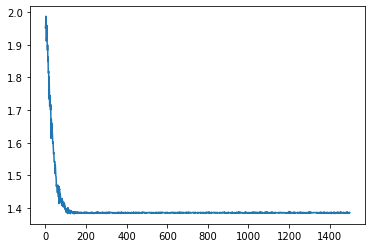

2000
tensor(1.3824, requires_grad=True)
Test Loss:  tensor(1.3870, grad_fn=<DivBackward0>)
Test Time:  0.009055614471435547
5 -fold:  2
(8000, 2)
DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1, out_features=4, bias=True)
      )
    )
    (1): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1, out_features=4, bias=True)
      )
    )
    (2): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
       

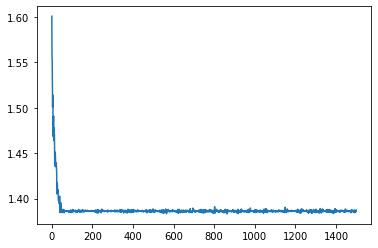

2000
tensor(1.3830, requires_grad=True)
Test Loss:  tensor(1.3867, grad_fn=<DivBackward0>)
Test Time:  0.008106231689453125
5 -fold:  3
(8000, 2)
DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1, out_features=4, bias=True)
      )
    )
    (1): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1, out_features=4, bias=True)
      )
    )
    (2): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
       

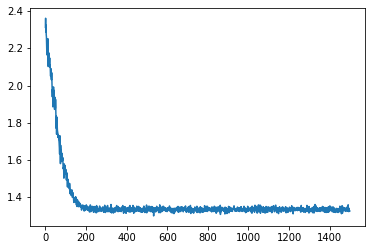

2000
tensor(1.2991, requires_grad=True)
Test Loss:  tensor(1.3328, grad_fn=<DivBackward0>)
Test Time:  0.007781028747558594
5 -fold:  4
(8000, 2)
DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1, out_features=4, bias=True)
      )
    )
    (1): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1, out_features=4, bias=True)
      )
    )
    (2): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
       

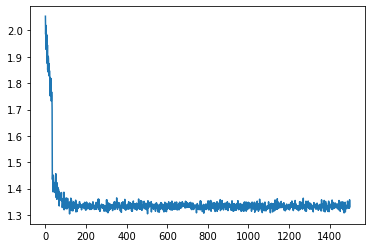

2000
tensor(1.3041, requires_grad=True)
Test Loss:  tensor(1.3445, grad_fn=<DivBackward0>)
Test Time:  0.00814366340637207
5 -fold:  5
(8000, 2)
DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1, out_features=4, bias=True)
      )
    )
    (1): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1, out_features=4, bias=True)
      )
    )
    (2): DiscreteBipartiteFlow(
      (layer): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=1, bias=True)
        

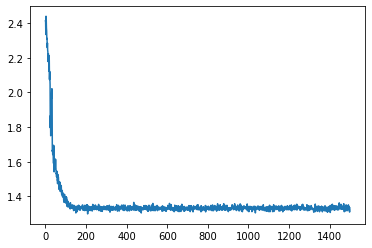

2000
tensor(1.2991, requires_grad=True)
Test Loss:  tensor(1.3385, grad_fn=<DivBackward0>)
Test Time:  0.009414911270141602
Training Minimum Loss:
[array(1.3823802, dtype=float32), array(1.3830496, dtype=float32), array(1.2990825, dtype=float32), array(1.304143, dtype=float32), array(1.2990639, dtype=float32)]
Training Time:
[15.453540802001953, 15.49009895324707, 15.662298679351807, 16.091071605682373, 16.497525453567505]
Average Training Loss:  1.3335438
Std Training Loss:  0.04019123
Average Training Time:  15.838907098770141
Std Training Time:  0.399682352550069
Testing Loss:
[array(1.3869784, dtype=float32), array(1.386652, dtype=float32), array(1.3328013, dtype=float32), array(1.3445243, dtype=float32), array(1.3385168, dtype=float32)]
Testing Time:
[0.009055614471435547, 0.008106231689453125, 0.007781028747558594, 0.00814366340637207, 0.009414911270141602]
Average Testing Loss:  1.3578947
Std Testing Loss:  0.023903094
Average Testing Time:  0.008500289916992188
Std Testing Time

In [26]:
batch_size, sequence_length, vocab_size, k_fold = 1024, 2, 2, 5

num_flows = 4 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'bipartite' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = 10000
orig_probs, coded_data = create_syn_data_paper(alpha=1,k=2,d=2,n_samples=sample_size,rnd_seed=42,manual_prob=True,orig_probs=[1/3,1/6,1/6,1/3],dirchlet_seed=0)
data = dec_to_bin(coded_data,n_features=2,k=2)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type)
      print(model)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp1', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Experiment 2

5 -fold:  1
(8000, 2)
epoch: 0 loss: 1.8290531635284424 min loss: tensor(1.8291, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 1.2418729066848755 min loss: tensor(1.2303, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.235735297203064 min loss: tensor(1.2133, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.2345486879348755 min loss: tensor(1.2077, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.264561653137207 min loss: tensor(1.2077, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.235830545425415 min loss: tensor(1.2077, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.253455638885498 min loss: tensor(1.2077, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.2412408590316772 min loss: tensor(1.2077, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.262920618057251 min loss: tensor(1.2077, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.2683488130569458 min loss: tensor(1.2077, grad_fn=<DivBackward0>)


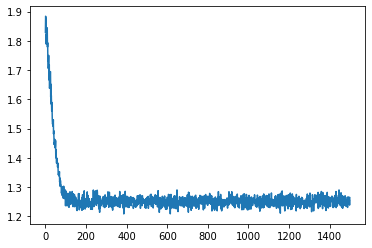

2000
tensor(1.2077, requires_grad=True)
Test Loss:  tensor(1.2661, grad_fn=<DivBackward0>)
Test Time:  0.008395195007324219
5 -fold:  2
(8000, 2)
epoch: 0 loss: 1.761533260345459 min loss: tensor(1.7615, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.3864680528640747 min loss: tensor(1.3834, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.386169195175171 min loss: tensor(1.3834, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.38616144657135 min loss: tensor(1.3834, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.3866167068481445 min loss: tensor(1.3834, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.386884331703186 min loss: tensor(1.3834, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.3862905502319336 min loss: tensor(1.3834, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.387588381767273 min loss: tensor(1.3834, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.3864153623580933 min loss: tensor(1.3834, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.3858695030212402 min loss: tensor(1.3834, grad_fn=<DivBackward0>)


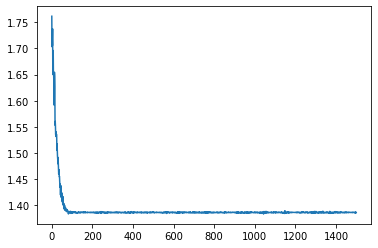

2000
tensor(1.3834, requires_grad=True)
Test Loss:  tensor(1.3874, grad_fn=<DivBackward0>)
Test Time:  0.008576631546020508
5 -fold:  3
(8000, 2)
epoch: 0 loss: 1.9999408721923828 min loss: tensor(1.9999, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.388318657875061 min loss: tensor(1.3881, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.3849296569824219 min loss: tensor(1.3840, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.3869884014129639 min loss: tensor(1.3840, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.3859528303146362 min loss: tensor(1.3840, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.3859623670578003 min loss: tensor(1.3840, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.3855115175247192 min loss: tensor(1.3840, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.3861998319625854 min loss: tensor(1.3840, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.3862632513046265 min loss: tensor(1.3840, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.3855615854263306 min loss: tensor(1.3840, grad_fn=<DivBackward0>)


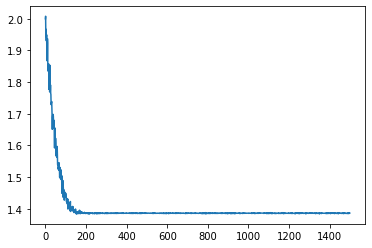

2000
tensor(1.3840, requires_grad=True)
Test Loss:  tensor(1.3910, grad_fn=<DivBackward0>)
Test Time:  0.007786750793457031
5 -fold:  4
(8000, 2)
epoch: 0 loss: 1.5752369165420532 min loss: tensor(1.5752, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.3863099813461304 min loss: tensor(1.3828, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.3862775564193726 min loss: tensor(1.3828, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.3862324953079224 min loss: tensor(1.3828, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.3862767219543457 min loss: tensor(1.3828, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.386457920074463 min loss: tensor(1.3828, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.3863370418548584 min loss: tensor(1.3828, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.3863027095794678 min loss: tensor(1.3828, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.3865880966186523 min loss: tensor(1.3828, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.3858115673065186 min loss: tensor(1.3828, grad_fn=<DivBackward0>)


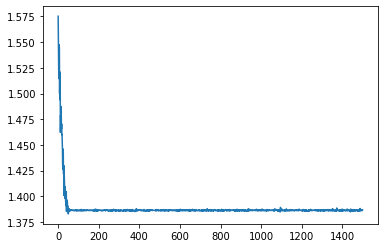

2000
tensor(1.3828, requires_grad=True)
Test Loss:  tensor(1.3856, grad_fn=<DivBackward0>)
Test Time:  0.009385347366333008
5 -fold:  5
(8000, 2)
epoch: 0 loss: 2.1119773387908936 min loss: tensor(2.1120, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.3919687271118164 min loss: tensor(1.3920, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.3859306573867798 min loss: tensor(1.3839, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.3853073120117188 min loss: tensor(1.3839, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.3862197399139404 min loss: tensor(1.3839, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.3861875534057617 min loss: tensor(1.3839, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.3850793838500977 min loss: tensor(1.3839, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.3855704069137573 min loss: tensor(1.3839, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.3865413665771484 min loss: tensor(1.3839, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.386064052581787 min loss: tensor(1.3839, grad_fn=<DivBackward0>)


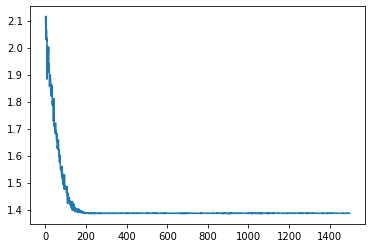

2000
tensor(1.3839, requires_grad=True)
Test Loss:  tensor(1.3858, grad_fn=<DivBackward0>)
Test Time:  0.00858306884765625
Training Minimum Loss:
[array(1.2077472, dtype=float32), array(1.3834473, dtype=float32), array(1.3840264, dtype=float32), array(1.3828126, dtype=float32), array(1.3839189, dtype=float32)]
Training Time:
[16.056452989578247, 15.778305053710938, 15.991981267929077, 15.731508731842041, 16.065346002578735]
Average Training Loss:  1.3483905
Std Training Loss:  0.07032293
Average Training Time:  15.924718809127807
Std Training Time:  0.14171892036059905
Testing Loss:
[array(1.2660909, dtype=float32), array(1.3873882, dtype=float32), array(1.390951, dtype=float32), array(1.3855621, dtype=float32), array(1.3858259, dtype=float32)]
Testing Time:
[0.008395195007324219, 0.008576631546020508, 0.007786750793457031, 0.009385347366333008, 0.00858306884765625]
Average Testing Loss:  1.3631636
Std Testing Loss:  0.048574395
Average Testing Time:  0.008545398712158203
Std Testing T

In [27]:
batch_size, sequence_length, vocab_size, k_fold = 1024, 2, 2, 5

num_flows = 4 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'bipartite' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = 10000
orig_probs, coded_data = create_syn_data_paper(alpha,k=2,d=2,n_samples=10000,rnd_seed=42,manual_prob=True,orig_probs=[1/8,3/8,3/8,1/8],dirchlet_seed=0)
data = dec_to_bin(coded_data,n_features=2,k=2)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp2', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Experiment 3

5 -fold:  1
(8000, 5)
epoch: 0 loss: 9.387247085571289 min loss: tensor(9.3872, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 8.036458969116211 min loss: tensor(8.0304, grad_fn=<DivBackward0>)
epoch: 300 loss: 8.041494369506836 min loss: tensor(8.0264, grad_fn=<DivBackward0>)
epoch: 450 loss: 8.023551940917969 min loss: tensor(8.0236, grad_fn=<DivBackward0>)
epoch: 600 loss: 8.029123306274414 min loss: tensor(8.0180, grad_fn=<DivBackward0>)
epoch: 750 loss: 8.03958797454834 min loss: tensor(8.0180, grad_fn=<DivBackward0>)
epoch: 900 loss: 8.032493591308594 min loss: tensor(8.0180, grad_fn=<DivBackward0>)
epoch: 1050 loss: 8.015800476074219 min loss: tensor(8.0132, grad_fn=<DivBackward0>)
epoch: 1200 loss: 8.027242660522461 min loss: tensor(8.0102, grad_fn=<DivBackward0>)
epoch: 1350 loss: 8.026106834411621 min loss: tensor(8.0091, grad_fn=<DivBackward0>)


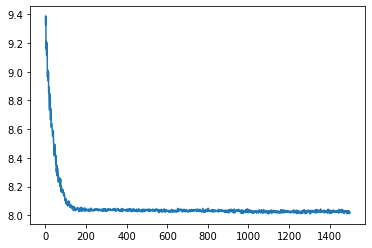

2000
tensor(8.0091, requires_grad=True)
Test Loss:  tensor(8.0327, grad_fn=<DivBackward0>)
Test Time:  0.018608570098876953
5 -fold:  2
(8000, 5)
epoch: 0 loss: 8.966777801513672 min loss: tensor(8.9668, grad_fn=<DivBackward0>)
epoch: 150 loss: 8.048613548278809 min loss: tensor(8.0204, grad_fn=<DivBackward0>)
epoch: 300 loss: 8.030632972717285 min loss: tensor(8.0119, grad_fn=<DivBackward0>)
epoch: 450 loss: 8.028302192687988 min loss: tensor(8.0093, grad_fn=<DivBackward0>)
epoch: 600 loss: 8.026594161987305 min loss: tensor(8.0055, grad_fn=<DivBackward0>)
epoch: 750 loss: 8.027774810791016 min loss: tensor(8.0053, grad_fn=<DivBackward0>)
epoch: 900 loss: 8.013233184814453 min loss: tensor(8.0039, grad_fn=<DivBackward0>)
epoch: 1050 loss: 8.0192232131958 min loss: tensor(7.9970, grad_fn=<DivBackward0>)
epoch: 1200 loss: 8.018653869628906 min loss: tensor(7.9970, grad_fn=<DivBackward0>)
epoch: 1350 loss: 8.0211181640625 min loss: tensor(7.9970, grad_fn=<DivBackward0>)


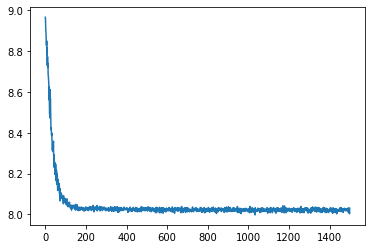

2000
tensor(7.9970, requires_grad=True)
Test Loss:  tensor(8.0383, grad_fn=<DivBackward0>)
Test Time:  0.014673948287963867
5 -fold:  3
(8000, 5)
epoch: 0 loss: 9.844505310058594 min loss: tensor(9.8445, grad_fn=<DivBackward0>)
epoch: 150 loss: 8.0534029006958 min loss: tensor(8.0248, grad_fn=<DivBackward0>)
epoch: 300 loss: 8.031147956848145 min loss: tensor(8.0171, grad_fn=<DivBackward0>)
epoch: 450 loss: 8.034012794494629 min loss: tensor(8.0150, grad_fn=<DivBackward0>)
epoch: 600 loss: 8.03525161743164 min loss: tensor(8.0144, grad_fn=<DivBackward0>)
epoch: 750 loss: 8.026628494262695 min loss: tensor(8.0120, grad_fn=<DivBackward0>)
epoch: 900 loss: 8.03199577331543 min loss: tensor(8.0090, grad_fn=<DivBackward0>)
epoch: 1050 loss: 8.017250061035156 min loss: tensor(8.0060, grad_fn=<DivBackward0>)
epoch: 1200 loss: 8.023931503295898 min loss: tensor(8.0060, grad_fn=<DivBackward0>)
epoch: 1350 loss: 8.020021438598633 min loss: tensor(8.0060, grad_fn=<DivBackward0>)


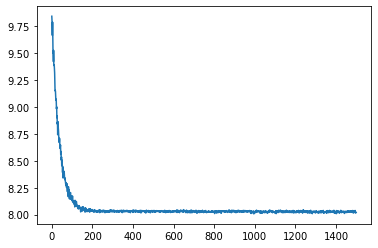

2000
tensor(8.0060, requires_grad=True)
Test Loss:  tensor(8.0479, grad_fn=<DivBackward0>)
Test Time:  0.01674199104309082
5 -fold:  4
(8000, 5)
epoch: 0 loss: 10.382426261901855 min loss: tensor(10.3824, grad_fn=<DivBackward0>)
epoch: 150 loss: 8.292472839355469 min loss: tensor(8.1729, grad_fn=<DivBackward0>)
epoch: 300 loss: 8.061685562133789 min loss: tensor(8.0274, grad_fn=<DivBackward0>)
epoch: 450 loss: 8.054519653320312 min loss: tensor(8.0274, grad_fn=<DivBackward0>)
epoch: 600 loss: 8.04078197479248 min loss: tensor(8.0274, grad_fn=<DivBackward0>)
epoch: 750 loss: 8.04133415222168 min loss: tensor(8.0274, grad_fn=<DivBackward0>)
epoch: 900 loss: 8.039749145507812 min loss: tensor(8.0269, grad_fn=<DivBackward0>)
epoch: 1050 loss: 8.033842086791992 min loss: tensor(8.0244, grad_fn=<DivBackward0>)
epoch: 1200 loss: 8.037514686584473 min loss: tensor(8.0244, grad_fn=<DivBackward0>)
epoch: 1350 loss: 8.034721374511719 min loss: tensor(8.0228, grad_fn=<DivBackward0>)


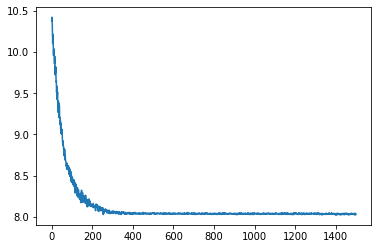

2000
tensor(8.0227, requires_grad=True)
Test Loss:  tensor(8.0398, grad_fn=<DivBackward0>)
Test Time:  0.014936208724975586
5 -fold:  5
(8000, 5)
epoch: 0 loss: 10.142207145690918 min loss: tensor(10.1422, grad_fn=<DivBackward0>)
epoch: 150 loss: 8.076200485229492 min loss: tensor(8.0762, grad_fn=<DivBackward0>)
epoch: 300 loss: 8.022010803222656 min loss: tensor(8.0088, grad_fn=<DivBackward0>)
epoch: 450 loss: 8.03350830078125 min loss: tensor(8.0077, grad_fn=<DivBackward0>)
epoch: 600 loss: 8.019548416137695 min loss: tensor(8.0065, grad_fn=<DivBackward0>)
epoch: 750 loss: 8.023893356323242 min loss: tensor(7.9941, grad_fn=<DivBackward0>)
epoch: 900 loss: 8.028422355651855 min loss: tensor(7.9941, grad_fn=<DivBackward0>)
epoch: 1050 loss: 8.013578414916992 min loss: tensor(7.9941, grad_fn=<DivBackward0>)
epoch: 1200 loss: 8.01806926727295 min loss: tensor(7.9941, grad_fn=<DivBackward0>)
epoch: 1350 loss: 8.020979881286621 min loss: tensor(7.9941, grad_fn=<DivBackward0>)


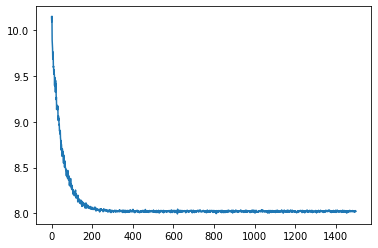

2000
tensor(7.9941, requires_grad=True)
Test Loss:  tensor(8.0349, grad_fn=<DivBackward0>)
Test Time:  0.016333580017089844
Training Minimum Loss:
[array(8.009085, dtype=float32), array(7.997031, dtype=float32), array(8.005962, dtype=float32), array(8.02272, dtype=float32), array(7.994139, dtype=float32)]
Training Time:
[25.357985973358154, 25.121098041534424, 25.448287963867188, 24.888713121414185, 25.005765438079834]
Average Training Loss:  8.005788
Std Training Loss:  0.010099295
Average Training Time:  25.164370107650758
Std Training Time:  0.2102908174452068
Testing Loss:
[array(8.032652, dtype=float32), array(8.038264, dtype=float32), array(8.047893, dtype=float32), array(8.039752, dtype=float32), array(8.03491, dtype=float32)]
Testing Time:
[0.018608570098876953, 0.014673948287963867, 0.01674199104309082, 0.014936208724975586, 0.016333580017089844]
Average Testing Loss:  8.038694
Std Testing Loss:  0.0052295667
Average Testing Time:  0.016258859634399415
Std Testing Time:  0.001

In [28]:
batch_size, sequence_length, vocab_size, k_fold = 1024, 5, 5, 5

num_flows = 4 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'bipartite' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = 10000
orig_probs, coded_data = create_syn_data_paper(alpha,k=vocab_size,d=sequence_length,n_samples=10000,rnd_seed=42,manual_prob=False,orig_probs=None,dirchlet_seed=0)
data = dec_to_bin(coded_data,n_features=sequence_length,k=vocab_size)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp3', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Experiment 4

5 -fold:  1
(8000, 10)
epoch: 0 loss: 21.861831665039062 min loss: tensor(21.8618, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 16.469493865966797 min loss: tensor(16.4431, grad_fn=<DivBackward0>)
epoch: 300 loss: 16.081653594970703 min loss: tensor(16.0689, grad_fn=<DivBackward0>)
epoch: 450 loss: 16.074840545654297 min loss: tensor(16.0613, grad_fn=<DivBackward0>)
epoch: 600 loss: 16.072772979736328 min loss: tensor(16.0605, grad_fn=<DivBackward0>)
epoch: 750 loss: 16.070960998535156 min loss: tensor(16.0605, grad_fn=<DivBackward0>)
epoch: 900 loss: 16.066516876220703 min loss: tensor(16.0605, grad_fn=<DivBackward0>)
epoch: 1050 loss: 16.083526611328125 min loss: tensor(16.0605, grad_fn=<DivBackward0>)
epoch: 1200 loss: 16.079002380371094 min loss: tensor(16.0605, grad_fn=<DivBackward0>)
epoch: 1350 loss: 16.093189239501953 min loss: tensor(16.0605, grad_fn=<DivBackward0>)


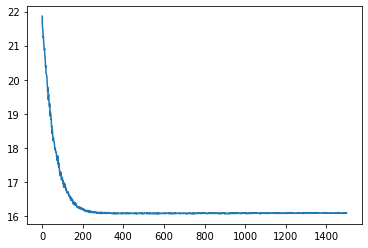

2000
tensor(16.0605, requires_grad=True)
Test Loss:  tensor(16.1181, grad_fn=<DivBackward0>)
Test Time:  0.022141456604003906
5 -fold:  2
(8000, 10)
epoch: 0 loss: 19.835222244262695 min loss: tensor(19.8352, grad_fn=<DivBackward0>)
epoch: 150 loss: 16.215036392211914 min loss: tensor(16.1921, grad_fn=<DivBackward0>)
epoch: 300 loss: 16.059280395507812 min loss: tensor(16.0593, grad_fn=<DivBackward0>)
epoch: 450 loss: 16.070354461669922 min loss: tensor(16.0506, grad_fn=<DivBackward0>)
epoch: 600 loss: 16.07546615600586 min loss: tensor(16.0506, grad_fn=<DivBackward0>)
epoch: 750 loss: 16.07703399658203 min loss: tensor(16.0506, grad_fn=<DivBackward0>)
epoch: 900 loss: 16.076759338378906 min loss: tensor(16.0506, grad_fn=<DivBackward0>)
epoch: 1050 loss: 16.087255477905273 min loss: tensor(16.0506, grad_fn=<DivBackward0>)
epoch: 1200 loss: 16.08812713623047 min loss: tensor(16.0506, grad_fn=<DivBackward0>)
epoch: 1350 loss: 16.090099334716797 min loss: tensor(16.0506, grad_fn=<DivBackw

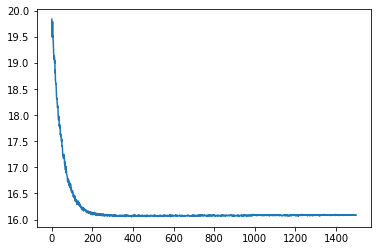

2000
tensor(16.0506, requires_grad=True)
Test Loss:  tensor(16.1143, grad_fn=<DivBackward0>)
Test Time:  0.020444631576538086
5 -fold:  3
(8000, 10)
epoch: 0 loss: 19.599313735961914 min loss: tensor(19.5993, grad_fn=<DivBackward0>)
epoch: 150 loss: 16.166961669921875 min loss: tensor(16.1670, grad_fn=<DivBackward0>)
epoch: 300 loss: 16.07464599609375 min loss: tensor(16.0695, grad_fn=<DivBackward0>)
epoch: 450 loss: 16.082233428955078 min loss: tensor(16.0677, grad_fn=<DivBackward0>)
epoch: 600 loss: 16.072471618652344 min loss: tensor(16.0630, grad_fn=<DivBackward0>)
epoch: 750 loss: 16.08069610595703 min loss: tensor(16.0630, grad_fn=<DivBackward0>)
epoch: 900 loss: 16.083446502685547 min loss: tensor(16.0630, grad_fn=<DivBackward0>)
epoch: 1050 loss: 16.083751678466797 min loss: tensor(16.0630, grad_fn=<DivBackward0>)
epoch: 1200 loss: 16.078481674194336 min loss: tensor(16.0630, grad_fn=<DivBackward0>)
epoch: 1350 loss: 16.082080841064453 min loss: tensor(16.0630, grad_fn=<DivBack

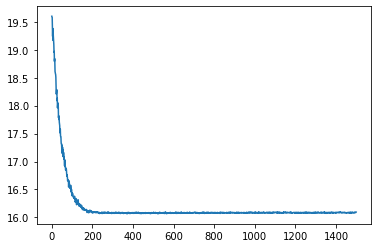

2000
tensor(16.0630, requires_grad=True)
Test Loss:  tensor(16.1071, grad_fn=<DivBackward0>)
Test Time:  0.02066349983215332
5 -fold:  4
(8000, 10)
epoch: 0 loss: 19.079940795898438 min loss: tensor(19.0799, grad_fn=<DivBackward0>)
epoch: 150 loss: 16.115055084228516 min loss: tensor(16.1151, grad_fn=<DivBackward0>)
epoch: 300 loss: 16.07607078552246 min loss: tensor(16.0623, grad_fn=<DivBackward0>)
epoch: 450 loss: 16.074565887451172 min loss: tensor(16.0570, grad_fn=<DivBackward0>)
epoch: 600 loss: 16.07814598083496 min loss: tensor(16.0570, grad_fn=<DivBackward0>)
epoch: 750 loss: 16.081912994384766 min loss: tensor(16.0570, grad_fn=<DivBackward0>)
epoch: 900 loss: 16.077484130859375 min loss: tensor(16.0570, grad_fn=<DivBackward0>)
epoch: 1050 loss: 16.07373046875 min loss: tensor(16.0570, grad_fn=<DivBackward0>)
epoch: 1200 loss: 16.069271087646484 min loss: tensor(16.0570, grad_fn=<DivBackward0>)
epoch: 1350 loss: 16.089969635009766 min loss: tensor(16.0570, grad_fn=<DivBackward0

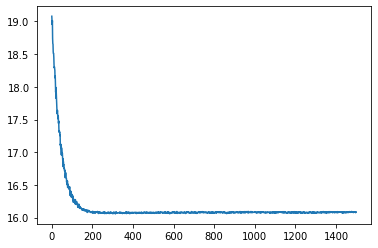

2000
tensor(16.0570, requires_grad=True)
Test Loss:  tensor(16.1153, grad_fn=<DivBackward0>)
Test Time:  0.020849227905273438
5 -fold:  5
(8000, 10)
epoch: 0 loss: 19.22466278076172 min loss: tensor(19.2247, grad_fn=<DivBackward0>)
epoch: 150 loss: 16.116512298583984 min loss: tensor(16.1165, grad_fn=<DivBackward0>)
epoch: 300 loss: 16.071632385253906 min loss: tensor(16.0603, grad_fn=<DivBackward0>)
epoch: 450 loss: 16.07065200805664 min loss: tensor(16.0518, grad_fn=<DivBackward0>)
epoch: 600 loss: 16.06485366821289 min loss: tensor(16.0518, grad_fn=<DivBackward0>)
epoch: 750 loss: 16.07443618774414 min loss: tensor(16.0518, grad_fn=<DivBackward0>)
epoch: 900 loss: 16.083538055419922 min loss: tensor(16.0518, grad_fn=<DivBackward0>)
epoch: 1050 loss: 16.06998062133789 min loss: tensor(16.0518, grad_fn=<DivBackward0>)
epoch: 1200 loss: 16.080842971801758 min loss: tensor(16.0518, grad_fn=<DivBackward0>)
epoch: 1350 loss: 16.07912826538086 min loss: tensor(16.0518, grad_fn=<DivBackward

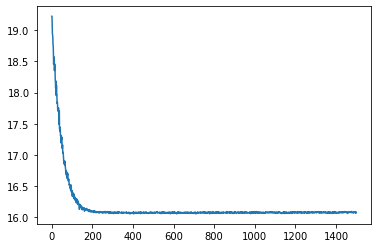

2000
tensor(16.0518, requires_grad=True)
Test Loss:  tensor(16.1263, grad_fn=<DivBackward0>)
Test Time:  0.020853281021118164
Training Minimum Loss:
[array(16.060478, dtype=float32), array(16.050625, dtype=float32), array(16.063038, dtype=float32), array(16.057022, dtype=float32), array(16.051838, dtype=float32)]
Training Time:
[36.515568256378174, 36.82090926170349, 36.509968280792236, 36.56031155586243, 35.75746250152588]
Average Training Loss:  16.0566
Std Training Loss:  0.004796764
Average Training Time:  36.43284397125244
Std Training Time:  0.35658778748036973
Testing Loss:
[array(16.118061, dtype=float32), array(16.11429, dtype=float32), array(16.107132, dtype=float32), array(16.115288, dtype=float32), array(16.126255, dtype=float32)]
Testing Time:
[0.022141456604003906, 0.020444631576538086, 0.02066349983215332, 0.020849227905273438, 0.020853281021118164]
Average Testing Loss:  16.116205
Std Testing Loss:  0.0061850767
Average Testing Time:  0.020990419387817382
Std Testing Ti

In [29]:
batch_size, sequence_length, vocab_size, k_fold = 1024, 10, 5, 5

num_flows = 4 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'bipartite' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = 10000
orig_probs, coded_data = create_syn_data_paper(alpha,k=vocab_size,d=sequence_length,n_samples=10000,rnd_seed=42,manual_prob=False,orig_probs=None,dirchlet_seed=0)
data = dec_to_bin(coded_data,n_features=sequence_length,k=vocab_size)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp4', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Experiment 5

5 -fold:  1
(8000, 5)
epoch: 0 loss: 13.374544143676758 min loss: tensor(13.3745, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 11.546103477478027 min loss: tensor(11.5461, grad_fn=<DivBackward0>)
epoch: 300 loss: 11.503101348876953 min loss: tensor(11.4858, grad_fn=<DivBackward0>)
epoch: 450 loss: 11.49747085571289 min loss: tensor(11.4852, grad_fn=<DivBackward0>)
epoch: 600 loss: 11.507369995117188 min loss: tensor(11.4852, grad_fn=<DivBackward0>)
epoch: 750 loss: 11.500768661499023 min loss: tensor(11.4813, grad_fn=<DivBackward0>)
epoch: 900 loss: 11.501411437988281 min loss: tensor(11.4813, grad_fn=<DivBackward0>)
epoch: 1050 loss: 11.494022369384766 min loss: tensor(11.4813, grad_fn=<DivBackward0>)
epoch: 1200 loss: 11.509437561035156 min loss: tensor(11.4813, grad_fn=<DivBackward0>)
epoch: 1350 loss: 11.494257926940918 min loss: tensor(11.4813, grad_fn=<DivBackward0>)


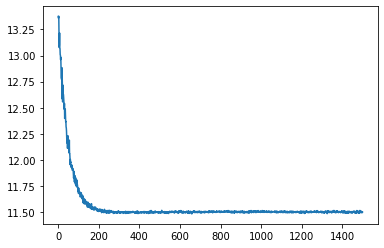

2000
tensor(11.4813, requires_grad=True)
Test Loss:  tensor(11.5255, grad_fn=<DivBackward0>)
Test Time:  0.0179290771484375
5 -fold:  2
(8000, 5)
epoch: 0 loss: 13.75479507446289 min loss: tensor(13.7548, grad_fn=<DivBackward0>)
epoch: 150 loss: 11.597930908203125 min loss: tensor(11.5757, grad_fn=<DivBackward0>)
epoch: 300 loss: 11.48238754272461 min loss: tensor(11.4703, grad_fn=<DivBackward0>)
epoch: 450 loss: 11.489642143249512 min loss: tensor(11.4667, grad_fn=<DivBackward0>)
epoch: 600 loss: 11.484281539916992 min loss: tensor(11.4667, grad_fn=<DivBackward0>)
epoch: 750 loss: 11.498198509216309 min loss: tensor(11.4667, grad_fn=<DivBackward0>)
epoch: 900 loss: 11.488725662231445 min loss: tensor(11.4667, grad_fn=<DivBackward0>)
epoch: 1050 loss: 11.505587577819824 min loss: tensor(11.4586, grad_fn=<DivBackward0>)
epoch: 1200 loss: 11.486244201660156 min loss: tensor(11.4586, grad_fn=<DivBackward0>)
epoch: 1350 loss: 11.496118545532227 min loss: tensor(11.4586, grad_fn=<DivBackwar

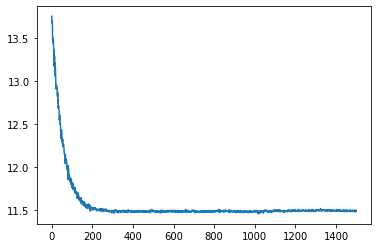

2000
tensor(11.4586, requires_grad=True)
Test Loss:  tensor(11.5461, grad_fn=<DivBackward0>)
Test Time:  0.018994569778442383
5 -fold:  3
(8000, 5)
epoch: 0 loss: 13.372161865234375 min loss: tensor(13.3722, grad_fn=<DivBackward0>)
epoch: 150 loss: 11.581439971923828 min loss: tensor(11.5425, grad_fn=<DivBackward0>)
epoch: 300 loss: 11.500534057617188 min loss: tensor(11.4851, grad_fn=<DivBackward0>)
epoch: 450 loss: 11.508443832397461 min loss: tensor(11.4755, grad_fn=<DivBackward0>)
epoch: 600 loss: 11.497394561767578 min loss: tensor(11.4741, grad_fn=<DivBackward0>)
epoch: 750 loss: 11.493095397949219 min loss: tensor(11.4741, grad_fn=<DivBackward0>)
epoch: 900 loss: 11.496053695678711 min loss: tensor(11.4654, grad_fn=<DivBackward0>)
epoch: 1050 loss: 11.499689102172852 min loss: tensor(11.4654, grad_fn=<DivBackward0>)
epoch: 1200 loss: 11.477256774902344 min loss: tensor(11.4654, grad_fn=<DivBackward0>)
epoch: 1350 loss: 11.487701416015625 min loss: tensor(11.4654, grad_fn=<DivBac

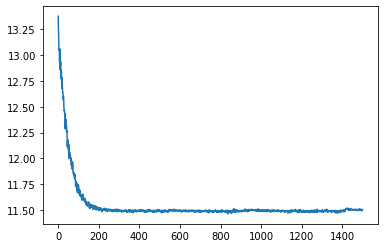

2000
tensor(11.4654, requires_grad=True)
Test Loss:  tensor(11.5385, grad_fn=<DivBackward0>)
Test Time:  0.01508474349975586
5 -fold:  4
(8000, 5)
epoch: 0 loss: 13.70332145690918 min loss: tensor(13.7033, grad_fn=<DivBackward0>)
epoch: 150 loss: 11.639289855957031 min loss: tensor(11.5954, grad_fn=<DivBackward0>)
epoch: 300 loss: 11.497810363769531 min loss: tensor(11.4829, grad_fn=<DivBackward0>)
epoch: 450 loss: 11.488402366638184 min loss: tensor(11.4733, grad_fn=<DivBackward0>)
epoch: 600 loss: 11.485099792480469 min loss: tensor(11.4733, grad_fn=<DivBackward0>)
epoch: 750 loss: 11.494916915893555 min loss: tensor(11.4733, grad_fn=<DivBackward0>)
epoch: 900 loss: 11.480215072631836 min loss: tensor(11.4718, grad_fn=<DivBackward0>)
epoch: 1050 loss: 11.49755859375 min loss: tensor(11.4718, grad_fn=<DivBackward0>)
epoch: 1200 loss: 11.492814064025879 min loss: tensor(11.4718, grad_fn=<DivBackward0>)
epoch: 1350 loss: 11.488250732421875 min loss: tensor(11.4681, grad_fn=<DivBackward0

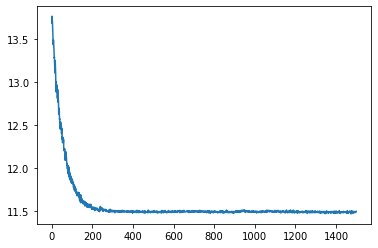

2000
tensor(11.4652, requires_grad=True)
Test Loss:  tensor(11.5392, grad_fn=<DivBackward0>)
Test Time:  0.015682220458984375
5 -fold:  5
(8000, 5)
epoch: 0 loss: 13.311400413513184 min loss: tensor(13.3114, grad_fn=<DivBackward0>)
epoch: 150 loss: 11.639205932617188 min loss: tensor(11.6326, grad_fn=<DivBackward0>)
epoch: 300 loss: 11.517027854919434 min loss: tensor(11.5041, grad_fn=<DivBackward0>)
epoch: 450 loss: 11.507692337036133 min loss: tensor(11.4985, grad_fn=<DivBackward0>)
epoch: 600 loss: 11.502527236938477 min loss: tensor(11.4864, grad_fn=<DivBackward0>)
epoch: 750 loss: 11.498565673828125 min loss: tensor(11.4839, grad_fn=<DivBackward0>)
epoch: 900 loss: 11.498137474060059 min loss: tensor(11.4839, grad_fn=<DivBackward0>)
epoch: 1050 loss: 11.506498336791992 min loss: tensor(11.4814, grad_fn=<DivBackward0>)
epoch: 1200 loss: 11.494421005249023 min loss: tensor(11.4803, grad_fn=<DivBackward0>)
epoch: 1350 loss: 11.501846313476562 min loss: tensor(11.4803, grad_fn=<DivBac

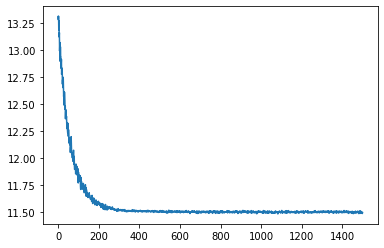

2000
tensor(11.4803, requires_grad=True)
Test Loss:  tensor(11.5379, grad_fn=<DivBackward0>)
Test Time:  0.01876044273376465
Training Minimum Loss:
[array(11.481295, dtype=float32), array(11.458626, dtype=float32), array(11.465441, dtype=float32), array(11.465165, dtype=float32), array(11.480275, dtype=float32)]
Training Time:
[30.15540361404419, 30.35794472694397, 30.465574502944946, 30.563846826553345, 30.941964387893677]
Average Training Loss:  11.47016
Std Training Loss:  0.009017253
Average Training Time:  30.496946811676025
Std Training Time:  0.26056623430397646
Testing Loss:
[array(11.525469, dtype=float32), array(11.546062, dtype=float32), array(11.538473, dtype=float32), array(11.53924, dtype=float32), array(11.537851, dtype=float32)]
Testing Time:
[0.0179290771484375, 0.018994569778442383, 0.01508474349975586, 0.015682220458984375, 0.01876044273376465]
Average Testing Loss:  11.537419
Std Testing Loss:  0.0066652824
Average Testing Time:  0.017290210723876952
Std Testing Tim

In [30]:
batch_size, sequence_length, vocab_size, k_fold = 1024, 5, 10, 5

num_flows = 4 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'bipartite' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = 10000
orig_probs, coded_data = create_syn_data_paper(alpha,k=vocab_size,d=sequence_length,n_samples=10000,rnd_seed=42,manual_prob=False,orig_probs=None,dirchlet_seed=0)
data = dec_to_bin(coded_data,n_features=sequence_length,k=vocab_size)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp5', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

#Synthetic Data Testing Autoregressive

Experiment 1

5 -fold:  1
(8000, 2)
<bound method Module.type of DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=4, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=4, bias=True)
        )
      )
    )
  )
)>
epoch: 0 loss: 1.4925363063812256 min loss: tensor(1.4925, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 1.3342782258987427 min loss: tensor(1.3130, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.336350679397583 min loss: tensor(1.3130, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.352806568145752 min loss: tensor(1.3113, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.3186978101730347 min loss: tensor(1.3111, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.3269884586334229 min loss: tensor(1.3105, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.322307825088501 min loss: tensor(1.3105, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.3275458812713623 min loss: tensor(1.3021, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.3328578472137451 min loss: tensor(1.3021, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.3291488885879517 min loss: tensor(1.3021, grad_fn=<DivBackward0>)


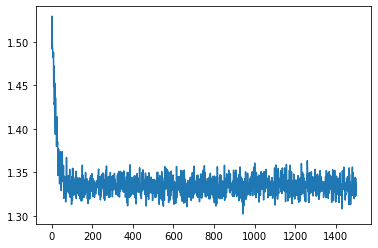

2000
tensor(1.3021, requires_grad=True)
Test Loss:  tensor(1.3309, grad_fn=<DivBackward0>)
Test Time:  0.003949642181396484
5 -fold:  2
(8000, 2)
<bound method Module.type of DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=4, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=4, bias=True)
        )
      )
    )
  )
)>
epoch: 0 loss: 1.9966042041778564 min loss: tensor(1.9966, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.3221975564956665 min loss: tensor(1.3108, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.333254337310791 min loss: tensor(1.3091, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.3320506811141968 min loss: tensor(1.3078, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.3274551630020142 min loss: tensor(1.3078, gra

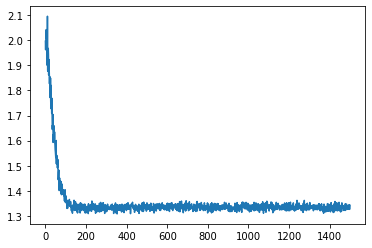

2000
tensor(1.3078, requires_grad=True)
Test Loss:  tensor(1.3294, grad_fn=<DivBackward0>)
Test Time:  0.005648136138916016
5 -fold:  3
(8000, 2)
<bound method Module.type of DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=4, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=4, bias=True)
        )
      )
    )
  )
)>
epoch: 0 loss: 1.531287431716919 min loss: tensor(1.5313, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.3433247804641724 min loss: tensor(1.3160, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.3374664783477783 min loss: tensor(1.3113, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.3526304960250854 min loss: tensor(1.3113, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.3369519710540771 min loss: tensor(1.2996, gra

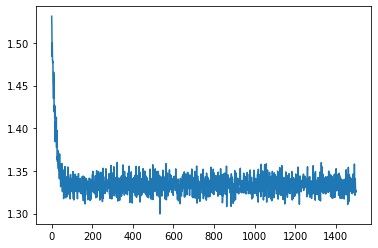

2000
tensor(1.2996, requires_grad=True)
Test Loss:  tensor(1.3328, grad_fn=<DivBackward0>)
Test Time:  0.006087779998779297
5 -fold:  4
(8000, 2)
<bound method Module.type of DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=4, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=4, bias=True)
        )
      )
    )
  )
)>
epoch: 0 loss: 1.656324028968811 min loss: tensor(1.6563, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.3135321140289307 min loss: tensor(1.3069, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.3130450248718262 min loss: tensor(1.3069, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.3224409818649292 min loss: tensor(1.3069, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.3281773328781128 min loss: tensor(1.3050, gra

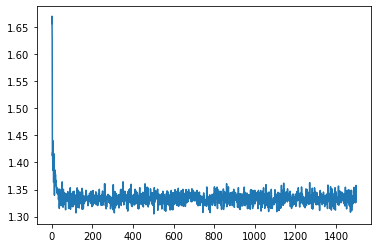

2000
tensor(1.3050, requires_grad=True)
Test Loss:  tensor(1.3374, grad_fn=<DivBackward0>)
Test Time:  0.004678964614868164
5 -fold:  5
(8000, 2)
<bound method Module.type of DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=4, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=4, bias=True)
        )
      )
    )
  )
)>
epoch: 0 loss: 1.4466702938079834 min loss: tensor(1.4467, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.3062467575073242 min loss: tensor(1.3062, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.3330094814300537 min loss: tensor(1.3004, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.345394253730774 min loss: tensor(1.3004, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.3278828859329224 min loss: tensor(1.3004, gra

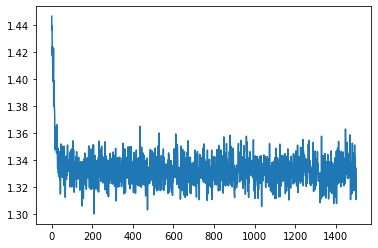

2000
tensor(1.3004, requires_grad=True)
Test Loss:  tensor(1.3384, grad_fn=<DivBackward0>)
Test Time:  0.004920244216918945
Training Minimum Loss:
[array(1.3021097, dtype=float32), array(1.3078415, dtype=float32), array(1.2995778, dtype=float32), array(1.3050305, dtype=float32), array(1.3003751, dtype=float32)]
Training Time:
[6.138439655303955, 6.07955002784729, 6.081016778945923, 6.160541534423828, 6.3284337520599365]
Average Training Loss:  1.3029869
Std Training Loss:  0.0030645179
Average Training Time:  6.1575963497161865
Std Training Time:  0.09112269762243354
Testing Loss:
[array(1.330855, dtype=float32), array(1.3294339, dtype=float32), array(1.3328282, dtype=float32), array(1.3374239, dtype=float32), array(1.3384202, dtype=float32)]
Testing Time:
[0.003949642181396484, 0.005648136138916016, 0.006087779998779297, 0.004678964614868164, 0.004920244216918945]
Average Testing Loss:  1.3337921
Std Testing Loss:  0.0035541074
Average Testing Time:  0.005056953430175782
Std Testing T

In [49]:
batch_size, sequence_length, vocab_size, k_fold = 1024, 2, 2, 5

num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'
hid_lay = 64

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = 10000
orig_probs, coded_data = create_syn_data_paper(alpha=1,k=2,d=2,n_samples=sample_size,rnd_seed=42,manual_prob=True,orig_probs=[1/3,1/6,1/6,1/3],dirchlet_seed=0)
data = dec_to_bin(coded_data,n_features=2,k=2)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type, hid_lay)
      print(model.type)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'auto_exp1', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Experiment 2

5 -fold:  1
(8000, 2)
epoch: 0 loss: 1.3872071504592896 min loss: tensor(1.3872, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 1.2407526969909668 min loss: tensor(1.2165, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.235788106918335 min loss: tensor(1.2132, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.2340412139892578 min loss: tensor(1.2080, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.2636898756027222 min loss: tensor(1.2080, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.2365057468414307 min loss: tensor(1.2080, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.2541029453277588 min loss: tensor(1.2080, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.24154531955719 min loss: tensor(1.2080, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.26326322555542 min loss: tensor(1.2080, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.2673102617263794 min loss: tensor(1.2080, grad_fn=<DivBackward0>)


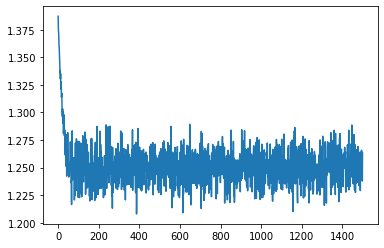

2000
tensor(1.2080, requires_grad=True)
Test Loss:  tensor(1.2670, grad_fn=<DivBackward0>)
Test Time:  0.00491023063659668
5 -fold:  2
(8000, 2)
epoch: 0 loss: 2.367440938949585 min loss: tensor(2.3674, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.2915226221084595 min loss: tensor(1.2666, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.2199976444244385 min loss: tensor(1.2014, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.2707176208496094 min loss: tensor(1.2014, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.2484005689620972 min loss: tensor(1.1997, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.2559577226638794 min loss: tensor(1.1997, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.26995849609375 min loss: tensor(1.1997, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.2368080615997314 min loss: tensor(1.1997, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.2547292709350586 min loss: tensor(1.1997, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.2585701942443848 min loss: tensor(1.1997, grad_fn=<DivBackward0>)


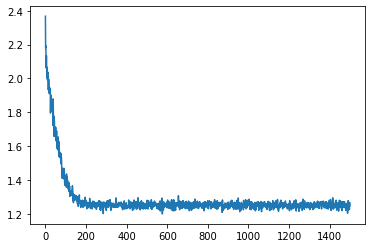

2000
tensor(1.1997, requires_grad=True)
Test Loss:  tensor(1.2564, grad_fn=<DivBackward0>)
Test Time:  0.0047338008880615234
5 -fold:  3
(8000, 2)
epoch: 0 loss: 1.5032793283462524 min loss: tensor(1.5033, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.2461926937103271 min loss: tensor(1.2107, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.239804983139038 min loss: tensor(1.2107, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.2333940267562866 min loss: tensor(1.2107, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.2476253509521484 min loss: tensor(1.2107, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.245139479637146 min loss: tensor(1.2107, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.2559758424758911 min loss: tensor(1.2107, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.2544018030166626 min loss: tensor(1.1989, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.2469826936721802 min loss: tensor(1.1989, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.2308123111724854 min loss: tensor(1.1989, grad_fn=<DivBackward0>)


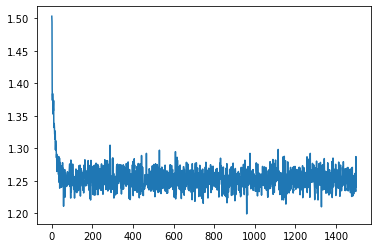

2000
tensor(1.1989, requires_grad=True)
Test Loss:  tensor(1.2510, grad_fn=<DivBackward0>)
Test Time:  0.006563425064086914
5 -fold:  4
(8000, 2)
epoch: 0 loss: 2.215013027191162 min loss: tensor(2.2150, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.264503002166748 min loss: tensor(1.2190, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.2522000074386597 min loss: tensor(1.2135, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.2383910417556763 min loss: tensor(1.2099, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.2599105834960938 min loss: tensor(1.2064, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.2392890453338623 min loss: tensor(1.2064, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.2674130201339722 min loss: tensor(1.2064, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.2554564476013184 min loss: tensor(1.2064, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.2567265033721924 min loss: tensor(1.2064, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.2573797702789307 min loss: tensor(1.2064, grad_fn=<DivBackward0>)


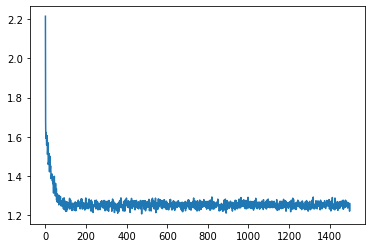

2000
tensor(1.2064, requires_grad=True)
Test Loss:  tensor(1.2581, grad_fn=<DivBackward0>)
Test Time:  0.0041692256927490234
5 -fold:  5
(8000, 2)
epoch: 0 loss: 1.7203266620635986 min loss: tensor(1.7203, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.2625750303268433 min loss: tensor(1.2395, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.264585256576538 min loss: tensor(1.2139, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.2281241416931152 min loss: tensor(1.2139, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.274034023284912 min loss: tensor(1.2139, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.2721643447875977 min loss: tensor(1.2139, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.266920566558838 min loss: tensor(1.2139, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.253440260887146 min loss: tensor(1.2139, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.2676403522491455 min loss: tensor(1.2139, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.259339690208435 min loss: tensor(1.2139, grad_fn=<DivBackward0>)


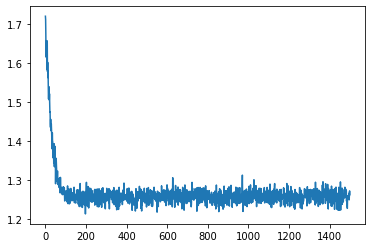

2000
tensor(1.2139, requires_grad=True)
Test Loss:  tensor(1.2313, grad_fn=<DivBackward0>)
Test Time:  0.00468754768371582
Training Minimum Loss:
[array(1.2079585, dtype=float32), array(1.1997405, dtype=float32), array(1.1988789, dtype=float32), array(1.2063513, dtype=float32), array(1.2139149, dtype=float32)]
Training Time:
[6.12027645111084, 6.200798749923706, 6.337179899215698, 6.412626504898071, 6.370754957199097]
Average Training Loss:  1.2053688
Std Training Loss:  0.005558838
Average Training Time:  6.288327312469482
Std Training Time:  0.11003047064388936
Testing Loss:
[array(1.2670252, dtype=float32), array(1.2563651, dtype=float32), array(1.2510394, dtype=float32), array(1.2580546, dtype=float32), array(1.2312783, dtype=float32)]
Testing Time:
[0.00491023063659668, 0.0047338008880615234, 0.006563425064086914, 0.0041692256927490234, 0.00468754768371582]
Average Testing Loss:  1.2527525
Std Testing Loss:  0.01190756
Average Testing Time:  0.0050128459930419925
Std Testing Time:

In [50]:
batch_size, sequence_length, vocab_size, k_fold = 1024, 2, 2, 5

num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'
hid_lay = 64

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = 10000
orig_probs, coded_data = create_syn_data_paper(alpha,k=2,d=2,n_samples=10000,rnd_seed=42,manual_prob=True,orig_probs=[1/8,3/8,3/8,1/8],dirchlet_seed=0)
data = dec_to_bin(coded_data,n_features=2,k=2)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type, hid_lay)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'auto_exp2', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Experiment 3

5 -fold:  1
(8000, 5)
epoch: 0 loss: 9.938915252685547 min loss: tensor(9.9389, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 8.076459884643555 min loss: tensor(8.0765, grad_fn=<DivBackward0>)
epoch: 300 loss: 8.027705192565918 min loss: tensor(7.9954, grad_fn=<DivBackward0>)
epoch: 450 loss: 8.005264282226562 min loss: tensor(7.9839, grad_fn=<DivBackward0>)
epoch: 600 loss: 8.004768371582031 min loss: tensor(7.9806, grad_fn=<DivBackward0>)
epoch: 750 loss: 8.009256362915039 min loss: tensor(7.9806, grad_fn=<DivBackward0>)
epoch: 900 loss: 7.981673240661621 min loss: tensor(7.9806, grad_fn=<DivBackward0>)
epoch: 1050 loss: 7.99213981628418 min loss: tensor(7.9806, grad_fn=<DivBackward0>)
epoch: 1200 loss: 7.998023509979248 min loss: tensor(7.9806, grad_fn=<DivBackward0>)
epoch: 1350 loss: 8.003589630126953 min loss: tensor(7.9806, grad_fn=<DivBackward0>)


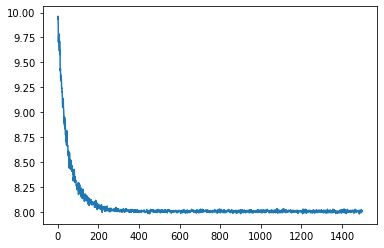

2000
tensor(7.9791, requires_grad=True)
Test Loss:  tensor(8.0349, grad_fn=<DivBackward0>)
Test Time:  0.00766301155090332
5 -fold:  2
(8000, 5)
epoch: 0 loss: 10.71904182434082 min loss: tensor(10.7190, grad_fn=<DivBackward0>)
epoch: 150 loss: 8.18455696105957 min loss: tensor(8.1748, grad_fn=<DivBackward0>)
epoch: 300 loss: 7.999847412109375 min loss: tensor(7.9832, grad_fn=<DivBackward0>)
epoch: 450 loss: 8.002182006835938 min loss: tensor(7.9673, grad_fn=<DivBackward0>)
epoch: 600 loss: 7.977751731872559 min loss: tensor(7.9611, grad_fn=<DivBackward0>)
epoch: 750 loss: 8.011354446411133 min loss: tensor(7.9611, grad_fn=<DivBackward0>)
epoch: 900 loss: 7.970110893249512 min loss: tensor(7.9588, grad_fn=<DivBackward0>)
epoch: 1050 loss: 8.00412654876709 min loss: tensor(7.9561, grad_fn=<DivBackward0>)
epoch: 1200 loss: 7.969882011413574 min loss: tensor(7.9561, grad_fn=<DivBackward0>)
epoch: 1350 loss: 7.987042427062988 min loss: tensor(7.9561, grad_fn=<DivBackward0>)


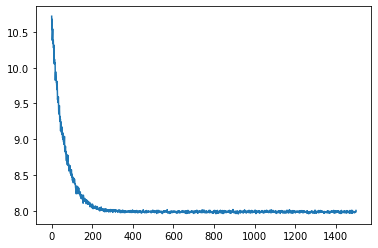

2000
tensor(7.9561, requires_grad=True)
Test Loss:  tensor(8.0170, grad_fn=<DivBackward0>)
Test Time:  0.005645751953125
5 -fold:  3
(8000, 5)
epoch: 0 loss: 9.043109893798828 min loss: tensor(9.0431, grad_fn=<DivBackward0>)
epoch: 150 loss: 7.999762535095215 min loss: tensor(7.9869, grad_fn=<DivBackward0>)
epoch: 300 loss: 7.994316101074219 min loss: tensor(7.9811, grad_fn=<DivBackward0>)
epoch: 450 loss: 8.003949165344238 min loss: tensor(7.9727, grad_fn=<DivBackward0>)
epoch: 600 loss: 7.984270095825195 min loss: tensor(7.9716, grad_fn=<DivBackward0>)
epoch: 750 loss: 7.993699550628662 min loss: tensor(7.9716, grad_fn=<DivBackward0>)
epoch: 900 loss: 7.995857238769531 min loss: tensor(7.9657, grad_fn=<DivBackward0>)
epoch: 1050 loss: 7.984943866729736 min loss: tensor(7.9638, grad_fn=<DivBackward0>)
epoch: 1200 loss: 7.984281539916992 min loss: tensor(7.9625, grad_fn=<DivBackward0>)
epoch: 1350 loss: 7.982707500457764 min loss: tensor(7.9625, grad_fn=<DivBackward0>)


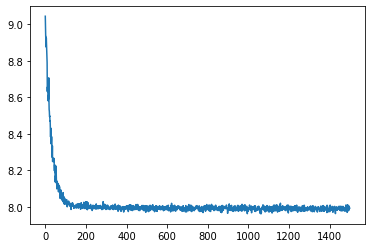

2000
tensor(7.9625, requires_grad=True)
Test Loss:  tensor(8.0175, grad_fn=<DivBackward0>)
Test Time:  0.0065615177154541016
5 -fold:  4
(8000, 5)
epoch: 0 loss: 10.615510940551758 min loss: tensor(10.6155, grad_fn=<DivBackward0>)
epoch: 150 loss: 8.153922080993652 min loss: tensor(8.0860, grad_fn=<DivBackward0>)
epoch: 300 loss: 7.985540390014648 min loss: tensor(7.9776, grad_fn=<DivBackward0>)
epoch: 450 loss: 8.015549659729004 min loss: tensor(7.9770, grad_fn=<DivBackward0>)
epoch: 600 loss: 7.995266914367676 min loss: tensor(7.9655, grad_fn=<DivBackward0>)
epoch: 750 loss: 8.004133224487305 min loss: tensor(7.9655, grad_fn=<DivBackward0>)
epoch: 900 loss: 8.0055513381958 min loss: tensor(7.9655, grad_fn=<DivBackward0>)
epoch: 1050 loss: 8.014399528503418 min loss: tensor(7.9655, grad_fn=<DivBackward0>)
epoch: 1200 loss: 8.000052452087402 min loss: tensor(7.9655, grad_fn=<DivBackward0>)
epoch: 1350 loss: 7.990328311920166 min loss: tensor(7.9655, grad_fn=<DivBackward0>)


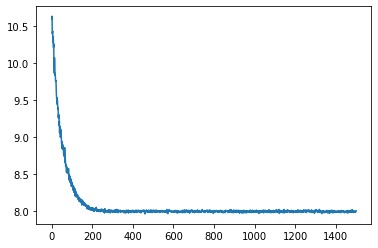

2000
tensor(7.9655, requires_grad=True)
Test Loss:  tensor(8.0072, grad_fn=<DivBackward0>)
Test Time:  0.007430315017700195
5 -fold:  5
(8000, 5)
epoch: 0 loss: 10.247477531433105 min loss: tensor(10.2475, grad_fn=<DivBackward0>)
epoch: 150 loss: 8.040433883666992 min loss: tensor(8.0059, grad_fn=<DivBackward0>)
epoch: 300 loss: 7.987249851226807 min loss: tensor(7.9563, grad_fn=<DivBackward0>)
epoch: 450 loss: 7.987940311431885 min loss: tensor(7.9541, grad_fn=<DivBackward0>)
epoch: 600 loss: 7.988629341125488 min loss: tensor(7.9460, grad_fn=<DivBackward0>)
epoch: 750 loss: 7.999538421630859 min loss: tensor(7.9460, grad_fn=<DivBackward0>)
epoch: 900 loss: 7.991373538970947 min loss: tensor(7.9460, grad_fn=<DivBackward0>)
epoch: 1050 loss: 7.967126846313477 min loss: tensor(7.9460, grad_fn=<DivBackward0>)
epoch: 1200 loss: 7.973163604736328 min loss: tensor(7.9460, grad_fn=<DivBackward0>)
epoch: 1350 loss: 7.971312999725342 min loss: tensor(7.9444, grad_fn=<DivBackward0>)


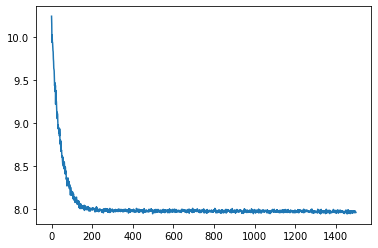

2000
tensor(7.9444, requires_grad=True)
Test Loss:  tensor(8.0166, grad_fn=<DivBackward0>)
Test Time:  0.007626533508300781
Training Minimum Loss:
[array(7.979111, dtype=float32), array(7.956109, dtype=float32), array(7.9625387, dtype=float32), array(7.965481, dtype=float32), array(7.9443974, dtype=float32)]
Training Time:
[9.624183893203735, 9.729197978973389, 9.616289615631104, 9.300372123718262, 9.189396142959595]
Average Training Loss:  7.9615273
Std Training Loss:  0.011389783
Average Training Time:  9.491887950897217
Std Training Time:  0.20855389993680584
Testing Loss:
[array(8.03494, dtype=float32), array(8.017026, dtype=float32), array(8.017466, dtype=float32), array(8.00716, dtype=float32), array(8.016626, dtype=float32)]
Testing Time:
[0.00766301155090332, 0.005645751953125, 0.0065615177154541016, 0.007430315017700195, 0.007626533508300781]
Average Testing Loss:  8.018643
Std Testing Loss:  0.009005638
Average Testing Time:  0.00698542594909668
Std Testing Time:  0.000780063

In [51]:
batch_size, sequence_length, vocab_size, k_fold = 1024, 5, 5, 5

num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'
hid_lay = 64

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = 10000
orig_probs, coded_data = create_syn_data_paper(alpha,k=vocab_size,d=sequence_length,n_samples=10000,rnd_seed=42,manual_prob=False,orig_probs=None,dirchlet_seed=0)
data = dec_to_bin(coded_data,n_features=sequence_length,k=vocab_size)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type, hid_lay)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'auto_exp3', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Experiment 4

5 -fold:  1
(8000, 10)
epoch: 0 loss: 19.381818771362305 min loss: tensor(19.3818, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 16.230148315429688 min loss: tensor(16.1558, grad_fn=<DivBackward0>)
epoch: 300 loss: 16.040618896484375 min loss: tensor(16.0052, grad_fn=<DivBackward0>)
epoch: 450 loss: 16.01238250732422 min loss: tensor(15.9791, grad_fn=<DivBackward0>)
epoch: 600 loss: 15.994889259338379 min loss: tensor(15.9636, grad_fn=<DivBackward0>)
epoch: 750 loss: 15.968870162963867 min loss: tensor(15.9445, grad_fn=<DivBackward0>)
epoch: 900 loss: 15.963770866394043 min loss: tensor(15.9445, grad_fn=<DivBackward0>)
epoch: 1050 loss: 15.964526176452637 min loss: tensor(15.9302, grad_fn=<DivBackward0>)
epoch: 1200 loss: 15.981735229492188 min loss: tensor(15.9249, grad_fn=<DivBackward0>)
epoch: 1350 loss: 15.955472946166992 min loss: tensor(15.8936, grad_fn=<DivBackward0>)


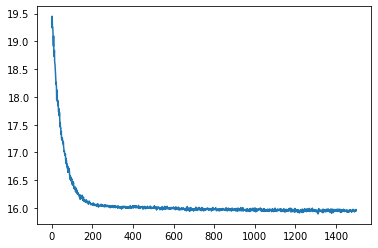

2000
tensor(15.8936, requires_grad=True)
Test Loss:  tensor(16.2062, grad_fn=<DivBackward0>)
Test Time:  0.012813329696655273
5 -fold:  2
(8000, 10)
epoch: 0 loss: 19.745574951171875 min loss: tensor(19.7456, grad_fn=<DivBackward0>)
epoch: 150 loss: 16.174686431884766 min loss: tensor(16.1747, grad_fn=<DivBackward0>)
epoch: 300 loss: 16.046001434326172 min loss: tensor(16.0199, grad_fn=<DivBackward0>)
epoch: 450 loss: 16.007474899291992 min loss: tensor(15.9982, grad_fn=<DivBackward0>)
epoch: 600 loss: 16.01374626159668 min loss: tensor(15.9815, grad_fn=<DivBackward0>)
epoch: 750 loss: 16.004276275634766 min loss: tensor(15.9725, grad_fn=<DivBackward0>)
epoch: 900 loss: 15.986451148986816 min loss: tensor(15.9609, grad_fn=<DivBackward0>)
epoch: 1050 loss: 15.993258476257324 min loss: tensor(15.9556, grad_fn=<DivBackward0>)
epoch: 1200 loss: 15.970403671264648 min loss: tensor(15.9461, grad_fn=<DivBackward0>)
epoch: 1350 loss: 15.964988708496094 min loss: tensor(15.9405, grad_fn=<DivBac

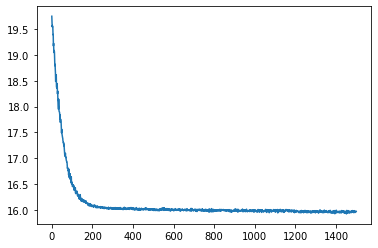

2000
tensor(15.9263, requires_grad=True)
Test Loss:  tensor(16.1984, grad_fn=<DivBackward0>)
Test Time:  0.013863086700439453
5 -fold:  3
(8000, 10)
epoch: 0 loss: 19.68082046508789 min loss: tensor(19.6808, grad_fn=<DivBackward0>)
epoch: 150 loss: 16.151762008666992 min loss: tensor(16.1518, grad_fn=<DivBackward0>)
epoch: 300 loss: 16.000720977783203 min loss: tensor(15.9988, grad_fn=<DivBackward0>)
epoch: 450 loss: 16.003164291381836 min loss: tensor(15.9722, grad_fn=<DivBackward0>)
epoch: 600 loss: 15.983933448791504 min loss: tensor(15.9524, grad_fn=<DivBackward0>)
epoch: 750 loss: 15.985098838806152 min loss: tensor(15.9279, grad_fn=<DivBackward0>)
epoch: 900 loss: 15.973654747009277 min loss: tensor(15.9279, grad_fn=<DivBackward0>)
epoch: 1050 loss: 15.972221374511719 min loss: tensor(15.9233, grad_fn=<DivBackward0>)
epoch: 1200 loss: 15.976059913635254 min loss: tensor(15.9172, grad_fn=<DivBackward0>)
epoch: 1350 loss: 15.955053329467773 min loss: tensor(15.8970, grad_fn=<DivBac

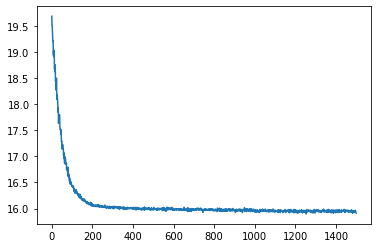

2000
tensor(15.8970, requires_grad=True)
Test Loss:  tensor(16.2564, grad_fn=<DivBackward0>)
Test Time:  0.011046648025512695
5 -fold:  4
(8000, 10)
epoch: 0 loss: 19.603252410888672 min loss: tensor(19.6033, grad_fn=<DivBackward0>)
epoch: 150 loss: 16.183109283447266 min loss: tensor(16.1732, grad_fn=<DivBackward0>)
epoch: 300 loss: 16.041648864746094 min loss: tensor(16.0361, grad_fn=<DivBackward0>)
epoch: 450 loss: 16.055343627929688 min loss: tensor(16.0162, grad_fn=<DivBackward0>)
epoch: 600 loss: 16.03725242614746 min loss: tensor(15.9983, grad_fn=<DivBackward0>)
epoch: 750 loss: 16.022125244140625 min loss: tensor(15.9833, grad_fn=<DivBackward0>)
epoch: 900 loss: 15.988519668579102 min loss: tensor(15.9687, grad_fn=<DivBackward0>)
epoch: 1050 loss: 15.98997688293457 min loss: tensor(15.9687, grad_fn=<DivBackward0>)
epoch: 1200 loss: 15.954683303833008 min loss: tensor(15.9386, grad_fn=<DivBackward0>)
epoch: 1350 loss: 15.983560562133789 min loss: tensor(15.9386, grad_fn=<DivBack

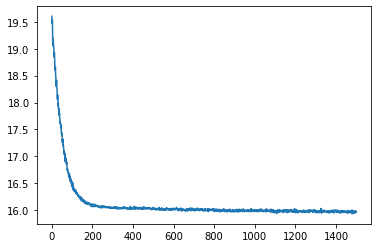

2000
tensor(15.9319, requires_grad=True)
Test Loss:  tensor(16.2354, grad_fn=<DivBackward0>)
Test Time:  0.012188196182250977
5 -fold:  5
(8000, 10)
epoch: 0 loss: 18.47909164428711 min loss: tensor(18.4791, grad_fn=<DivBackward0>)
epoch: 150 loss: 16.14263153076172 min loss: tensor(16.1207, grad_fn=<DivBackward0>)
epoch: 300 loss: 16.042295455932617 min loss: tensor(16.0297, grad_fn=<DivBackward0>)
epoch: 450 loss: 16.0499210357666 min loss: tensor(16.0137, grad_fn=<DivBackward0>)
epoch: 600 loss: 16.033267974853516 min loss: tensor(15.9956, grad_fn=<DivBackward0>)
epoch: 750 loss: 16.024232864379883 min loss: tensor(15.9956, grad_fn=<DivBackward0>)
epoch: 900 loss: 16.039016723632812 min loss: tensor(15.9893, grad_fn=<DivBackward0>)
epoch: 1050 loss: 15.988636016845703 min loss: tensor(15.9682, grad_fn=<DivBackward0>)
epoch: 1200 loss: 16.0082950592041 min loss: tensor(15.9639, grad_fn=<DivBackward0>)
epoch: 1350 loss: 15.949461936950684 min loss: tensor(15.9495, grad_fn=<DivBackward

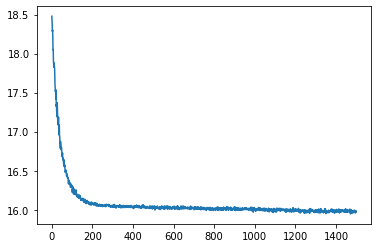

2000
tensor(15.9458, requires_grad=True)
Test Loss:  tensor(16.2085, grad_fn=<DivBackward0>)
Test Time:  0.012286901473999023
Training Minimum Loss:
[array(15.893587, dtype=float32), array(15.926321, dtype=float32), array(15.89702, dtype=float32), array(15.931913, dtype=float32), array(15.945841, dtype=float32)]
Training Time:
[13.7214834690094, 13.843828916549683, 13.657238245010376, 13.741521835327148, 13.512879371643066]
Average Training Loss:  15.918936
Std Training Loss:  0.020345433
Average Training Time:  13.695390367507935
Std Training Time:  0.10918682445551293
Testing Loss:
[array(16.206175, dtype=float32), array(16.1984, dtype=float32), array(16.256426, dtype=float32), array(16.235397, dtype=float32), array(16.208525, dtype=float32)]
Testing Time:
[0.012813329696655273, 0.013863086700439453, 0.011046648025512695, 0.012188196182250977, 0.012286901473999023]
Average Testing Loss:  16.220985
Std Testing Loss:  0.021672236
Average Testing Time:  0.012439632415771484
Std Testing 

In [53]:
batch_size, sequence_length, vocab_size, k_fold = 1024, 10, 5, 5

num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'
hid_lay = 64

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = 10000
orig_probs, coded_data = create_syn_data_paper(alpha,k=vocab_size,d=sequence_length,n_samples=10000,rnd_seed=42,manual_prob=False,orig_probs=None,dirchlet_seed=0)
data = dec_to_bin(coded_data,n_features=sequence_length,k=vocab_size)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type, hid_lay)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'auto_exp4', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Experiment 5

5 -fold:  1
(8000, 5)
epoch: 0 loss: 13.710240364074707 min loss: tensor(13.7102, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 11.55523681640625 min loss: tensor(11.5552, grad_fn=<DivBackward0>)
epoch: 300 loss: 11.481729507446289 min loss: tensor(11.4628, grad_fn=<DivBackward0>)
epoch: 450 loss: 11.471779823303223 min loss: tensor(11.4487, grad_fn=<DivBackward0>)
epoch: 600 loss: 11.459803581237793 min loss: tensor(11.4461, grad_fn=<DivBackward0>)
epoch: 750 loss: 11.459765434265137 min loss: tensor(11.4451, grad_fn=<DivBackward0>)
epoch: 900 loss: 11.470600128173828 min loss: tensor(11.4301, grad_fn=<DivBackward0>)
epoch: 1050 loss: 11.451951026916504 min loss: tensor(11.4245, grad_fn=<DivBackward0>)
epoch: 1200 loss: 11.459599494934082 min loss: tensor(11.4245, grad_fn=<DivBackward0>)
epoch: 1350 loss: 11.458847999572754 min loss: tensor(11.4184, grad_fn=<DivBackward0>)


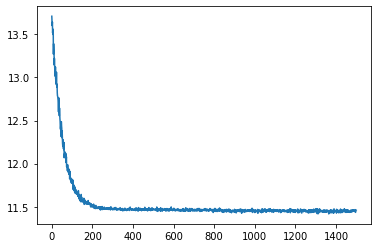

2000
tensor(11.4168, requires_grad=True)
Test Loss:  tensor(11.5695, grad_fn=<DivBackward0>)
Test Time:  0.011505842208862305
5 -fold:  2
(8000, 5)
epoch: 0 loss: 13.41075611114502 min loss: tensor(13.4108, grad_fn=<DivBackward0>)
epoch: 150 loss: 11.561482429504395 min loss: tensor(11.5394, grad_fn=<DivBackward0>)
epoch: 300 loss: 11.487699508666992 min loss: tensor(11.4560, grad_fn=<DivBackward0>)
epoch: 450 loss: 11.461003303527832 min loss: tensor(11.4480, grad_fn=<DivBackward0>)
epoch: 600 loss: 11.45760726928711 min loss: tensor(11.4480, grad_fn=<DivBackward0>)
epoch: 750 loss: 11.472339630126953 min loss: tensor(11.4446, grad_fn=<DivBackward0>)
epoch: 900 loss: 11.452552795410156 min loss: tensor(11.4357, grad_fn=<DivBackward0>)
epoch: 1050 loss: 11.45146369934082 min loss: tensor(11.4343, grad_fn=<DivBackward0>)
epoch: 1200 loss: 11.459617614746094 min loss: tensor(11.4299, grad_fn=<DivBackward0>)
epoch: 1350 loss: 11.439446449279785 min loss: tensor(11.4299, grad_fn=<DivBackwa

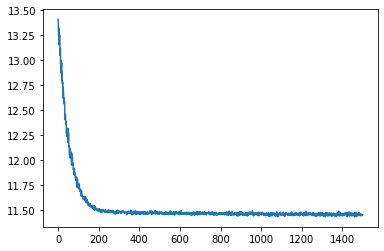

2000
tensor(11.4277, requires_grad=True)
Test Loss:  tensor(11.5712, grad_fn=<DivBackward0>)
Test Time:  0.00900888442993164
5 -fold:  3
(8000, 5)
epoch: 0 loss: 14.258983612060547 min loss: tensor(14.2590, grad_fn=<DivBackward0>)
epoch: 150 loss: 11.618717193603516 min loss: tensor(11.5907, grad_fn=<DivBackward0>)
epoch: 300 loss: 11.469791412353516 min loss: tensor(11.4315, grad_fn=<DivBackward0>)
epoch: 450 loss: 11.458362579345703 min loss: tensor(11.4314, grad_fn=<DivBackward0>)
epoch: 600 loss: 11.460878372192383 min loss: tensor(11.4179, grad_fn=<DivBackward0>)
epoch: 750 loss: 11.447844505310059 min loss: tensor(11.4147, grad_fn=<DivBackward0>)
epoch: 900 loss: 11.463775634765625 min loss: tensor(11.4136, grad_fn=<DivBackward0>)
epoch: 1050 loss: 11.428157806396484 min loss: tensor(11.4076, grad_fn=<DivBackward0>)
epoch: 1200 loss: 11.428272247314453 min loss: tensor(11.4044, grad_fn=<DivBackward0>)
epoch: 1350 loss: 11.415810585021973 min loss: tensor(11.4011, grad_fn=<DivBack

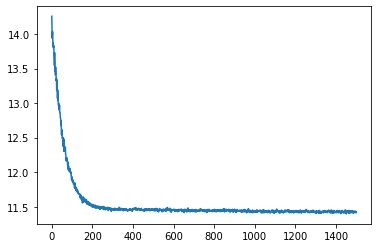

2000
tensor(11.3949, requires_grad=True)
Test Loss:  tensor(11.5721, grad_fn=<DivBackward0>)
Test Time:  0.008051872253417969
5 -fold:  4
(8000, 5)
epoch: 0 loss: 13.264579772949219 min loss: tensor(13.2646, grad_fn=<DivBackward0>)
epoch: 150 loss: 11.549291610717773 min loss: tensor(11.5086, grad_fn=<DivBackward0>)
epoch: 300 loss: 11.461790084838867 min loss: tensor(11.4458, grad_fn=<DivBackward0>)
epoch: 450 loss: 11.446718215942383 min loss: tensor(11.4260, grad_fn=<DivBackward0>)
epoch: 600 loss: 11.452987670898438 min loss: tensor(11.4244, grad_fn=<DivBackward0>)
epoch: 750 loss: 11.44582748413086 min loss: tensor(11.4179, grad_fn=<DivBackward0>)
epoch: 900 loss: 11.439623832702637 min loss: tensor(11.4056, grad_fn=<DivBackward0>)
epoch: 1050 loss: 11.398109436035156 min loss: tensor(11.3981, grad_fn=<DivBackward0>)
epoch: 1200 loss: 11.423822402954102 min loss: tensor(11.3925, grad_fn=<DivBackward0>)
epoch: 1350 loss: 11.420614242553711 min loss: tensor(11.3915, grad_fn=<DivBack

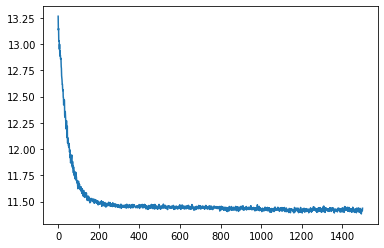

2000
tensor(11.3830, requires_grad=True)
Test Loss:  tensor(11.6133, grad_fn=<DivBackward0>)
Test Time:  0.008144617080688477
5 -fold:  5
(8000, 5)
epoch: 0 loss: 12.977746963500977 min loss: tensor(12.9777, grad_fn=<DivBackward0>)
epoch: 150 loss: 11.525219917297363 min loss: tensor(11.4901, grad_fn=<DivBackward0>)
epoch: 300 loss: 11.47487735748291 min loss: tensor(11.4554, grad_fn=<DivBackward0>)
epoch: 450 loss: 11.489383697509766 min loss: tensor(11.4554, grad_fn=<DivBackward0>)
epoch: 600 loss: 11.474101066589355 min loss: tensor(11.4540, grad_fn=<DivBackward0>)
epoch: 750 loss: 11.474892616271973 min loss: tensor(11.4515, grad_fn=<DivBackward0>)
epoch: 900 loss: 11.47007942199707 min loss: tensor(11.4512, grad_fn=<DivBackward0>)
epoch: 1050 loss: 11.469482421875 min loss: tensor(11.4485, grad_fn=<DivBackward0>)
epoch: 1200 loss: 11.483084678649902 min loss: tensor(11.4469, grad_fn=<DivBackward0>)
epoch: 1350 loss: 11.472784996032715 min loss: tensor(11.4352, grad_fn=<DivBackward

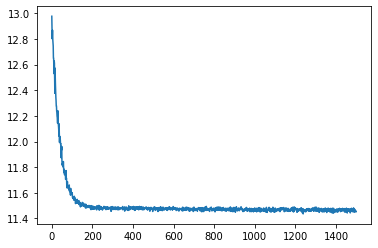

2000
tensor(11.4352, requires_grad=True)
Test Loss:  tensor(11.5537, grad_fn=<DivBackward0>)
Test Time:  0.011065006256103516
Training Minimum Loss:
[array(11.416836, dtype=float32), array(11.427747, dtype=float32), array(11.394861, dtype=float32), array(11.38299, dtype=float32), array(11.435211, dtype=float32)]
Training Time:
[11.445812940597534, 11.746490001678467, 11.149369478225708, 11.28119945526123, 11.542378902435303]
Average Training Loss:  11.411528
Std Training Loss:  0.019719634
Average Training Time:  11.433050155639648
Std Training Time:  0.20683015379004865
Testing Loss:
[array(11.569476, dtype=float32), array(11.571209, dtype=float32), array(11.572073, dtype=float32), array(11.613271, dtype=float32), array(11.553666, dtype=float32)]
Testing Time:
[0.011505842208862305, 0.00900888442993164, 0.008051872253417969, 0.008144617080688477, 0.011065006256103516]
Average Testing Loss:  11.575939
Std Testing Loss:  0.019843537
Average Testing Time:  0.009555244445800781
Std Testin

In [52]:
batch_size, sequence_length, vocab_size, k_fold = 1024, 5, 10, 5

num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'
hid_lay = 64

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = 10000
orig_probs, coded_data = create_syn_data_paper(alpha,k=vocab_size,d=sequence_length,n_samples=10000,rnd_seed=42,manual_prob=False,orig_probs=None,dirchlet_seed=0)
data = dec_to_bin(coded_data,n_features=sequence_length,k=vocab_size)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type, hid_lay)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'auto_exp5', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

#Mushroom Dataset Testing

In [31]:
 #Mai's Mario power up data processor
 mushroom_data_path = '/content/agaricus-lepiota.data'
 def process_mushroom_data(mushroom_data_path):
  mushroom_data = pd.read_csv(mushroom_data_path,header=None)
  #print(mushroom_data.head())
  
  for col_id in mushroom_data.columns:
    #print(col_id)
    unique_col_data = np.unique(mushroom_data.iloc[:,col_id])
    #print(unique_col_data)
    mapper = {}
    for i,d in enumerate(unique_col_data):
      mapper[d] = i
    mushroom_data.iloc[:,col_id] = [ mapper[x] for x in mushroom_data.iloc[:,col_id]]
    unique_col_data = np.unique(mushroom_data.iloc[:,col_id])
    #print(unique_col_data)
  mushroom_data = mushroom_data.drop([11],axis = 1) #11 had missing data, so I dropped it
  #print(mushroom_data.head())
  #print(mushroom_data.dtypes)
  #print(len(mushroom_data))
  
  return mushroom_data.to_numpy()

5 -fold:  1
(6500, 22)
epoch: 0 loss: 66.37127685546875 min loss: tensor(66.3713, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 24.618488311767578 min loss: tensor(24.4812, grad_fn=<DivBackward0>)
epoch: 300 loss: 21.90277099609375 min loss: tensor(21.7397, grad_fn=<DivBackward0>)
epoch: 450 loss: 21.263816833496094 min loss: tensor(20.8688, grad_fn=<DivBackward0>)
epoch: 600 loss: 20.957796096801758 min loss: tensor(20.6379, grad_fn=<DivBackward0>)
epoch: 750 loss: 20.799484252929688 min loss: tensor(20.4618, grad_fn=<DivBackward0>)
epoch: 900 loss: 20.683258056640625 min loss: tensor(20.4148, grad_fn=<DivBackward0>)
epoch: 1050 loss: 20.69091033935547 min loss: tensor(20.3585, grad_fn=<DivBackward0>)
epoch: 1200 loss: 20.356246948242188 min loss: tensor(20.2856, grad_fn=<DivBackward0>)
epoch: 1350 loss: 20.671669006347656 min loss: tensor(20.1724, grad_fn=<DivBackward0>)


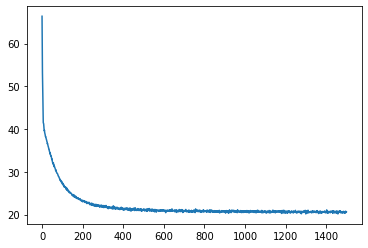

1624
tensor(20.1724, requires_grad=True)
Test Loss:  tensor(26.8398, grad_fn=<DivBackward0>)
Test Time:  0.06118154525756836
5 -fold:  2
(6500, 22)
epoch: 0 loss: 65.54362487792969 min loss: tensor(65.5436, grad_fn=<DivBackward0>)
epoch: 150 loss: 24.324787139892578 min loss: tensor(24.3248, grad_fn=<DivBackward0>)
epoch: 300 loss: 21.167837142944336 min loss: tensor(21.0726, grad_fn=<DivBackward0>)
epoch: 450 loss: 20.631746292114258 min loss: tensor(20.2599, grad_fn=<DivBackward0>)
epoch: 600 loss: 20.087974548339844 min loss: tensor(19.9294, grad_fn=<DivBackward0>)
epoch: 750 loss: 19.934246063232422 min loss: tensor(19.6925, grad_fn=<DivBackward0>)
epoch: 900 loss: 19.8084716796875 min loss: tensor(19.6359, grad_fn=<DivBackward0>)
epoch: 1050 loss: 20.01754379272461 min loss: tensor(19.6000, grad_fn=<DivBackward0>)
epoch: 1200 loss: 20.0162353515625 min loss: tensor(19.4705, grad_fn=<DivBackward0>)
epoch: 1350 loss: 19.726274490356445 min loss: tensor(19.4705, grad_fn=<DivBackward0

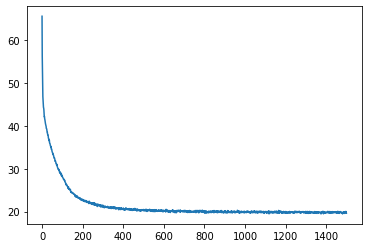

1624
tensor(19.4569, requires_grad=True)
Test Loss:  tensor(19.3791, grad_fn=<DivBackward0>)
Test Time:  0.053493499755859375
5 -fold:  3
(6500, 22)
epoch: 0 loss: 63.905662536621094 min loss: tensor(63.9057, grad_fn=<DivBackward0>)
epoch: 150 loss: 25.40850830078125 min loss: tensor(25.4071, grad_fn=<DivBackward0>)
epoch: 300 loss: 22.404678344726562 min loss: tensor(22.2478, grad_fn=<DivBackward0>)
epoch: 450 loss: 21.8625545501709 min loss: tensor(21.5525, grad_fn=<DivBackward0>)
epoch: 600 loss: 21.15350341796875 min loss: tensor(20.7803, grad_fn=<DivBackward0>)
epoch: 750 loss: 21.010910034179688 min loss: tensor(20.7057, grad_fn=<DivBackward0>)
epoch: 900 loss: 20.839725494384766 min loss: tensor(20.6703, grad_fn=<DivBackward0>)
epoch: 1050 loss: 21.04568862915039 min loss: tensor(20.4376, grad_fn=<DivBackward0>)
epoch: 1200 loss: 20.994361877441406 min loss: tensor(20.4376, grad_fn=<DivBackward0>)
epoch: 1350 loss: 20.747669219970703 min loss: tensor(20.4376, grad_fn=<DivBackwar

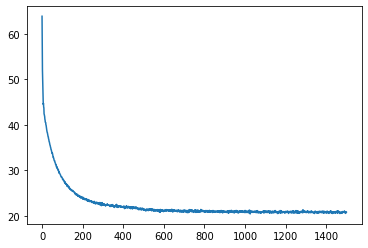

1624
tensor(20.4376, requires_grad=True)
Test Loss:  tensor(23.7948, grad_fn=<DivBackward0>)
Test Time:  0.05667567253112793
5 -fold:  4
(6500, 22)
epoch: 0 loss: 61.472312927246094 min loss: tensor(61.4723, grad_fn=<DivBackward0>)
epoch: 150 loss: 23.80994415283203 min loss: tensor(23.8099, grad_fn=<DivBackward0>)
epoch: 300 loss: 20.977218627929688 min loss: tensor(20.6484, grad_fn=<DivBackward0>)
epoch: 450 loss: 19.97821807861328 min loss: tensor(19.7108, grad_fn=<DivBackward0>)
epoch: 600 loss: 19.42644500732422 min loss: tensor(19.3466, grad_fn=<DivBackward0>)
epoch: 750 loss: 19.338016510009766 min loss: tensor(19.1871, grad_fn=<DivBackward0>)
epoch: 900 loss: 19.360353469848633 min loss: tensor(19.1280, grad_fn=<DivBackward0>)
epoch: 1050 loss: 19.344772338867188 min loss: tensor(18.9371, grad_fn=<DivBackward0>)
epoch: 1200 loss: 19.377235412597656 min loss: tensor(18.9371, grad_fn=<DivBackward0>)
epoch: 1350 loss: 19.253782272338867 min loss: tensor(18.9371, grad_fn=<DivBackwa

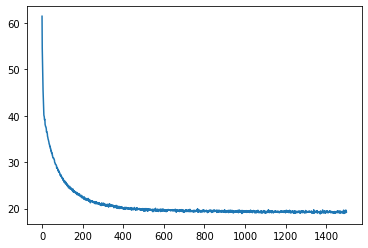

1624
tensor(18.8431, requires_grad=True)
Test Loss:  tensor(23.3109, grad_fn=<DivBackward0>)
Test Time:  0.056311607360839844
5 -fold:  5
(6500, 22)
epoch: 0 loss: 57.41461181640625 min loss: tensor(57.4146, grad_fn=<DivBackward0>)
epoch: 150 loss: 22.573530197143555 min loss: tensor(22.5735, grad_fn=<DivBackward0>)
epoch: 300 loss: 19.872459411621094 min loss: tensor(19.6829, grad_fn=<DivBackward0>)
epoch: 450 loss: 19.455978393554688 min loss: tensor(19.0281, grad_fn=<DivBackward0>)
epoch: 600 loss: 18.92336654663086 min loss: tensor(18.7152, grad_fn=<DivBackward0>)
epoch: 750 loss: 18.80222511291504 min loss: tensor(18.4645, grad_fn=<DivBackward0>)
epoch: 900 loss: 18.51056671142578 min loss: tensor(18.4403, grad_fn=<DivBackward0>)
epoch: 1050 loss: 18.735671997070312 min loss: tensor(18.3874, grad_fn=<DivBackward0>)
epoch: 1200 loss: 18.561599731445312 min loss: tensor(18.3620, grad_fn=<DivBackward0>)
epoch: 1350 loss: 18.584476470947266 min loss: tensor(18.3594, grad_fn=<DivBackwa

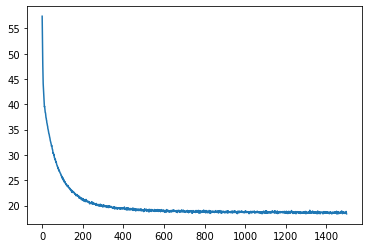

1624
tensor(18.3386, requires_grad=True)
Test Loss:  tensor(25.8869, grad_fn=<DivBackward0>)
Test Time:  0.05860733985900879
Training Minimum Loss:
[array(20.172394, dtype=float32), array(19.456938, dtype=float32), array(20.437645, dtype=float32), array(18.843128, dtype=float32), array(18.33857, dtype=float32)]
Training Time:
[141.37709975242615, 135.86155724525452, 147.181499004364, 136.02939081192017, 152.93930506706238]
Average Training Loss:  19.449736
Std Training Loss:  0.7875169
Average Training Time:  142.67777037620544
Std Training Time:  6.602062134161898
Testing Loss:
[array(26.83976, dtype=float32), array(19.379139, dtype=float32), array(23.794804, dtype=float32), array(23.310907, dtype=float32), array(25.886932, dtype=float32)]
Testing Time:
[0.06118154525756836, 0.053493499755859375, 0.05667567253112793, 0.056311607360839844, 0.05860733985900879]
Average Testing Loss:  23.842308
Std Testing Loss:  2.583398
Average Testing Time:  0.05725393295288086
Std Testing Time:  0.00

In [33]:
#print(np.unique(data, return_counts=True))
#print(data.shape)
batch_size, sequence_length, vocab_size, k_fold = 1024, 22, 12, 5

num_flows = 4 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'bipartite' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = data.shape[0]
data = process_mushroom_data(mushroom_data_path) #k=12, d=22
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp4', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

5 -fold:  1
(6500, 22)
epoch: 0 loss: 64.88448333740234 min loss: tensor(64.8845, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 25.986557006835938 min loss: tensor(25.9829, grad_fn=<DivBackward0>)
epoch: 300 loss: 22.563369750976562 min loss: tensor(22.5253, grad_fn=<DivBackward0>)
epoch: 450 loss: 21.894407272338867 min loss: tensor(21.5700, grad_fn=<DivBackward0>)
epoch: 600 loss: 21.66065216064453 min loss: tensor(21.1646, grad_fn=<DivBackward0>)
epoch: 750 loss: 21.240299224853516 min loss: tensor(21.1003, grad_fn=<DivBackward0>)
epoch: 900 loss: 21.223068237304688 min loss: tensor(20.9584, grad_fn=<DivBackward0>)
epoch: 1050 loss: 21.369384765625 min loss: tensor(20.8388, grad_fn=<DivBackward0>)
epoch: 1200 loss: 21.3001708984375 min loss: tensor(20.7986, grad_fn=<DivBackward0>)
epoch: 1350 loss: 21.17807388305664 min loss: tensor(20.7986, grad_fn=<DivBackward0>)


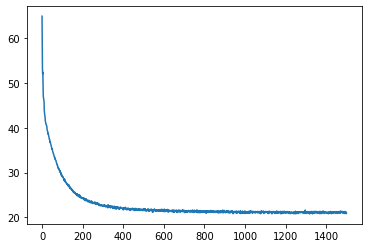

1624
tensor(20.7986, requires_grad=True)
Test Loss:  tensor(26.2200, grad_fn=<DivBackward0>)
Test Time:  0.025341272354125977
5 -fold:  2
(6500, 22)
epoch: 0 loss: 60.61188507080078 min loss: tensor(60.6119, grad_fn=<DivBackward0>)
epoch: 150 loss: 26.117210388183594 min loss: tensor(26.1143, grad_fn=<DivBackward0>)
epoch: 300 loss: 22.863441467285156 min loss: tensor(22.7843, grad_fn=<DivBackward0>)
epoch: 450 loss: 22.058246612548828 min loss: tensor(21.8562, grad_fn=<DivBackward0>)
epoch: 600 loss: 21.682109832763672 min loss: tensor(21.4425, grad_fn=<DivBackward0>)
epoch: 750 loss: 21.647090911865234 min loss: tensor(21.4425, grad_fn=<DivBackward0>)
epoch: 900 loss: 21.750774383544922 min loss: tensor(21.2995, grad_fn=<DivBackward0>)
epoch: 1050 loss: 21.400617599487305 min loss: tensor(21.2287, grad_fn=<DivBackward0>)
epoch: 1200 loss: 21.476097106933594 min loss: tensor(21.2074, grad_fn=<DivBackward0>)
epoch: 1350 loss: 21.407676696777344 min loss: tensor(21.1233, grad_fn=<DivBac

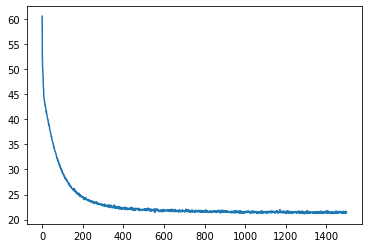

1624
tensor(21.1233, requires_grad=True)
Test Loss:  tensor(20.7703, grad_fn=<DivBackward0>)
Test Time:  0.025819063186645508
5 -fold:  3
(6500, 22)
epoch: 0 loss: 61.60626220703125 min loss: tensor(61.6063, grad_fn=<DivBackward0>)
epoch: 150 loss: 25.44821548461914 min loss: tensor(25.4482, grad_fn=<DivBackward0>)
epoch: 300 loss: 22.317766189575195 min loss: tensor(22.2491, grad_fn=<DivBackward0>)
epoch: 450 loss: 21.745624542236328 min loss: tensor(21.3632, grad_fn=<DivBackward0>)
epoch: 600 loss: 21.35568618774414 min loss: tensor(20.9647, grad_fn=<DivBackward0>)
epoch: 750 loss: 21.17648696899414 min loss: tensor(20.9153, grad_fn=<DivBackward0>)
epoch: 900 loss: 21.242895126342773 min loss: tensor(20.8120, grad_fn=<DivBackward0>)
epoch: 1050 loss: 20.815555572509766 min loss: tensor(20.7840, grad_fn=<DivBackward0>)
epoch: 1200 loss: 21.200538635253906 min loss: tensor(20.6767, grad_fn=<DivBackward0>)
epoch: 1350 loss: 21.127168655395508 min loss: tensor(20.6767, grad_fn=<DivBackwa

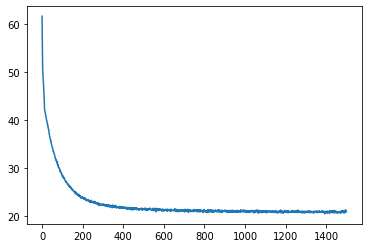

1624
tensor(20.5286, requires_grad=True)
Test Loss:  tensor(24.3110, grad_fn=<DivBackward0>)
Test Time:  0.02547454833984375
5 -fold:  4
(6500, 22)
epoch: 0 loss: 57.887367248535156 min loss: tensor(57.8874, grad_fn=<DivBackward0>)
epoch: 150 loss: 24.786170959472656 min loss: tensor(24.6727, grad_fn=<DivBackward0>)
epoch: 300 loss: 21.905929565429688 min loss: tensor(21.6587, grad_fn=<DivBackward0>)
epoch: 450 loss: 20.887496948242188 min loss: tensor(20.8024, grad_fn=<DivBackward0>)
epoch: 600 loss: 20.780004501342773 min loss: tensor(20.5053, grad_fn=<DivBackward0>)
epoch: 750 loss: 20.604202270507812 min loss: tensor(20.2665, grad_fn=<DivBackward0>)
epoch: 900 loss: 20.39844512939453 min loss: tensor(20.1598, grad_fn=<DivBackward0>)
epoch: 1050 loss: 20.595632553100586 min loss: tensor(19.9661, grad_fn=<DivBackward0>)
epoch: 1200 loss: 20.410213470458984 min loss: tensor(19.9661, grad_fn=<DivBackward0>)
epoch: 1350 loss: 20.142101287841797 min loss: tensor(19.7904, grad_fn=<DivBack

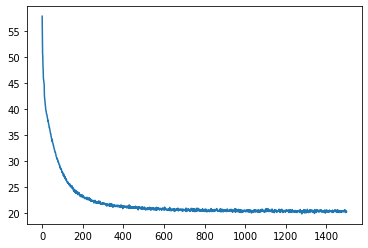

1624
tensor(19.7904, requires_grad=True)
Test Loss:  tensor(24.1008, grad_fn=<DivBackward0>)
Test Time:  0.02510809898376465
5 -fold:  5
(6500, 22)
epoch: 0 loss: 65.88324737548828 min loss: tensor(65.8832, grad_fn=<DivBackward0>)
epoch: 150 loss: 24.169132232666016 min loss: tensor(24.1691, grad_fn=<DivBackward0>)
epoch: 300 loss: 21.126564025878906 min loss: tensor(20.8447, grad_fn=<DivBackward0>)
epoch: 450 loss: 20.334388732910156 min loss: tensor(19.8902, grad_fn=<DivBackward0>)
epoch: 600 loss: 19.853351593017578 min loss: tensor(19.6241, grad_fn=<DivBackward0>)
epoch: 750 loss: 19.72736358642578 min loss: tensor(19.4035, grad_fn=<DivBackward0>)
epoch: 900 loss: 19.624595642089844 min loss: tensor(19.3760, grad_fn=<DivBackward0>)
epoch: 1050 loss: 19.56574821472168 min loss: tensor(19.2091, grad_fn=<DivBackward0>)
epoch: 1200 loss: 19.489532470703125 min loss: tensor(19.1461, grad_fn=<DivBackward0>)
epoch: 1350 loss: 19.525102615356445 min loss: tensor(19.1461, grad_fn=<DivBackwa

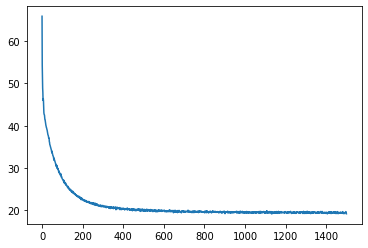

1624
tensor(19.1461, requires_grad=True)
Test Loss:  tensor(29.0791, grad_fn=<DivBackward0>)
Test Time:  0.023979902267456055
Training Minimum Loss:
[array(20.79858, dtype=float32), array(21.123268, dtype=float32), array(20.528578, dtype=float32), array(19.790352, dtype=float32), array(19.146095, dtype=float32)]
Training Time:
[46.158748388290405, 53.86865043640137, 51.971962690353394, 48.69832706451416, 52.28625750541687]
Average Training Loss:  20.277374
Std Training Loss:  0.7165582
Average Training Time:  50.59678921699524
Std Training Time:  2.7839125690336677
Testing Loss:
[array(26.219988, dtype=float32), array(20.770287, dtype=float32), array(24.311014, dtype=float32), array(24.100843, dtype=float32), array(29.079103, dtype=float32)]
Testing Time:
[0.025341272354125977, 0.025819063186645508, 0.02547454833984375, 0.02510809898376465, 0.023979902267456055]
Average Testing Loss:  24.896246
Std Testing Loss:  2.7293696
Average Testing Time:  0.025144577026367188
Std Testing Time:  

In [34]:
#print(np.unique(data, return_counts=True))
#print(data.shape)
batch_size, sequence_length, vocab_size, k_fold = 1024, 22, 12, 5

num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'
hid_lay = 64

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = data.shape[0]
data = process_mushroom_data(mushroom_data_path) #k=12, d=22
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type, hid_lay)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp4', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

# Coplua Data Testing

In [ ]:
data = np.load('/content/coup_data_4_2.npy')
print(data.shape)

Strong Correlation

5 -fold:  1
(6500, 4)
epoch: 0 loss: 2.829869031906128 min loss: tensor(2.8299, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 2.4633283615112305 min loss: tensor(2.4188, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.5151710510253906 min loss: tensor(2.4141, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.461308240890503 min loss: tensor(2.4141, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.4597902297973633 min loss: tensor(2.4141, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.48437762260437 min loss: tensor(2.3932, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.5070202350616455 min loss: tensor(2.3932, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.4795126914978027 min loss: tensor(2.3932, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.4992218017578125 min loss: tensor(2.3932, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.4639182090759277 min loss: tensor(2.3932, grad_fn=<DivBackward0>)


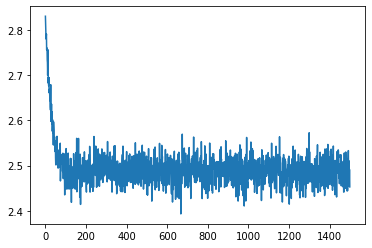

1624
tensor(2.3932, requires_grad=True)
Test Loss:  tensor(2.5290, grad_fn=<DivBackward0>)
Test Time:  0.01627326011657715
5 -fold:  2
(6500, 4)
epoch: 0 loss: 2.8372914791107178 min loss: tensor(2.8373, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.4830939769744873 min loss: tensor(2.4276, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.0708212852478027 min loss: tensor(2.0708, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.861366629600525 min loss: tensor(1.8198, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.811034917831421 min loss: tensor(1.7961, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.8748979568481445 min loss: tensor(1.7961, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.9202332496643066 min loss: tensor(1.7961, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.88935124874115 min loss: tensor(1.7961, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.8924356698989868 min loss: tensor(1.7961, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.9006236791610718 min loss: tensor(1.7961, grad_fn=<DivBackward0>)


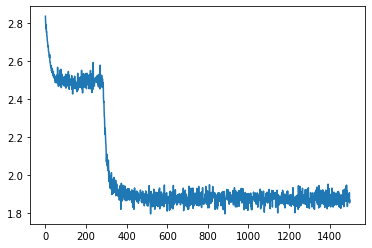

1624
tensor(1.7961, requires_grad=True)
Test Loss:  tensor(1.8921, grad_fn=<DivBackward0>)
Test Time:  0.008878946304321289
5 -fold:  3
(6500, 4)
epoch: 0 loss: 4.341513633728027 min loss: tensor(4.3415, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.6413716077804565 min loss: tensor(1.5588, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.6059622764587402 min loss: tensor(1.5333, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.5562355518341064 min loss: tensor(1.5283, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.62692129611969 min loss: tensor(1.5050, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.5752854347229004 min loss: tensor(1.5050, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.5673452615737915 min loss: tensor(1.5050, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.5593153238296509 min loss: tensor(1.5050, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.6141809225082397 min loss: tensor(1.5050, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.6148027181625366 min loss: tensor(1.5050, grad_fn=<DivBackward0>)


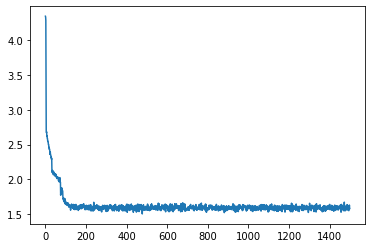

1624
tensor(1.5050, requires_grad=True)
Test Loss:  tensor(1.5830, grad_fn=<DivBackward0>)
Test Time:  0.009682893753051758
5 -fold:  4
(6500, 4)
epoch: 0 loss: 3.4965293407440186 min loss: tensor(3.4965, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.50051212310791 min loss: tensor(2.4712, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.4868345260620117 min loss: tensor(2.4361, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.553757905960083 min loss: tensor(2.4361, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.514564037322998 min loss: tensor(2.4147, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.48516845703125 min loss: tensor(2.4147, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.505931854248047 min loss: tensor(2.4147, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.5091726779937744 min loss: tensor(2.4147, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.524670362472534 min loss: tensor(2.4147, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.4956657886505127 min loss: tensor(2.4147, grad_fn=<DivBackward0>)


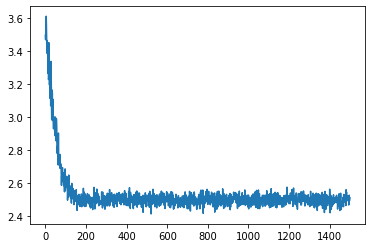

1624
tensor(2.4147, requires_grad=True)
Test Loss:  tensor(2.4809, grad_fn=<DivBackward0>)
Test Time:  0.011423826217651367
5 -fold:  5
(6500, 4)
epoch: 0 loss: 3.3908674716949463 min loss: tensor(3.3909, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.507307291030884 min loss: tensor(2.4439, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.4984188079833984 min loss: tensor(2.4336, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.457797050476074 min loss: tensor(2.4270, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.4625637531280518 min loss: tensor(2.3834, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.4860005378723145 min loss: tensor(2.3834, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.494739294052124 min loss: tensor(2.3834, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.453341007232666 min loss: tensor(2.3834, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.503721237182617 min loss: tensor(2.3834, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.4637913703918457 min loss: tensor(2.3834, grad_fn=<DivBackward0>)


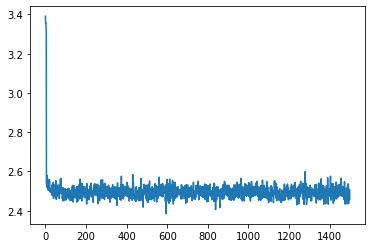

1624
tensor(2.3834, requires_grad=True)
Test Loss:  tensor(2.5047, grad_fn=<DivBackward0>)
Test Time:  0.009270429611206055
Training Minimum Loss:
[array(2.3931684, dtype=float32), array(1.7960821, dtype=float32), array(1.5049658, dtype=float32), array(2.4146826, dtype=float32), array(2.3834329, dtype=float32)]
Training Time:
[18.296391010284424, 18.25522518157959, 18.280213832855225, 18.81394934654236, 18.60243511199951]
Average Training Loss:  2.0984664
Std Training Loss:  0.37728694
Average Training Time:  18.44964289665222
Std Training Time:  0.22183563589773656
Testing Loss:
[array(2.529049, dtype=float32), array(1.8921232, dtype=float32), array(1.5830019, dtype=float32), array(2.480884, dtype=float32), array(2.5047338, dtype=float32)]
Testing Time:
[0.01627326011657715, 0.008878946304321289, 0.009682893753051758, 0.011423826217651367, 0.009270429611206055]
Average Testing Loss:  2.1979585
Std Testing Loss:  0.38871217
Average Testing Time:  0.011105871200561524
Std Testing Time: 

In [35]:
#print(np.unique(data, return_counts=True))
#print(data.shape)
batch_size, sequence_length, vocab_size, k_fold = 1024, 4, 2, 5

num_flows = 4 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'bipartite' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = data.shape[0]
data = np.load('/content/coup_data_4_2_moderate_corr.npy').astype(int)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp7', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Moderate Correlation

5 -fold:  1
(8000, 4)
epoch: 0 loss: 2.679145336151123 min loss: tensor(2.6791, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 2.5094549655914307 min loss: tensor(2.4161, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.4554131031036377 min loss: tensor(2.4161, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.42672061920166 min loss: tensor(2.4161, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.5106582641601562 min loss: tensor(2.4161, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.5172040462493896 min loss: tensor(2.4161, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.4728946685791016 min loss: tensor(2.4161, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.516798734664917 min loss: tensor(2.4161, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.5458123683929443 min loss: tensor(2.4161, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.485105037689209 min loss: tensor(2.4161, grad_fn=<DivBackward0>)


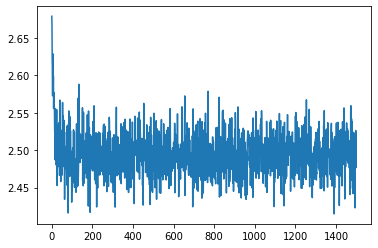

2000
tensor(2.4149, requires_grad=True)
Test Loss:  tensor(2.5208, grad_fn=<DivBackward0>)
Test Time:  0.010969161987304688
5 -fold:  2
(8000, 4)
epoch: 0 loss: 3.6040234565734863 min loss: tensor(3.6040, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.543314218521118 min loss: tensor(2.4992, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.4673309326171875 min loss: tensor(2.4270, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.5128870010375977 min loss: tensor(2.4204, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.563452959060669 min loss: tensor(2.4204, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.4766783714294434 min loss: tensor(2.4115, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.548431873321533 min loss: tensor(2.4115, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.5099637508392334 min loss: tensor(2.4115, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.4902069568634033 min loss: tensor(2.4115, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.5069310665130615 min loss: tensor(2.4115, grad_fn=<DivBackward0>)


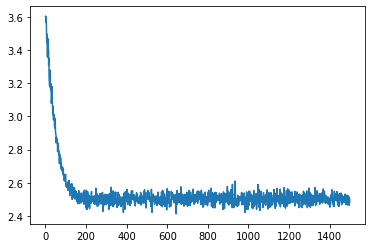

2000
tensor(2.4115, requires_grad=True)
Test Loss:  tensor(2.4856, grad_fn=<DivBackward0>)
Test Time:  0.011057853698730469
5 -fold:  3
(8000, 4)
epoch: 0 loss: 2.965221881866455 min loss: tensor(2.9652, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.5107741355895996 min loss: tensor(2.4493, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.518156051635742 min loss: tensor(2.4359, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.496232271194458 min loss: tensor(2.4351, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.4726247787475586 min loss: tensor(2.4349, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.5462045669555664 min loss: tensor(2.4349, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.5022270679473877 min loss: tensor(2.4349, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.458766222000122 min loss: tensor(2.4229, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.522373914718628 min loss: tensor(2.4229, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.511439323425293 min loss: tensor(2.4229, grad_fn=<DivBackward0>)


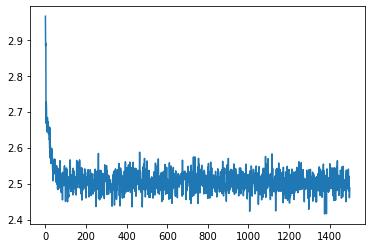

2000
tensor(2.4156, requires_grad=True)
Test Loss:  tensor(2.4757, grad_fn=<DivBackward0>)
Test Time:  0.011780738830566406
5 -fold:  4
(8000, 4)
epoch: 0 loss: 3.173182725906372 min loss: tensor(3.1732, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.8090934753417969 min loss: tensor(1.7053, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.7201130390167236 min loss: tensor(1.6822, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.7854305505752563 min loss: tensor(1.6141, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.7550654411315918 min loss: tensor(1.6141, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.7136691808700562 min loss: tensor(1.6141, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.6908998489379883 min loss: tensor(1.6141, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.657690405845642 min loss: tensor(1.6141, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.7421412467956543 min loss: tensor(1.6141, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.6763701438903809 min loss: tensor(1.6141, grad_fn=<DivBackward0>)


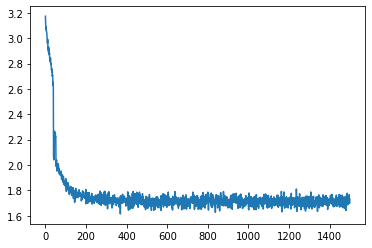

2000
tensor(1.6141, requires_grad=True)
Test Loss:  tensor(1.6744, grad_fn=<DivBackward0>)
Test Time:  0.01153707504272461
5 -fold:  5
(8000, 4)
epoch: 0 loss: 4.11348295211792 min loss: tensor(4.1135, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.1664769649505615 min loss: tensor(2.1278, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.0193581581115723 min loss: tensor(1.9914, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.004357099533081 min loss: tensor(1.9572, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.0179879665374756 min loss: tensor(1.9505, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.0181515216827393 min loss: tensor(1.9505, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.009453296661377 min loss: tensor(1.9230, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.0501952171325684 min loss: tensor(1.9230, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.9915385246276855 min loss: tensor(1.9230, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.0230846405029297 min loss: tensor(1.9230, grad_fn=<DivBackward0>)


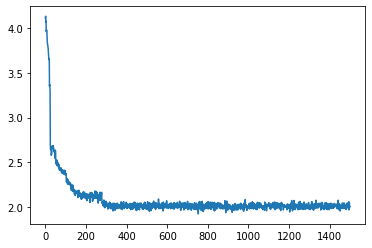

2000
tensor(1.9230, requires_grad=True)
Test Loss:  tensor(2.0374, grad_fn=<DivBackward0>)
Test Time:  0.010121583938598633
Training Minimum Loss:
[array(2.4148974, dtype=float32), array(2.4115427, dtype=float32), array(2.4155774, dtype=float32), array(1.6141057, dtype=float32), array(1.9229856, dtype=float32)]
Training Time:
[18.497640132904053, 18.047088861465454, 17.858241319656372, 18.294797897338867, 18.482683897018433]
Average Training Loss:  2.1558216
Std Training Loss:  0.3309548
Average Training Time:  18.236090421676636
Std Training Time:  0.24946129755242702
Testing Loss:
[array(2.5207663, dtype=float32), array(2.4855797, dtype=float32), array(2.4756792, dtype=float32), array(1.6743625, dtype=float32), array(2.0373662, dtype=float32)]
Testing Time:
[0.010969161987304688, 0.011057853698730469, 0.011780738830566406, 0.01153707504272461, 0.010121583938598633]
Average Testing Loss:  2.2387507
Std Testing Loss:  0.3333713
Average Testing Time:  0.01109328269958496
Std Testing Tim

In [36]:
#print(np.unique(data, return_counts=True))
#print(data.shape)
batch_size, sequence_length, vocab_size, k_fold = 1024, 4, 2, 5

num_flows = 4 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'bipartite' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = data.shape[0]
data = np.load('/content/coup_data_4_2_moderate_corr.npy').astype(int)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp7', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Weak Correlation

5 -fold:  1
(8000, 4)
epoch: 0 loss: 2.5625736713409424 min loss: tensor(2.5626, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 2.425727128982544 min loss: tensor(2.3652, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.4084761142730713 min loss: tensor(2.3269, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.3843202590942383 min loss: tensor(2.3269, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.4120681285858154 min loss: tensor(2.3199, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.4354870319366455 min loss: tensor(2.3152, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.385256052017212 min loss: tensor(2.3152, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.393110752105713 min loss: tensor(2.3152, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.3532681465148926 min loss: tensor(2.3152, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.3927693367004395 min loss: tensor(2.3152, grad_fn=<DivBackward0>)


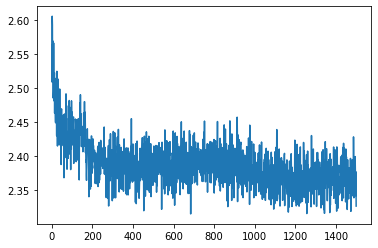

2000
tensor(2.3152, requires_grad=True)
Test Loss:  tensor(2.3722, grad_fn=<DivBackward0>)
Test Time:  0.014653444290161133
5 -fold:  2
(8000, 4)
epoch: 0 loss: 4.662476062774658 min loss: tensor(4.6625, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.533717155456543 min loss: tensor(2.4536, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.4850292205810547 min loss: tensor(2.4343, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.491154193878174 min loss: tensor(2.4343, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.5545811653137207 min loss: tensor(2.4343, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.549868106842041 min loss: tensor(2.4343, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.541494846343994 min loss: tensor(2.4343, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.50588321685791 min loss: tensor(2.4336, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.4984164237976074 min loss: tensor(2.4336, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.5291061401367188 min loss: tensor(2.4336, grad_fn=<DivBackward0>)


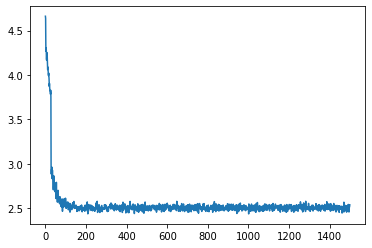

2000
tensor(2.4336, requires_grad=True)
Test Loss:  tensor(2.4954, grad_fn=<DivBackward0>)
Test Time:  0.013739347457885742
5 -fold:  3
(8000, 4)
epoch: 0 loss: 4.031799793243408 min loss: tensor(4.0318, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.5276474952697754 min loss: tensor(2.4172, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.486652374267578 min loss: tensor(2.4172, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.50323486328125 min loss: tensor(2.4172, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.500838279724121 min loss: tensor(2.4172, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.551229238510132 min loss: tensor(2.4172, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.495358943939209 min loss: tensor(2.4172, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.4652485847473145 min loss: tensor(2.4172, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.4883275032043457 min loss: tensor(2.4172, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.51956844329834 min loss: tensor(2.4172, grad_fn=<DivBackward0>)


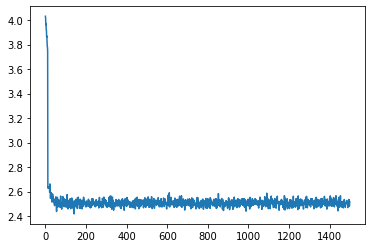

2000
tensor(2.4172, requires_grad=True)
Test Loss:  tensor(2.4866, grad_fn=<DivBackward0>)
Test Time:  0.010693788528442383
5 -fold:  4
(8000, 4)
epoch: 0 loss: 3.019796133041382 min loss: tensor(3.0198, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.3817315101623535 min loss: tensor(2.3089, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.397725820541382 min loss: tensor(2.2945, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.338386297225952 min loss: tensor(2.2945, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.389295816421509 min loss: tensor(2.2945, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.3742427825927734 min loss: tensor(2.2867, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.4155359268188477 min loss: tensor(2.2867, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.357525587081909 min loss: tensor(2.2867, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.379124641418457 min loss: tensor(2.2867, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.3820033073425293 min loss: tensor(2.2867, grad_fn=<DivBackward0>)


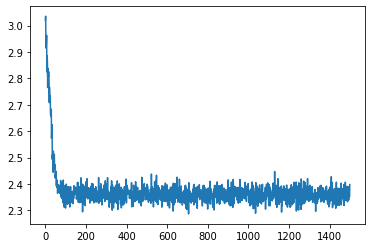

2000
tensor(2.2867, requires_grad=True)
Test Loss:  tensor(2.3482, grad_fn=<DivBackward0>)
Test Time:  0.010525703430175781
5 -fold:  5
(8000, 4)
epoch: 0 loss: 3.0113368034362793 min loss: tensor(3.0113, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.5303759574890137 min loss: tensor(2.4560, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.519279718399048 min loss: tensor(2.4415, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.5440568923950195 min loss: tensor(2.4254, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.506544828414917 min loss: tensor(2.4201, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.4667065143585205 min loss: tensor(2.4201, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.496795654296875 min loss: tensor(2.4201, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.51051926612854 min loss: tensor(2.4175, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.5060629844665527 min loss: tensor(2.4175, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.5092358589172363 min loss: tensor(2.4175, grad_fn=<DivBackward0>)


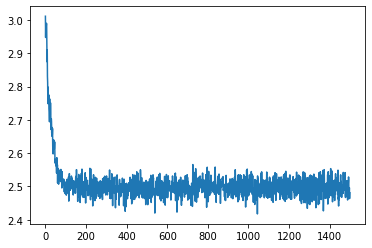

2000
tensor(2.4175, requires_grad=True)
Test Loss:  tensor(2.5262, grad_fn=<DivBackward0>)
Test Time:  0.011568546295166016
Training Minimum Loss:
[array(2.3152444, dtype=float32), array(2.4335656, dtype=float32), array(2.4172482, dtype=float32), array(2.2867074, dtype=float32), array(2.4174795, dtype=float32)]
Training Time:
[18.523155450820923, 18.2159264087677, 18.02226448059082, 18.22828245162964, 18.40829300880432]
Average Training Loss:  2.374049
Std Training Loss:  0.060631912
Average Training Time:  18.27958436012268
Std Training Time:  0.1725053816304975
Testing Loss:
[array(2.372207, dtype=float32), array(2.4953659, dtype=float32), array(2.4865716, dtype=float32), array(2.3482368, dtype=float32), array(2.5261881, dtype=float32)]
Testing Time:
[0.014653444290161133, 0.013739347457885742, 0.010693788528442383, 0.010525703430175781, 0.011568546295166016]
Average Testing Loss:  2.4457138
Std Testing Loss:  0.07143644
Average Testing Time:  0.01223616600036621
Std Testing Time:  0

In [37]:
#print(np.unique(data, return_counts=True))
#print(data.shape)
batch_size, sequence_length, vocab_size, k_fold = 1024, 4, 2, 5

num_flows = 4 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'bipartite' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = data.shape[0]
data = np.load('/content/coup_data_4_2_weak_corr.npy').astype(int)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp7', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

No Correlation

5 -fold:  1
(8000, 4)
epoch: 0 loss: 3.0236637592315674 min loss: tensor(3.0237, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 2.4864466190338135 min loss: tensor(2.4628, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.486060857772827 min loss: tensor(2.4584, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.507833957672119 min loss: tensor(2.4418, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.5199363231658936 min loss: tensor(2.4418, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.5054709911346436 min loss: tensor(2.4418, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.5092387199401855 min loss: tensor(2.4415, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.520782470703125 min loss: tensor(2.4415, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.4996273517608643 min loss: tensor(2.4415, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.4929909706115723 min loss: tensor(2.4415, grad_fn=<DivBackward0>)


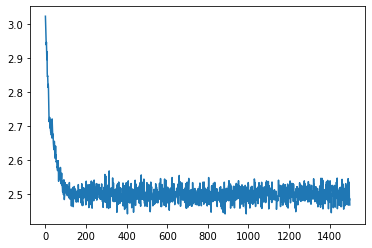

2000
tensor(2.4415, requires_grad=True)
Test Loss:  tensor(2.4764, grad_fn=<DivBackward0>)
Test Time:  0.010701894760131836
5 -fold:  2
(8000, 4)
epoch: 0 loss: 4.866413593292236 min loss: tensor(4.8664, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.503469705581665 min loss: tensor(2.4636, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.4581172466278076 min loss: tensor(2.4430, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.4781079292297363 min loss: tensor(2.4430, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.5069785118103027 min loss: tensor(2.4430, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.4669737815856934 min loss: tensor(2.4430, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.490070343017578 min loss: tensor(2.4430, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.4822287559509277 min loss: tensor(2.4430, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.483487844467163 min loss: tensor(2.4284, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.5003514289855957 min loss: tensor(2.4284, grad_fn=<DivBackward0>)


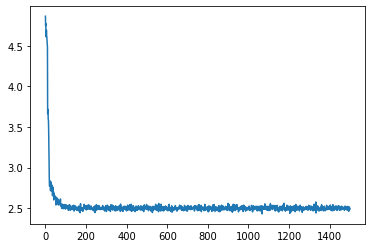

2000
tensor(2.4284, requires_grad=True)
Test Loss:  tensor(2.4753, grad_fn=<DivBackward0>)
Test Time:  0.010312557220458984
5 -fold:  3
(8000, 4)
epoch: 0 loss: 3.6555018424987793 min loss: tensor(3.6555, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.500516414642334 min loss: tensor(2.4742, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.46230149269104 min loss: tensor(2.4434, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.4888880252838135 min loss: tensor(2.4434, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.4952828884124756 min loss: tensor(2.4434, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.47541880607605 min loss: tensor(2.4421, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.486966609954834 min loss: tensor(2.4421, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.4792375564575195 min loss: tensor(2.4421, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.4978742599487305 min loss: tensor(2.4371, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.4726743698120117 min loss: tensor(2.4371, grad_fn=<DivBackward0>)


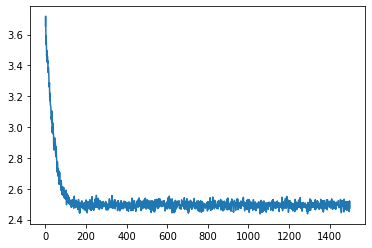

2000
tensor(2.4371, requires_grad=True)
Test Loss:  tensor(2.4942, grad_fn=<DivBackward0>)
Test Time:  0.011448860168457031
5 -fold:  4
(8000, 4)
epoch: 0 loss: 3.4066739082336426 min loss: tensor(3.4067, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.4785397052764893 min loss: tensor(2.4647, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.4770166873931885 min loss: tensor(2.4462, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.5046606063842773 min loss: tensor(2.4462, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.5114519596099854 min loss: tensor(2.4462, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.494145393371582 min loss: tensor(2.4462, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.4848873615264893 min loss: tensor(2.4398, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.5281598567962646 min loss: tensor(2.4398, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.5065572261810303 min loss: tensor(2.4398, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.5045790672302246 min loss: tensor(2.4332, grad_fn=<DivBackward0>)


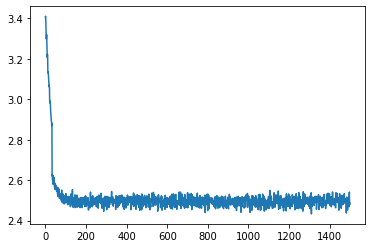

2000
tensor(2.4332, requires_grad=True)
Test Loss:  tensor(2.4919, grad_fn=<DivBackward0>)
Test Time:  0.01108241081237793
5 -fold:  5
(8000, 4)
epoch: 0 loss: 3.4422788619995117 min loss: tensor(3.4423, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.4724104404449463 min loss: tensor(2.4453, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.4822185039520264 min loss: tensor(2.4414, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.46402645111084 min loss: tensor(2.4241, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.472681999206543 min loss: tensor(2.4241, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.5479283332824707 min loss: tensor(2.4241, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.487417221069336 min loss: tensor(2.4241, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.4383645057678223 min loss: tensor(2.4241, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.4863011837005615 min loss: tensor(2.4241, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.486851930618286 min loss: tensor(2.4241, grad_fn=<DivBackward0>)


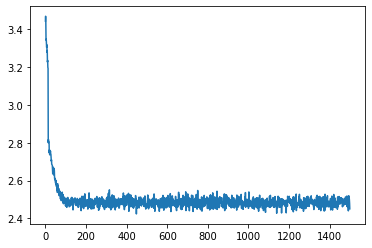

2000
tensor(2.4241, requires_grad=True)
Test Loss:  tensor(2.5334, grad_fn=<DivBackward0>)
Test Time:  0.01068568229675293
Training Minimum Loss:
[array(2.441517, dtype=float32), array(2.428359, dtype=float32), array(2.437126, dtype=float32), array(2.433245, dtype=float32), array(2.4241047, dtype=float32)]
Training Time:
[18.393107414245605, 18.089996337890625, 17.963045835494995, 18.22495698928833, 17.663655042648315]
Average Training Loss:  2.4328704
Std Training Loss:  0.006167747
Average Training Time:  18.066952323913576
Std Training Time:  0.2471108654921058
Testing Loss:
[array(2.4763944, dtype=float32), array(2.475302, dtype=float32), array(2.4941642, dtype=float32), array(2.49187, dtype=float32), array(2.5334013, dtype=float32)]
Testing Time:
[0.010701894760131836, 0.010312557220458984, 0.011448860168457031, 0.01108241081237793, 0.01068568229675293]
Average Testing Loss:  2.4942265
Std Testing Loss:  0.021053927
Average Testing Time:  0.010846281051635742
Std Testing Time:  0.

In [38]:
#print(np.unique(data, return_counts=True))
#print(data.shape)
batch_size, sequence_length, vocab_size, k_fold = 1024, 4, 2, 5

num_flows = 4 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'bipartite' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = data.shape[0]
data = np.load('/content/coup_data_4_2_no_corr.npy').astype(int)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp7', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Autoregressive Test

Strong Correlation

5 -fold:  1
(8000, 4)
epoch: 0 loss: 2.6285176277160645 min loss: tensor(2.6285, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 1.592976450920105 min loss: tensor(1.5593, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.559800148010254 min loss: tensor(1.5068, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.5633349418640137 min loss: tensor(1.4705, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.5713844299316406 min loss: tensor(1.4657, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.5464558601379395 min loss: tensor(1.4657, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.5115740299224854 min loss: tensor(1.4591, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.5296516418457031 min loss: tensor(1.4398, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.4820985794067383 min loss: tensor(1.4398, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.55574631690979 min loss: tensor(1.4398, grad_fn=<DivBackward0>)


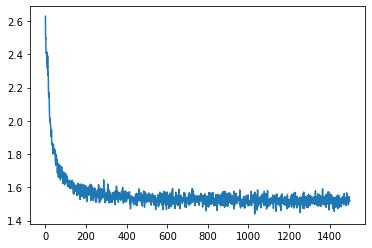

2000
tensor(1.4398, requires_grad=True)
Test Loss:  tensor(1.5189, grad_fn=<DivBackward0>)
Test Time:  0.006758451461791992
5 -fold:  2
(8000, 4)
epoch: 0 loss: 4.151748180389404 min loss: tensor(4.1517, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.5672492980957031 min loss: tensor(1.5427, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.5627186298370361 min loss: tensor(1.4868, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.5100051164627075 min loss: tensor(1.4823, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.5072517395019531 min loss: tensor(1.4703, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.517077088356018 min loss: tensor(1.4703, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.5067318677902222 min loss: tensor(1.4539, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.539994239807129 min loss: tensor(1.4446, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.504873514175415 min loss: tensor(1.4446, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.5090382099151611 min loss: tensor(1.4446, grad_fn=<DivBackward0>)


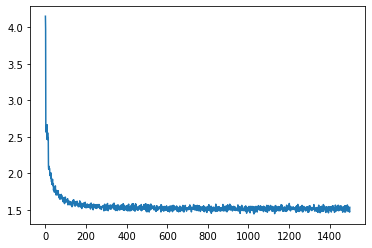

2000
tensor(1.4446, requires_grad=True)
Test Loss:  tensor(1.5372, grad_fn=<DivBackward0>)
Test Time:  0.007055044174194336
5 -fold:  3
(8000, 4)
epoch: 0 loss: 3.436415672302246 min loss: tensor(3.4364, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.7968844175338745 min loss: tensor(1.7562, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.7115381956100464 min loss: tensor(1.6966, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.6982338428497314 min loss: tensor(1.6638, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.7181094884872437 min loss: tensor(1.6455, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.6770663261413574 min loss: tensor(1.6455, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.7160980701446533 min loss: tensor(1.6455, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.7357165813446045 min loss: tensor(1.6440, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.7405825853347778 min loss: tensor(1.6440, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.6959683895111084 min loss: tensor(1.6440, grad_fn=<DivBackward0>)


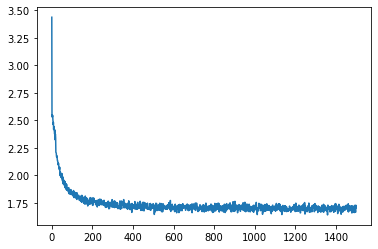

2000
tensor(1.6410, requires_grad=True)
Test Loss:  tensor(1.6873, grad_fn=<DivBackward0>)
Test Time:  0.006514310836791992
5 -fold:  4
(8000, 4)
epoch: 0 loss: 4.273947238922119 min loss: tensor(4.2739, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.5606192350387573 min loss: tensor(1.5223, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.5209639072418213 min loss: tensor(1.4651, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.527490258216858 min loss: tensor(1.4651, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.560728907585144 min loss: tensor(1.4651, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.5519073009490967 min loss: tensor(1.4651, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.5399236679077148 min loss: tensor(1.4651, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.5388582944869995 min loss: tensor(1.4651, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.540616750717163 min loss: tensor(1.4612, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.5256364345550537 min loss: tensor(1.4515, grad_fn=<DivBackward0>)


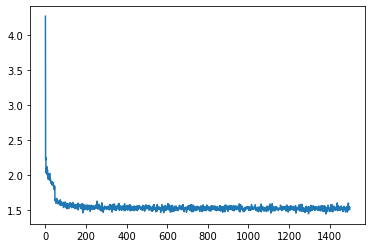

2000
tensor(1.4492, requires_grad=True)
Test Loss:  tensor(1.4833, grad_fn=<DivBackward0>)
Test Time:  0.006326913833618164
5 -fold:  5
(8000, 4)
epoch: 0 loss: 4.107395172119141 min loss: tensor(4.1074, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.7327144145965576 min loss: tensor(1.6831, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.616991400718689 min loss: tensor(1.6170, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.6616966724395752 min loss: tensor(1.5729, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.6273778676986694 min loss: tensor(1.5541, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.656591773033142 min loss: tensor(1.5536, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.5375254154205322 min loss: tensor(1.4544, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.5187307596206665 min loss: tensor(1.4544, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.5174051523208618 min loss: tensor(1.4307, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.5472757816314697 min loss: tensor(1.4307, grad_fn=<DivBackward0>)


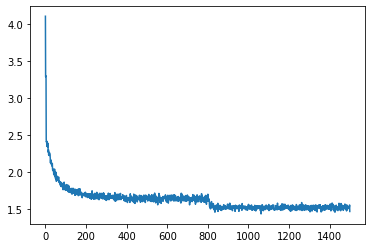

2000
tensor(1.4307, requires_grad=True)
Test Loss:  tensor(1.5445, grad_fn=<DivBackward0>)
Test Time:  0.005896091461181641
Training Minimum Loss:
[array(1.4398134, dtype=float32), array(1.4445972, dtype=float32), array(1.6410296, dtype=float32), array(1.4491587, dtype=float32), array(1.4307203, dtype=float32)]
Training Time:
[7.21224308013916, 7.210329532623291, 7.430074214935303, 7.321435928344727, 7.291499853134155]
Average Training Loss:  1.4810638
Std Training Loss:  0.08021579
Average Training Time:  7.293116521835327
Std Training Time:  0.08118646593685203
Testing Loss:
[array(1.5188916, dtype=float32), array(1.5371612, dtype=float32), array(1.6872933, dtype=float32), array(1.4832991, dtype=float32), array(1.5444672, dtype=float32)]
Testing Time:
[0.006758451461791992, 0.007055044174194336, 0.006514310836791992, 0.006326913833618164, 0.005896091461181641]
Average Testing Loss:  1.5542225
Std Testing Loss:  0.069817595
Average Testing Time:  0.006510162353515625
Std Testing Time:

In [39]:
#print(np.unique(data, return_counts=True))
#print(data.shape)
batch_size, sequence_length, vocab_size, k_fold = 1024, 4, 2, 5

num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = data.shape[0]
data = np.load('/content/coup_data_4_2.npy').astype(int)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type, hid_lay)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp7', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Moderate Correlation

5 -fold:  1
(8000, 4)
epoch: 0 loss: 3.164560556411743 min loss: tensor(3.1646, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 1.8026283979415894 min loss: tensor(1.7592, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.7746777534484863 min loss: tensor(1.7215, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.758049488067627 min loss: tensor(1.7081, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.7800157070159912 min loss: tensor(1.7031, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.7804855108261108 min loss: tensor(1.6957, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.7497681379318237 min loss: tensor(1.6948, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.7761305570602417 min loss: tensor(1.6850, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.7614896297454834 min loss: tensor(1.6850, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.7669494152069092 min loss: tensor(1.6850, grad_fn=<DivBackward0>)


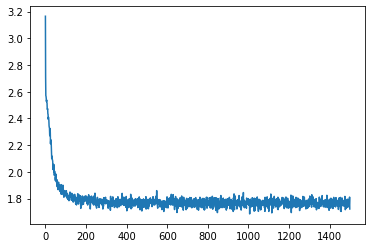

2000
tensor(1.6850, requires_grad=True)
Test Loss:  tensor(1.7851, grad_fn=<DivBackward0>)
Test Time:  0.0064373016357421875
5 -fold:  2
(8000, 4)
epoch: 0 loss: 3.2437212467193604 min loss: tensor(3.2437, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.8667690753936768 min loss: tensor(1.7894, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.8103291988372803 min loss: tensor(1.7387, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.753071665763855 min loss: tensor(1.7309, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.7446250915527344 min loss: tensor(1.7071, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.7629042863845825 min loss: tensor(1.7071, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.784503698348999 min loss: tensor(1.7071, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.7540541887283325 min loss: tensor(1.7071, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.799533724784851 min loss: tensor(1.6714, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.763901948928833 min loss: tensor(1.6714, grad_fn=<DivBackward0>)


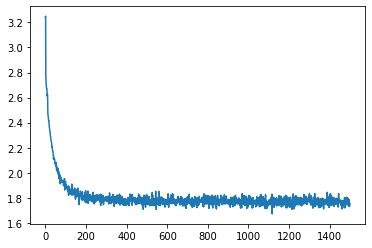

2000
tensor(1.6714, requires_grad=True)
Test Loss:  tensor(1.7644, grad_fn=<DivBackward0>)
Test Time:  0.006234407424926758
5 -fold:  3
(8000, 4)
epoch: 0 loss: 3.7795751094818115 min loss: tensor(3.7796, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.823639154434204 min loss: tensor(1.7794, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.8311182260513306 min loss: tensor(1.7261, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.7818968296051025 min loss: tensor(1.7209, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.7874860763549805 min loss: tensor(1.7194, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.7640413045883179 min loss: tensor(1.7183, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.7272822856903076 min loss: tensor(1.7183, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.8237338066101074 min loss: tensor(1.7183, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.7477362155914307 min loss: tensor(1.6868, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.8236407041549683 min loss: tensor(1.6868, grad_fn=<DivBackward0>)


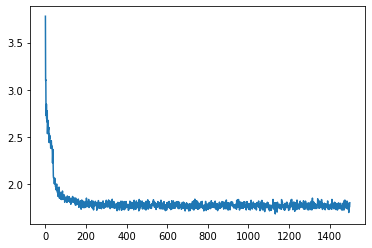

2000
tensor(1.6868, requires_grad=True)
Test Loss:  tensor(1.7574, grad_fn=<DivBackward0>)
Test Time:  0.006662607192993164
5 -fold:  4
(8000, 4)
epoch: 0 loss: 3.803752899169922 min loss: tensor(3.8038, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.7631845474243164 min loss: tensor(1.7632, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.7637361288070679 min loss: tensor(1.7196, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.7646478414535522 min loss: tensor(1.7196, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.7911237478256226 min loss: tensor(1.7151, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.9006619453430176 min loss: tensor(1.6191, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.8920198678970337 min loss: tensor(1.6191, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.886660099029541 min loss: tensor(1.6191, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.8853328227996826 min loss: tensor(1.6191, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.8697762489318848 min loss: tensor(1.6191, grad_fn=<DivBackward0>)


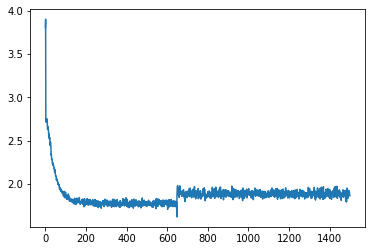

2000
tensor(1.6191, requires_grad=True)
Test Loss:  tensor(1.8679, grad_fn=<DivBackward0>)
Test Time:  0.007618427276611328
5 -fold:  5
(8000, 4)
epoch: 0 loss: 2.996029853820801 min loss: tensor(2.9960, grad_fn=<DivBackward0>)
epoch: 150 loss: 1.7752583026885986 min loss: tensor(1.7573, grad_fn=<DivBackward0>)
epoch: 300 loss: 1.7180218696594238 min loss: tensor(1.7095, grad_fn=<DivBackward0>)
epoch: 450 loss: 1.796438455581665 min loss: tensor(1.6743, grad_fn=<DivBackward0>)
epoch: 600 loss: 1.7872862815856934 min loss: tensor(1.6743, grad_fn=<DivBackward0>)
epoch: 750 loss: 1.7594832181930542 min loss: tensor(1.6743, grad_fn=<DivBackward0>)
epoch: 900 loss: 1.7581655979156494 min loss: tensor(1.6743, grad_fn=<DivBackward0>)
epoch: 1050 loss: 1.8240488767623901 min loss: tensor(1.6743, grad_fn=<DivBackward0>)
epoch: 1200 loss: 1.7694928646087646 min loss: tensor(1.6743, grad_fn=<DivBackward0>)
epoch: 1350 loss: 1.794061541557312 min loss: tensor(1.6743, grad_fn=<DivBackward0>)


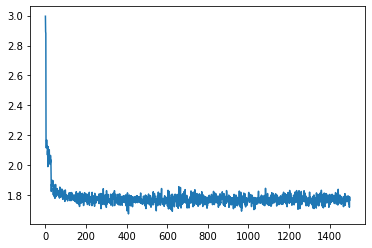

2000
tensor(1.6743, requires_grad=True)
Test Loss:  tensor(1.7813, grad_fn=<DivBackward0>)
Test Time:  0.006585121154785156
Training Minimum Loss:
[array(1.6849608, dtype=float32), array(1.6713917, dtype=float32), array(1.6868057, dtype=float32), array(1.6190815, dtype=float32), array(1.6743137, dtype=float32)]
Training Time:
[7.400449752807617, 7.26529598236084, 7.56755805015564, 7.681432485580444, 7.581414461135864]
Average Training Loss:  1.6673107
Std Training Loss:  0.024832785
Average Training Time:  7.499230146408081
Std Training Time:  0.14771825593746765
Testing Loss:
[array(1.7851349, dtype=float32), array(1.7644467, dtype=float32), array(1.7573569, dtype=float32), array(1.8678882, dtype=float32), array(1.7813071, dtype=float32)]
Testing Time:
[0.0064373016357421875, 0.006234407424926758, 0.006662607192993164, 0.007618427276611328, 0.006585121154785156]
Average Testing Loss:  1.7912267
Std Testing Loss:  0.03969087
Average Testing Time:  0.006707572937011718
Std Testing Time:

In [40]:
#print(np.unique(data, return_counts=True))
#print(data.shape)
batch_size, sequence_length, vocab_size, k_fold = 1024, 4, 2, 5

num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = data.shape[0]
data = np.load('/content/coup_data_4_2_moderate_corr.npy').astype(int)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type, hid_lay)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp7', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

Weak Correlation

5 -fold:  1
(8000, 4)
epoch: 0 loss: 3.341201066970825 min loss: tensor(3.3412, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 2.354233980178833 min loss: tensor(2.3195, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.441546678543091 min loss: tensor(2.3195, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.414768695831299 min loss: tensor(2.3195, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.4225826263427734 min loss: tensor(2.3195, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.4014017581939697 min loss: tensor(2.3195, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.40393328666687 min loss: tensor(2.3195, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.3653080463409424 min loss: tensor(2.3195, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.395956039428711 min loss: tensor(2.3195, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.4651293754577637 min loss: tensor(2.3195, grad_fn=<DivBackward0>)


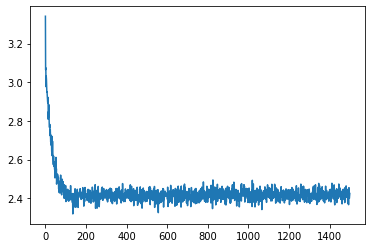

2000
tensor(2.3195, requires_grad=True)
Test Loss:  tensor(2.4208, grad_fn=<DivBackward0>)
Test Time:  0.005524158477783203
5 -fold:  2
(8000, 4)
epoch: 0 loss: 4.852701187133789 min loss: tensor(4.8527, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.4985549449920654 min loss: tensor(2.3841, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.4467062950134277 min loss: tensor(2.3580, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.400317907333374 min loss: tensor(2.3580, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.433318614959717 min loss: tensor(2.3580, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.4042935371398926 min loss: tensor(2.3517, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.401580810546875 min loss: tensor(2.3452, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.3893754482269287 min loss: tensor(2.3450, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.4385149478912354 min loss: tensor(2.3450, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.393815517425537 min loss: tensor(2.3450, grad_fn=<DivBackward0>)


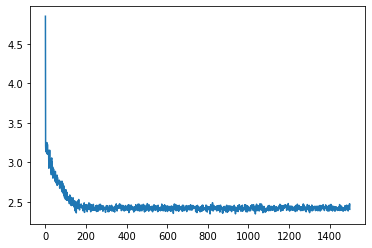

2000
tensor(2.3450, requires_grad=True)
Test Loss:  tensor(2.4057, grad_fn=<DivBackward0>)
Test Time:  0.006545066833496094
5 -fold:  3
(8000, 4)
epoch: 0 loss: 3.5129363536834717 min loss: tensor(3.5129, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.4540982246398926 min loss: tensor(2.3536, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.409799337387085 min loss: tensor(2.3536, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.4153807163238525 min loss: tensor(2.3521, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.463170051574707 min loss: tensor(2.3521, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.419205665588379 min loss: tensor(2.3521, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.415863275527954 min loss: tensor(2.3521, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.400343894958496 min loss: tensor(2.3484, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.4315435886383057 min loss: tensor(2.3484, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.442808151245117 min loss: tensor(2.3484, grad_fn=<DivBackward0>)


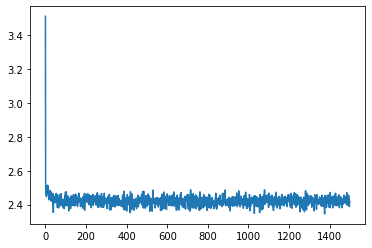

2000
tensor(2.3449, requires_grad=True)
Test Loss:  tensor(2.4060, grad_fn=<DivBackward0>)
Test Time:  0.006204128265380859
5 -fold:  4
(8000, 4)
epoch: 0 loss: 3.6589128971099854 min loss: tensor(3.6589, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.389402389526367 min loss: tensor(2.3552, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.435479164123535 min loss: tensor(2.3552, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.384040355682373 min loss: tensor(2.3552, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.3708136081695557 min loss: tensor(2.3552, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.4066832065582275 min loss: tensor(2.3483, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.3995485305786133 min loss: tensor(2.3476, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.4418814182281494 min loss: tensor(2.3476, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.421799898147583 min loss: tensor(2.3476, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.4370789527893066 min loss: tensor(2.3476, grad_fn=<DivBackward0>)


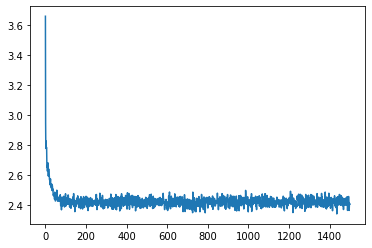

2000
tensor(2.3401, requires_grad=True)
Test Loss:  tensor(2.4096, grad_fn=<DivBackward0>)
Test Time:  0.008241415023803711
5 -fold:  5
(8000, 4)
epoch: 0 loss: 4.508815765380859 min loss: tensor(4.5088, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.389711856842041 min loss: tensor(2.3733, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.3467001914978027 min loss: tensor(2.3467, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.3865671157836914 min loss: tensor(2.3467, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.446446657180786 min loss: tensor(2.3467, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.404642343521118 min loss: tensor(2.3467, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.39920973777771 min loss: tensor(2.3467, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.431959629058838 min loss: tensor(2.3467, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.4182233810424805 min loss: tensor(2.3356, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.4066054821014404 min loss: tensor(2.3356, grad_fn=<DivBackward0>)


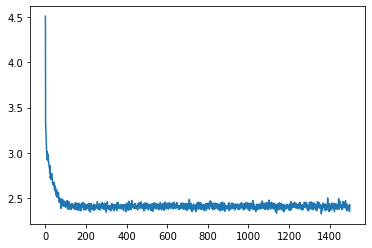

2000
tensor(2.3269, requires_grad=True)
Test Loss:  tensor(2.4399, grad_fn=<DivBackward0>)
Test Time:  0.005370616912841797
Training Minimum Loss:
[array(2.319534, dtype=float32), array(2.344972, dtype=float32), array(2.344889, dtype=float32), array(2.340133, dtype=float32), array(2.32689, dtype=float32)]
Training Time:
[7.419262170791626, 7.367276906967163, 7.334299325942993, 7.60569953918457, 7.34241247177124]
Average Training Loss:  2.3352835
Std Training Loss:  0.010277568
Average Training Time:  7.413790082931518
Std Training Time:  0.10043525526899258
Testing Loss:
[array(2.4207556, dtype=float32), array(2.405743, dtype=float32), array(2.4059823, dtype=float32), array(2.4095902, dtype=float32), array(2.4398804, dtype=float32)]
Testing Time:
[0.005524158477783203, 0.006545066833496094, 0.006204128265380859, 0.008241415023803711, 0.005370616912841797]
Average Testing Loss:  2.4163902
Std Testing Loss:  0.012952028
Average Testing Time:  0.006377077102661133
Std Testing Time:  0.001

In [41]:
#print(np.unique(data, return_counts=True))
#print(data.shape)
batch_size, sequence_length, vocab_size, k_fold = 1024, 4, 2, 5

num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = data.shape[0]
data = np.load('/content/coup_data_4_2_weak_corr.npy').astype(int)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type, hid_lay)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp7', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))

No Correlation

5 -fold:  1
(8000, 4)
epoch: 0 loss: 3.504047155380249 min loss: tensor(3.5040, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch: 150 loss: 2.548978805541992 min loss: tensor(2.4978, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.472341299057007 min loss: tensor(2.4589, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.469432830810547 min loss: tensor(2.4416, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.5145914554595947 min loss: tensor(2.4416, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.4756734371185303 min loss: tensor(2.4416, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.497976541519165 min loss: tensor(2.4416, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.470707654953003 min loss: tensor(2.4373, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.5210676193237305 min loss: tensor(2.4373, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.503282308578491 min loss: tensor(2.4373, grad_fn=<DivBackward0>)


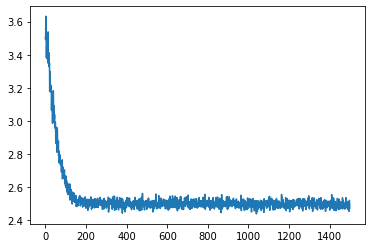

2000
tensor(2.4373, requires_grad=True)
Test Loss:  tensor(2.4765, grad_fn=<DivBackward0>)
Test Time:  0.005605459213256836
5 -fold:  2
(8000, 4)
epoch: 0 loss: 3.152912139892578 min loss: tensor(3.1529, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.518458843231201 min loss: tensor(2.4481, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.481936454772949 min loss: tensor(2.4481, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.4552056789398193 min loss: tensor(2.4436, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.4844093322753906 min loss: tensor(2.4436, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.502892017364502 min loss: tensor(2.4436, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.496019124984741 min loss: tensor(2.4436, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.513728618621826 min loss: tensor(2.4436, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.503688097000122 min loss: tensor(2.4436, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.4758968353271484 min loss: tensor(2.4436, grad_fn=<DivBackward0>)


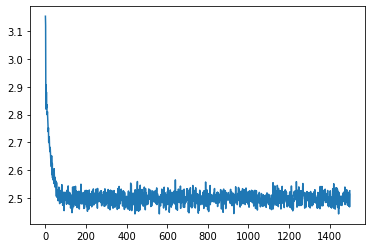

2000
tensor(2.4436, requires_grad=True)
Test Loss:  tensor(2.4758, grad_fn=<DivBackward0>)
Test Time:  0.0062601566314697266
5 -fold:  3
(8000, 4)
epoch: 0 loss: 3.4366469383239746 min loss: tensor(3.4366, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.5241265296936035 min loss: tensor(2.4504, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.5219898223876953 min loss: tensor(2.4504, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.4963626861572266 min loss: tensor(2.4475, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.496553659439087 min loss: tensor(2.4356, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.494002342224121 min loss: tensor(2.4356, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.4919040203094482 min loss: tensor(2.4356, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.533616781234741 min loss: tensor(2.4356, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.503465175628662 min loss: tensor(2.4356, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.4987456798553467 min loss: tensor(2.4356, grad_fn=<DivBackward0>)


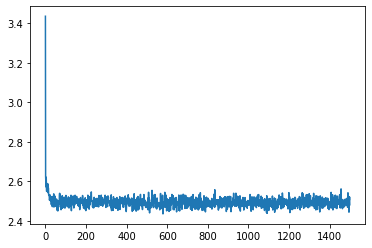

2000
tensor(2.4356, requires_grad=True)
Test Loss:  tensor(2.4934, grad_fn=<DivBackward0>)
Test Time:  0.0064373016357421875
5 -fold:  4
(8000, 4)
epoch: 0 loss: 3.0926523208618164 min loss: tensor(3.0927, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.4703404903411865 min loss: tensor(2.4438, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.5030107498168945 min loss: tensor(2.4438, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.510061502456665 min loss: tensor(2.4438, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.496783494949341 min loss: tensor(2.4438, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.4983248710632324 min loss: tensor(2.4399, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.501391887664795 min loss: tensor(2.4385, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.4863078594207764 min loss: tensor(2.4385, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.4802982807159424 min loss: tensor(2.4385, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.5026392936706543 min loss: tensor(2.4379, grad_fn=<DivBackward0>)


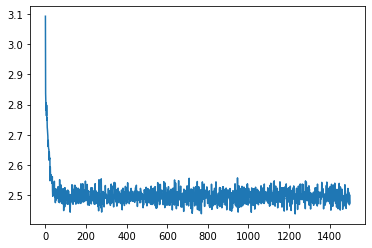

2000
tensor(2.4379, requires_grad=True)
Test Loss:  tensor(2.4923, grad_fn=<DivBackward0>)
Test Time:  0.007416248321533203
5 -fold:  5
(8000, 4)
epoch: 0 loss: 3.4713377952575684 min loss: tensor(3.4713, grad_fn=<DivBackward0>)
epoch: 150 loss: 2.4737436771392822 min loss: tensor(2.4094, grad_fn=<DivBackward0>)
epoch: 300 loss: 2.489413261413574 min loss: tensor(2.4094, grad_fn=<DivBackward0>)
epoch: 450 loss: 2.5142123699188232 min loss: tensor(2.4094, grad_fn=<DivBackward0>)
epoch: 600 loss: 2.494272470474243 min loss: tensor(2.4094, grad_fn=<DivBackward0>)
epoch: 750 loss: 2.474013566970825 min loss: tensor(2.4094, grad_fn=<DivBackward0>)
epoch: 900 loss: 2.512564182281494 min loss: tensor(2.4094, grad_fn=<DivBackward0>)
epoch: 1050 loss: 2.471782684326172 min loss: tensor(2.4094, grad_fn=<DivBackward0>)
epoch: 1200 loss: 2.5111069679260254 min loss: tensor(2.4094, grad_fn=<DivBackward0>)
epoch: 1350 loss: 2.493655204772949 min loss: tensor(2.4094, grad_fn=<DivBackward0>)


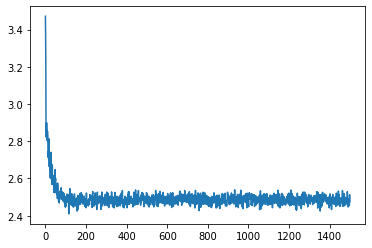

2000
tensor(2.4094, requires_grad=True)
Test Loss:  tensor(2.5391, grad_fn=<DivBackward0>)
Test Time:  0.006742715835571289
Training Minimum Loss:
[array(2.437346, dtype=float32), array(2.4435863, dtype=float32), array(2.4356005, dtype=float32), array(2.4379413, dtype=float32), array(2.4094, dtype=float32)]
Training Time:
[7.346084117889404, 7.138808012008667, 7.391807317733765, 7.334851264953613, 7.380009412765503]
Average Training Loss:  2.432775
Std Training Loss:  0.011990369
Average Training Time:  7.31831202507019
Std Training Time:  0.0921679466981902
Testing Loss:
[array(2.476544, dtype=float32), array(2.4757752, dtype=float32), array(2.493383, dtype=float32), array(2.4922652, dtype=float32), array(2.5391436, dtype=float32)]
Testing Time:
[0.005605459213256836, 0.0062601566314697266, 0.0064373016357421875, 0.007416248321533203, 0.006742715835571289]
Average Testing Loss:  2.4954221
Std Testing Loss:  0.023100112
Average Testing Time:  0.0064923763275146484
Std Testing Time:  0.

In [42]:
#print(np.unique(data, return_counts=True))
#print(data.shape)
batch_size, sequence_length, vocab_size, k_fold = 1024, 4, 2, 5

num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'

train_store_time = []
train_store_min_loss = []
test_store_time = []
test_store_loss = []
sample_size = data.shape[0]
data = np.load('/content/coup_data_4_2_no_corr.npy').astype(int)
for k_fold_idx in range(k_fold):
      print(k_fold, '-fold: ', k_fold_idx + 1)
      train_data, test_data = kfold_splitter(data=data, n=sample_size, k=k_fold, fold_num=k_fold_idx)
      print(train_data.shape)
      # Training
      base_log_probs = create_base_prior(sequence_length, vocab_size)
      model = disc_flow_param(num_flows, temperature, vocab_size, sequence_length, batch_size, disc_layer_type, hid_lay)
      loss, final_time, load_path = train_disc_flow(model, train_data, base_log_probs, 'exp7', k_fold, k_fold_idx, epochs=1500, learning_rate=0.01)
      train_store_min_loss.append(loss.clone().detach().numpy())
      train_store_time.append(final_time)
      # Testing
      loss, final_time = test_disc_flow(test_data, load_path)
      print("Test Loss: ", loss)
      print("Test Time: ", final_time)
      test_store_loss.append(loss.clone().detach().numpy())
      test_store_time.append(final_time)
print("Training Minimum Loss:")
print(train_store_min_loss)
print("Training Time:")
print(train_store_time)
print("Average Training Loss: ", np.average(train_store_min_loss))
print("Std Training Loss: ", np.std(train_store_min_loss))
print("Average Training Time: ", np.average(train_store_time))
print("Std Training Time: ", np.std(train_store_time))
print("Testing Loss:")
print(test_store_loss)
print("Testing Time:")
print(test_store_time)
print("Average Testing Loss: ", np.average(test_store_loss))
print("Std Testing Loss: ", np.std(test_store_loss))
print("Average Testing Time: ", np.average(test_store_time))
print("Std Testing Time: ", np.std(test_store_time))